In [39]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import jit,njit
from numba import int32, float32 ,float64,vectorize   # import the types
from numba.experimental import jitclass
from numba.typed import List as NumbaList
from scipy.integrate import solve_ivp
from typing import List
import pickle 
exp=np.exp

@jit 
def heaviside (t):
    return (1+np.sign(t))/2
@jit 
def pulse (t,ti,tf):
    return heaviside(t-ti)-heaviside(t-tf)

sin=np.sin
pi=np.pi
#boltz(V::Float64,A::Float64,B::Float64) = 1/(1 + exp((V+A)/B))
@jit
def boltz(V,A,B):
    return 1/(1 + exp((V+A)/B))
#tauX(V::Float64,A::Float64,B::Float64,D::Float64,E::Float64) = A - B/(1+exp((V+D)/E))
@jit
def tauX(V,A,B,D,E):
    return A - B/(1+exp((V+D)/E))
#mNainf(V::Float64) = boltz(V,25.5,-5.29)
@jit
def mNa_inf(V):
    return boltz(V,25.5,-5.29)
#taumNa(V::Float64) = tauX(V,1.32,1.26,120.,-25.)
@jit 
def tau_mNa(V):
    return tauX(V,1.32,1.26,120.,-25.)
#hNainf(V::Float64) = boltz(V,48.9,5.18)
@jit
def hNa_inf(V):
    return boltz(V,48.9,5.18)
#tauhNa(V::Float64) = (0.67/(1+exp((V+62.9)/-10.0)))*(1.5 + 1/(1+exp((V+34.9)/3.6)))
@jit
def tau_hNa (V):
    return (0.67/(1+exp((V+62.9)/-10.0)))*(1.5 + 1/(1+exp((V+34.9)/3.6)))
#mCaTinf(V::Float64) = boltz(V,27.1,-7.2)
@jit
def mt_inf (V):
    return boltz(V,27.1,-7.2)
#taumCaT(V::Float64,taumCa::Float64) = taumCa*tauX(V,21.7,21.3,68.1,-20.5)
@jit
def tau_mt (V,taumCa):
    return taumCa*tauX(V,21.7,21.3,68.1,-20.5)
#hCaTinf(V::Float64) = boltz(V,32.1,5.5)
@jit
def ht_inf(V):
    return boltz(V,32.1,5.5)
#tauhCaT(V::Float64) = tauX(V,105.,89.8,55.,-16.9)
@jit
def tau_ht(V):
    return tauX(V,105.,89.8,55.,-16.9)
#mCaSinf(V::Float64) = boltz(V,33.,-8.1)
@jit
def mS_inf(V):
    return boltz(V,33.,-8.1)
#taumCaS(V::Float64,taumCa::Float64) = taumCa*(1.4 + (7/((exp((V+27)/10))+(exp((V+70)/-13)))))
@jit
def tau_mS(V,taumCa):
    return taumCa*(1.4 + (7/((exp((V+27)/10))+(exp((V+70)/-13)))))
#hCaSinf(V::Float64) = boltz(V,60.,6.2)
@jit
def OB_tau_mS(V,taumCa):
    return taumCa*(1.4 + (7*0.99/((exp((V+27*0.95)/10))+(exp((V+70*1.1)/-13)))))
@jit
def hS_inf(V):
    return boltz(V,60.,6.2)
#tauhCaS(V::Float64) = 60 + (150/((exp((V+55)/9))+(exp((V+65)/-16))))
@jit
def tau_hS(V):
    return 60 + (150/((exp((V+55)/9))+(exp((V+65)/-16))))
#mAinf(V::Float64) = boltz(V,27.2,-8.7)
@jit
def mA_inf (V):
    return boltz(V,27.2,-8.7)
#taumA(V::Float64) = tauX(V,11.6,10.4,32.9,-15.2)
@jit
def tau_mA (V):
    return tauX(V,11.6,10.4,32.9,-15.2)
#hAinf(V::Float64) = boltz(V,56.9,4.9)
@jit
def hA_inf (V):
    return boltz(V,56.9,4.9)
#tauhA(V::Float64) = tauX(V,38.6,29.2,38.9,-26.5)
@jit
def tau_hA(V): 
    return tauX(V,38.6,29.2,38.9,-26.5)
#mKCainf(V::Float64,Ca::Float64,KdCa::Float64) = (Ca/(Ca+KdCa))*(1/(1+exp((V+28.3)/-12.6)))
@jit 
def mK_inf(V,Ca,KdCa):
    return (Ca/(Ca+KdCa))*(1/(1+exp((V+28.3)/-12.6)))
#taumKCa(V::Float64,tmKCa::Float64) = tmKCa*tauX(V,90.3,75.1,46.,-22.7)
@jit
def tau_mK(V,tmKCa):
    return tmKCa*tauX(V,90.3,75.1,46.,-22.7)
#mKdinf(V::Float64) = boltz(V,12.3,-11.8)
@jit
def mKd_inf (V):
    return boltz(V,12.3,-11.8)
#taumKd(V::Float64) = tauX(V,7.2,6.4,28.3,-19.2)
@jit
def tau_mKd (V):
    return tauX(V,7.2,6.4,28.3,-19.2)
#mHinf(V::Float64) = boltz(V,70.,6.)
@jit
def mH_inf (V):
    return boltz(V,70.,6.)
#taumH(V::Float64) = tauX(V,272.,-1499.,42.2,-8.73)
@jit
def tau_mH(V):
    return tauX(V,272.,-1499.,42.2,-8.73)
# function sinf(V::Float64,Vth::Float64,Vslope::Float64)
#     if V < Vth
#         sinf = 0;
#     else
#         sinf = tanh((V-Vth)/Vslope);
#         end
#     return sinf
# end

@vectorize([float64(float64, float64,float64)])
def sinf(V,Vth,Vslope):
    if V < Vth:
        sinf = 0
    else:
        sinf = np.tanh((V-Vth)/Vslope)
    return sinf
    
#sinf2(V::Float64) = boltz(V,25.,-5.)
@jit
def sinf2(V):
    return boltz(V,25.,-5.)
@jit 
def max_abs(a,b):
    if abs(a)>abs(b):
        return a
    else:
        return b
    
@jitclass([( "gSyn", float64[:]),("gE",float64[:]),( "mask", float64[:]),( "gamma_mask", float64[:]),( "theta", float64[:])])
class neuron:
    
    min_num:float
    Iapp:float
    I1:float # Amplitude of first step input
    I2:float # Amplitude of second step input
    ti1:float # Starting time of first step input
    tf1:float # Ending time of first step input
    ti2:float # Starting time of second step input
    tf2:float # Ending time of second step input
    taunoise:float# Cutoff frequency for low-pass filtered Gaussian noise
    Ain:float# Amplitude of sinusoïdal inut
    Win:float # Frequency of  sinusoïdal inut
    gSyn:np.ndarray
    gE:np.ndarray
    gE_num:int
    syn_num:int
    VNa:float# Sodium reversal potential 45
    VCa:float # Calcium reversal potential
    VK:float # Potassium reversal potential -90
    VH:float# Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
    Vleak:float # Reversal potential of leak channels
    VSyn:float
    KdCa:float
    kc:float
    gT:float # T-type calcium current maximal conductance
    gKd:float  # Delayed-rectifier potassium current maximal conductance
    gH:float# H-current maximal conductance
    gNa:float # Sodium current maximal conductance
    gA:float # A-type potassium current maximal conductance
    gKir:float  # Inward-rectifier potassium current maximal conductance
    gL:float # L-type calcium current maximal conductance
    gKCa:float # Calcium-activated potassium current maximal conductance
    gS:float
    a:float
    b:float
    C:float # Membrane capacitance
    gLeak:float # Leak current maximal conductance
    num_phi:int
    num_dinamics:int
    num_Theta:int
    pos_dinamics:int
    pos_Theta:int
    pos_phi:int
    pos_p:int
    pos_u_sys:int
    gamma:float
    mask:np.ndarray #freeze variable by setting 0 in the mask
    theta:np.ndarray 
    gamma_mask:np.ndarray
    alpha:float
    tauKCa:float
    taumCa:float
    taus:float
    
    def __init__(self,p:List[float]):
        
        self.min_num=1e-70 
        self.Iapp=0. # Amplitude of constant applied current
        self.I1=0. # Amplitude of first step input
        self.I2=0. # Amplitude of second step input
        self.ti1=0. # Starting time of first step input
        self.tf1=0. # Ending time of first step input
        self.ti2=0. # Starting time of second step input
        self.tf2=0. # Ending time of second step input
        self.taunoise=0.# Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=0. # Amplitude of sinusoïdal inut
        self.Win=0. # Frequency of  sinusoïdal inut
        self.syn_num=0
        self.gE_num=0
        self.VNa = 45; # Sodium reversal potential 45
        self.VCa = 120.; # Calcium reversal potential
        self.VK = -90.; # Potassium reversal potential -90
        self.VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = -55.; # Reversal potential of leak channels
        self.VSyn=-120.
        self.tauKCa=1
        self.taumCa=1
        self.taus=1
        
        self.gT=p[0] # T-type calcium current maximal conductance
        self.gKd=p[1]  # Delayed-rectifier potassium current maximal conductance
        self.gH=p[2] # H-current maximal conductance
        self.gNa=p[3] # Sodium current maximal conductance
        self.gA=p[4] # A-type potassium current maximal conductance
        self.gS=p[5]  # Inward-rectifier potassium current maximal conductance
        #self.gL=p[6] # L-type calcium current maximal conductance
        self.gKCa=p[6] # Calcium-activated potassium current maximal conductance
        self.C=p[7] # Membrane capacitance
        self.gLeak=p[8] # Leak current maximal conductance
        self.KdCa=p[9]
        self.kc=p[10]
        
#         PHI0= -mNa**3*hNa*(obesV-self.VNa) 
#         PHI1= -mH*(obesV-self.VH)
#         PHI2= -mt**3*ht*(obesV-self.VCa)
#         PHI3= -mA**3*hA*(obesV-self.VK)
#         PHI4= - mKd**4*(obesV-self.VK)
#         PHI5= -(obesV-self.Vleak)
#         PHI6= -mKCa**4*(obesV-self.VK)
#         PHI7= -mS**3*hS*(obesV-self.VCa)
        
        self.theta=np.array([self.gNa,self.gH,self.gT,self.gA,self.gKd,self.gLeak,self.gKCa,self.gS])
        
        self.num()
        
    def set_rev(self,p):
        self.VNa = p[0] # Sodium reversal potential 45
        self.VCa = p[1] ; # Calcium reversal potential
        self.VK = p[2] ; # Potassium reversal potential -90
        self.VH= p[3] ; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = p[4] ; # Reversal potential of leak channels
        self.VSyn=p[5] 
        
    def num(self):
        
        num_dinamics=14+self.syn_num
        num_Theta=8+self.syn_num+self.gE_num
        self.num_phi=num_Theta
        num_p=num_Theta**2
        num_u_sys=14+self.syn_num
        print('num_Theta',num_Theta)
        
        self.num_dinamics=num_dinamics
        self.num_Theta=num_Theta
        
        self.pos_dinamics=num_dinamics
        self.pos_Theta=self.pos_dinamics+num_Theta
        self.pos_phi=self.pos_Theta+self.num_phi
        self.pos_p=self.pos_phi+num_p
        self.pos_u_sys=self.pos_p+num_u_sys
        
    def set_tau(self,tau,tau2,tau3):
        self.tauKCa=tau
        self.taumCa=tau2
        self.taus=tau3
        
    def syn_connect(self,gSyn):
        self.gSyn=gSyn #synaptic conductance[1*syn_num]
        self.syn_num=len(gSyn)
        self.num()
        
    def E_connect(self,E):
        self.gE=E
        self.gE_num=len(E)
        self.num()
        
    def set_input(self,p:List[float]):
        self.Iapp=p[0] # Amplitude of constant applied current
        self.I1=p[1] # Amplitude of first step input
        self.I2=p[2] # Amplitude of second step input
        self.ti1=p[3] # Starting time of first step input
        self.tf1=p[4] # Ending time of first step input
        self.ti2=p[5] # Starting time of second step input
        self.tf2=p[6] # Ending time of second step input
        self.taunoise=p[7] # Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=p[8] # Amplitude of sinusoïdal inut
        self.Win=p[9] # Frequency of  sinusoïdal inut

    
    def set_mod(self,gS,gT):
        self.gS=gS
        self.gT=gT
         

    def sys_equ(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        V=u[0] # Membrane potential
        mNa=u[1] # Sodium current activation
        hNa=u[2] # Sodium current inactivation
        mH=u[3] # H current activation
        mt=u[4] # T-type calcium current activation
        ht=u[5] # T-type calcium current inactivation
        mA=u[6] # A-type potassium current activation
        hA=u[7] # A-type potassium current inactivation
        mKd=u[8] # Delayed-rectifier potassium current activation
        mKCa=u[9] # L-type calcium current activation
        mS=u[10] # Intracellular calcium concentration
        hS=u[11]
        Ca=u[12]
        noise=u[13] # Input noise
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[14:14+self.syn_num] # synapse
        
        
        if len(V_pre)<self.syn_num:
            raise Exception('invaild V_pre')
        
        syn_i=0.
        if self.syn_num>0:
            syn_i=-np.dot(self.gSyn,mSyn)*(V-self.VSyn)# synapse
            
        E_i=0 
        if self.gE_num>0:
            E_i=-np.dot(self.gE,(V-V_pre_E))# synapse
        
        
#         (dt)*(1/C)*(-gNa*mNa^3*hNa*(V-VNa) -gCaT*mCaT^3*hCaT*(V-VCa) -gCaS*mCaS^3*hCaS*(V-VCa)
#                     -gA*mA^3*hA*(V-VK) -gKCa*mKCa^4*(V-VK) -gKd*mKd^4*(V-VK) -gH*mH*(V-VH) 
#                     -gleak*(V-Vleak) + Iapp)
        
        du1=1/self.C*(- self.gNa*mNa**3*hNa*(V-self.VNa) - self.gH*mH*(V-self.VH) - self.gT*mt**3*ht*(V-self.VCa) 
                 - self.gA*mA**3*hA*(V-self.VK) - self.gKd*mKd**4*(V-self.VK)
                 - self.gLeak*(V-self.Vleak)
                 - self.gKCa*mKCa**4*(V-self.VK)
                 - self.gS*mS**3*hS*(V-self.VCa)
                 +syn_i
             + self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) 
             + self.I2*pulse(t,self.ti2,self.tf2) + noise + self.Ain*sin(2*pi*self.Win*t))+E_i# Voltage equation
    
        du2=1/max_abs(tau_mNa(V),self.min_num)*(-mNa+mNa_inf(V)) # gating equation
        du3=1/max_abs(tau_hNa(V),self.min_num)*(-hNa+hNa_inf(V))
        du4=1/max_abs(tau_mH(V),self.min_num)*(-mH+mH_inf(V))
        du5=1/max_abs(tau_mt(V,self.taumCa),self.min_num)*(-mt+mt_inf(V))
        du6=1/max_abs(tau_ht(V),self.min_num)*(-ht+ht_inf(V))
        du7=1/max_abs(tau_mA(V),self.min_num)*(-mA+mA_inf(V))
        du8=1/max_abs(tau_hA(V),self.min_num)*(-hA+hA_inf(V))
        du9=1/max_abs(tau_mKd(V),self.min_num)*(-mKd+mKd_inf(V))
        #dmKCa= (dt)*((1/taumKCa(V,tmKCa))*(mKCainf(V,Ca,KdCa) - mKCa))
        du10=1/max_abs(tau_mK(V,self.tauKCa),self.min_num)*(mK_inf(V,Ca,self.KdCa) - mKCa)
        #dmCaS(V::Float64,mCaS::Float64,taumCa::Float64) = (dt)*((1/taumCaS(V,taumCa))*(mCaSinf(V) - mCaS))
        #dhCaS(V::Float64,hCaS::Float64) = (dt)*((1/tauhCaS(V))*(hCaSinf(V) - hCaS))
        du11=1/max_abs(tau_mS(V,self.taumCa),self.min_num)*(mS_inf(V) - mS)
        du12=1/max_abs(tau_hS(V),self.min_num)*(hS_inf(V) - hS)
        #(-kc*(gCaT*mCaT^3*hCaT*(V-VCa) +gCaS*mCaS^3*hCaS*(V-VCa)) - Ca + 0.05)
        du13=-self.kc*(self.gT*mt**3*ht*(V-self.VCa) +self.gS*mS**3*hS*(V-self.VCa)) - Ca + 0.05# Variation of intracellular calcium concentration
        du14=-noise/self.taunoise
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du15=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,*du15]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14]

        return result
    
    def equ(self,t,u):
        return self.sys_equ(t,u,np.array([0.]),np.array([0.]))
    
    def set_hyp(self,gamma,alpha,variable_mask):
        #Hyperparameters
        self.gamma=gamma
        self.mask=variable_mask #freeze variable by setting 0 in the mask
        self.gamma_mask=variable_mask*gamma
        self.alpha=alpha
    
    def init_cond(self,V0):
        #Ca=(-kcvec[1]*(gCaTvec[1]*mCaT[1]^3*hCaT[1]*(V[1]-VCa) +gCaSvec[1]*mCaS[1]^3*hCaS[1]*(V[1]-VCa)) + 0.05)*ones(5)
        mS=mS_inf(V0)
        hS=hS_inf(V0)
        Ca=-self.kc*(self.gT*mt_inf(V0)**3*ht_inf(V0)*(V0-self.VCa)+ self.gS*mS**3*hS*(V0-self.VCa)) + 0.05
        
        x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), 
      mK_inf(V0,Ca,self.KdCa),mS,hS,Ca,0.]
        
        for i in range(self.syn_num):
            x0.append(0)
        return x0
    
    def init_cond_OB(self,V0):
        x0_=self.init_cond(V0)
        V1=-np.random.rand(1)*100
        x0=self.init_cond(V1[0])
        theta=np.array([*self.theta,*self.gSyn,*self.gE])
        Theta0= np.random.rand(self.num_Theta)*100.*(self.mask)+(1-self.mask)*theta
        print(Theta0)
        print(V1)
        A0=(np.ones(self.num_Theta)*0.1)
        P0=np.diag(np.diag(np.outer(A0,A0))).flatten()
        X0_=[*x0,*Theta0,*A0,*P0,*x0_]
        return X0_
    
    def OB_ODE(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        PHI8:float64[:]
        PHI9:float64[:]

        V,mNa,hNa,mH,mt,ht,mA,hA,mKd,mKCa,mS,hS,Ca,noise=u[0:14]
    
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[14:14+self.syn_num] # synapse

        u_sys=u[self.pos_p:self.pos_u_sys]
        P=u[self.pos_phi:self.pos_p].reshape(self.num_phi,self.num_phi)
        Theta=u[self.pos_dinamics:self.pos_Theta]
        #print(Theta)
        phi=u[self.pos_Theta:self.pos_phi]

        obesV=u_sys[0]
    
        PHI0= -mNa**3*hNa*(obesV-self.VNa) 
        PHI1= -mH*(obesV-self.VH)
        PHI2= -mt**3*ht*(obesV-self.VCa)
        PHI3= -mA**3*hA*(obesV-self.VK)
        PHI4= - mKd**4*(obesV-self.VK)
        PHI5= -(obesV-self.Vleak)
        PHI6= -mKCa**4*(obesV-self.VK)
        PHI7= -mS**3*hS*(obesV-self.VCa)
        
        PHI_=[PHI0,PHI1,PHI2,PHI3,PHI4,PHI5,PHI6,PHI7]
        
        if (self.syn_num>0) and (self.gE_num>0):
            PHI8=-mSyn*(obesV-self.VSyn)
            PHI9=-(obesV-V_pre_E)
            PHI_=[*PHI_,*PHI8,*PHI9]
        else:
            if self.gE_num>0:
                PHI9=-(obesV-V_pre_E)*self.C
                PHI_=[*PHI_,*PHI9]
            if self.syn_num>0:
                PHI8=-mSyn*(obesV-self.VSyn)
                PHI_=[*PHI_,*PHI8]
        
        PHI=np.array(PHI_)
            
        
        Current_in= self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) + self.I2*pulse(t,self.ti2,self.tf2)+ self.Ain*sin(2*pi*self.Win*t)


        

        #ODEs
        temp=self.gamma*(obesV-V)+self.gamma*np.dot(np.dot(phi,P),phi)*(obesV-V)# Voltage equation
        temp2=1/self.C*(np.dot(PHI,Theta) + Current_in)
        du1=temp+temp2 # V
       
        du2=1/max_abs(tau_mNa(obesV),self.min_num)*(-mNa+mNa_inf(obesV)) # gating equation
        du3=1/max_abs(tau_hNa(obesV),self.min_num)*(-hNa+hNa_inf(obesV))
        du4=1/max_abs(tau_mH(obesV),self.min_num)*(-mH+mH_inf(obesV))
        du5=1/max_abs(tau_mt(obesV,self.taumCa),self.min_num)*(-mt+mt_inf(obesV))
        du6=1/max_abs(tau_ht(obesV),self.min_num)*(-ht+ht_inf(obesV))
        du7=1/max_abs(tau_mA(obesV),self.min_num)*(-mA+mA_inf(obesV))
        du8=1/max_abs(tau_hA(obesV),self.min_num)*(-hA+hA_inf(obesV))
        du9=1/max_abs(tau_mKd(obesV),self.min_num)*(-mKd+mKd_inf(obesV))
        du10=1/max_abs(tau_mK(obesV,self.tauKCa),self.min_num)*(mK_inf(obesV,Ca,self.KdCa) - mKCa)
        du11=1/max_abs(tau_mS(obesV,self.taumCa),self.min_num)*(mS_inf(obesV) - mS)
        du12=1/max_abs(tau_hS(obesV),self.min_num)*(hS_inf(obesV) - hS)
        du13=-self.kc*(self.gT*mt**3*ht*(obesV-self.VCa) +self.gS*mS**3*hS*(obesV-self.VCa)) - Ca + 0.05# Variation of intracellular calcium concentration
        du14=-noise/self.taunoise
        
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du15=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,*du15]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14]
        

        du17=self.gamma_mask*np.dot(P,phi)*(obesV-V)

        du18=self.mask*(-self.gamma*phi+PHI)

        du19=self.alpha*P-np.dot(np.dot(P,np.outer(phi,phi)),P)

        du20=self.sys_equ(t,u_sys,V_pre,V_pre_E)


        return [*result, *du17 ,*du18,*du19.flatten(),*du20]
    
    def OB_ODE_equ(self,t,u):
        out= self.OB_ODE(t,u,np.array([0.]),np.array([0.]))

        return (out)
    
@jitclass([( "gSyn", float64[:]),("gE",float64[:]),( "mask", float64[:]),( "gamma_mask", float64[:]),( "theta", float64[:])])
class neuron_V:
    
    min_num:float
    Iapp:float
    I1:float # Amplitude of first step input
    I2:float # Amplitude of second step input
    ti1:float # Starting time of first step input
    tf1:float # Ending time of first step input
    ti2:float # Starting time of second step input
    tf2:float # Ending time of second step input
    taunoise:float# Cutoff frequency for low-pass filtered Gaussian noise
    Ain:float# Amplitude of sinusoïdal inut
    Win:float # Frequency of  sinusoïdal inut
    gSyn:np.ndarray
    gE:np.ndarray
    gE_num:int
    syn_num:int
    VNa:float# Sodium reversal potential 45
    VCa:float # Calcium reversal potential
    VK:float # Potassium reversal potential -90
    VH:float# Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
    Vleak:float # Reversal potential of leak channels
    VSyn:float
    KdCa:float
    kc:float
    gT:float # T-type calcium current maximal conductance
    gKd:float  # Delayed-rectifier potassium current maximal conductance
    gH:float# H-current maximal conductance
    gNa:float # Sodium current maximal conductance
    gA:float # A-type potassium current maximal conductance
    gKir:float  # Inward-rectifier potassium current maximal conductance
    gL:float # L-type calcium current maximal conductance
    gKCa:float # Calcium-activated potassium current maximal conductance
    gS:float
    a:float
    b:float
    C:float # Membrane capacitance
    gLeak:float # Leak current maximal conductance
    num_phi:int
    num_dinamics:int
    num_Theta:int
    pos_dinamics:int
    pos_Theta:int
    pos_phi:int
    pos_p:int
    pos_u_sys:int
    gamma:float
    mask:np.ndarray #freeze variable by setting 0 in the mask
    theta:np.ndarray 
    gamma_mask:np.ndarray
    alpha:float
    tauKCa:float
    taumCa:float
    taus:float
    
    def __init__(self,p:List[float]):
        
        self.min_num=1e-70 
        self.Iapp=0. # Amplitude of constant applied current
        self.I1=0. # Amplitude of first step input
        self.I2=0. # Amplitude of second step input
        self.ti1=0. # Starting time of first step input
        self.tf1=0. # Ending time of first step input
        self.ti2=0. # Starting time of second step input
        self.tf2=0. # Ending time of second step input
        self.taunoise=0.# Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=0. # Amplitude of sinusoïdal inut
        self.Win=0. # Frequency of  sinusoïdal inut
        self.syn_num=0
        self.gE_num=0
        self.VNa = 45; # Sodium reversal potential 45
        self.VCa = 120.; # Calcium reversal potential
        self.VK = -90.; # Potassium reversal potential -90
        self.VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = -55.; # Reversal potential of leak channels
        self.VSyn=-120.
        self.tauKCa=1
        self.taumCa=1
        self.taus=1
        
        self.gT=p[0] # T-type calcium current maximal conductance
        self.gKd=p[1]  # Delayed-rectifier potassium current maximal conductance
        self.gH=p[2] # H-current maximal conductance
        self.gNa=p[3] # Sodium current maximal conductance
        self.gA=p[4] # A-type potassium current maximal conductance
        self.gS=p[5]  # Inward-rectifier potassium current maximal conductance
        #self.gL=p[6] # L-type calcium current maximal conductance
        self.gKCa=p[6] # Calcium-activated potassium current maximal conductance
        self.C=p[7] # Membrane capacitance
        self.gLeak=p[8] # Leak current maximal conductance
        self.KdCa=p[9]
        self.kc=p[10]
        
#         PHI0= -mNa**3*hNa*(obesV-self.VNa) 
#         PHI1= -mH*(obesV-self.VH)
#         PHI2= -mt**3*ht*(obesV-self.VCa)
#         PHI3= -mA**3*hA*(obesV-self.VK)
#         PHI4= - mKd**4*(obesV-self.VK)
#         PHI5= -(obesV-self.Vleak)
#         PHI6= -mKCa**4*(obesV-self.VK)
#         PHI7= -mS**3*hS*(obesV-self.VCa)
        
        self.theta=np.array([self.gNa,self.gH,self.gT,self.gA,self.gKd,self.gLeak,self.gKCa,self.gS])
        
        self.num()
        
    def set_rev(self,p):
        self.VNa = p[0] # Sodium reversal potential 45
        self.VCa = p[1] ; # Calcium reversal potential
        self.VK = p[2] ; # Potassium reversal potential -90
        self.VH= p[3] ; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = p[4] ; # Reversal potential of leak channels
        self.VSyn=p[5] 
        
    def num(self):
        
        num_dinamics=14+self.syn_num
        num_Theta=8+self.syn_num+self.gE_num
        self.num_phi=num_Theta
        num_p=num_Theta**2
        num_u_sys=14+self.syn_num
        print('num_Theta',num_Theta)
        
        self.num_dinamics=num_dinamics
        self.num_Theta=num_Theta
        
        self.pos_dinamics=num_dinamics
        self.pos_Theta=self.pos_dinamics+num_Theta
        self.pos_phi=self.pos_Theta+self.num_phi
        self.pos_p=self.pos_phi+num_p
        self.pos_u_sys=self.pos_p+num_u_sys
        
    def set_tau(self,tau,tau2,tau3):
        self.tauKCa=tau
        self.taumCa=tau2
        self.taus=tau3
        
    def syn_connect(self,gSyn):
        self.gSyn=gSyn #synaptic conductance[1*syn_num]
        self.syn_num=len(gSyn)
        self.num()
        
    def E_connect(self,E):
        self.gE=E
        self.gE_num=len(E)
        self.num()
        
    def set_input(self,p:List[float]):
        self.Iapp=p[0] # Amplitude of constant applied current
        self.I1=p[1] # Amplitude of first step input
        self.I2=p[2] # Amplitude of second step input
        self.ti1=p[3] # Starting time of first step input
        self.tf1=p[4] # Ending time of first step input
        self.ti2=p[5] # Starting time of second step input
        self.tf2=p[6] # Ending time of second step input
        self.taunoise=p[7] # Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=p[8] # Amplitude of sinusoïdal inut
        self.Win=p[9] # Frequency of  sinusoïdal inut

    
    def set_mod(self,gS,gT):
        self.gS=gS
        self.gT=gT
         

    def sys_equ(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        V=u[0] # Membrane potential
        mNa=u[1] # Sodium current activation
        hNa=u[2] # Sodium current inactivation
        mH=u[3] # H current activation
        mt=u[4] # T-type calcium current activation
        ht=u[5] # T-type calcium current inactivation
        mA=u[6] # A-type potassium current activation
        hA=u[7] # A-type potassium current inactivation
        mKd=u[8] # Delayed-rectifier potassium current activation
        mKCa=u[9] # L-type calcium current activation
        mS=u[10] # Intracellular calcium concentration
        hS=u[11]
        Ca=u[12]
        noise=u[13] # Input noise
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[14:14+self.syn_num] # synapse
        
        
        if len(V_pre)<self.syn_num:
            raise Exception('invaild V_pre')
        
        syn_i=0.
        if self.syn_num>0:
            syn_i=-np.dot(self.gSyn,mSyn)*(V-self.VSyn)# synapse
            
        E_i=0 
        if self.gE_num>0:
            E_i=-np.dot(self.gE,(V-V_pre_E))# synapse
        
        
#         (dt)*(1/C)*(-gNa*mNa^3*hNa*(V-VNa) -gCaT*mCaT^3*hCaT*(V-VCa) -gCaS*mCaS^3*hCaS*(V-VCa)
#                     -gA*mA^3*hA*(V-VK) -gKCa*mKCa^4*(V-VK) -gKd*mKd^4*(V-VK) -gH*mH*(V-VH) 
#                     -gleak*(V-Vleak) + Iapp)
        
        du1=1/self.C*(- self.gNa*mNa**3*hNa*(V-self.VNa) - self.gH*mH*(V-self.VH) - self.gT*mt**3*ht*(V-self.VCa) 
                 - self.gA*mA**3*hA*(V-self.VK) - self.gKd*mKd**4*(V-self.VK)
                 - self.gLeak*(V-self.Vleak)
                 - self.gKCa*mKCa**4*(V-self.VK)
                 - self.gS*mS**3*hS*(V-self.VCa)
                 +syn_i
             + self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) 
             + self.I2*pulse(t,self.ti2,self.tf2) + noise + self.Ain*sin(2*pi*self.Win*t))+E_i# Voltage equation
    
        du2=1/max_abs(tau_mNa(V),self.min_num)*(-mNa+mNa_inf(V)) # gating equation
        du3=1/max_abs(tau_hNa(V),self.min_num)*(-hNa+hNa_inf(V))
        du4=1/max_abs(tau_mH(V),self.min_num)*(-mH+mH_inf(V))
        du5=1/max_abs(tau_mt(V,self.taumCa),self.min_num)*(-mt+mt_inf(V))
        du6=1/max_abs(tau_ht(V),self.min_num)*(-ht+ht_inf(V))
        du7=1/max_abs(tau_mA(V),self.min_num)*(-mA+mA_inf(V))
        du8=1/max_abs(tau_hA(V),self.min_num)*(-hA+hA_inf(V))
        du9=1/max_abs(tau_mKd(V),self.min_num)*(-mKd+mKd_inf(V))
        #dmKCa= (dt)*((1/taumKCa(V,tmKCa))*(mKCainf(V,Ca,KdCa) - mKCa))
        du10=1/max_abs(tau_mK(V,self.tauKCa),self.min_num)*(mK_inf(V,Ca,self.KdCa) - mKCa)
        #dmCaS(V::Float64,mCaS::Float64,taumCa::Float64) = (dt)*((1/taumCaS(V,taumCa))*(mCaSinf(V) - mCaS))
        #dhCaS(V::Float64,hCaS::Float64) = (dt)*((1/tauhCaS(V))*(hCaSinf(V) - hCaS))
        du11=1/max_abs(tau_mS(V,self.taumCa),self.min_num)*(mS_inf(V) - mS)
        du12=1/max_abs(tau_hS(V),self.min_num)*(hS_inf(V) - hS)
        #(-kc*(gCaT*mCaT^3*hCaT*(V-VCa) +gCaS*mCaS^3*hCaS*(V-VCa)) - Ca + 0.05)
        du13=-self.kc*(self.gT*mt**3*ht*(V-self.VCa) +self.gS*mS**3*hS*(V-self.VCa)) - Ca + 0.05# Variation of intracellular calcium concentration
        du14=-noise/self.taunoise
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du15=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,*du15]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14]

        return result
    
    def equ(self,t,u):
        return self.sys_equ(t,u,np.array([0.]),np.array([0.]))
    
    def set_hyp(self,gamma,alpha,variable_mask):
        #Hyperparameters
        self.gamma=gamma
        self.mask=variable_mask #freeze variable by setting 0 in the mask
        self.gamma_mask=variable_mask*gamma
        self.alpha=alpha
    
    def init_cond(self,V0):
        #Ca=(-kcvec[1]*(gCaTvec[1]*mCaT[1]^3*hCaT[1]*(V[1]-VCa) +gCaSvec[1]*mCaS[1]^3*hCaS[1]*(V[1]-VCa)) + 0.05)*ones(5)
        mS=mS_inf(V0)
        hS=hS_inf(V0)
        Ca=-self.kc*(self.gT*mt_inf(V0)**3*ht_inf(V0)*(V0-self.VCa)+ self.gS*mS**3*hS*(V0-self.VCa)) + 0.05
        
        x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), 
      mK_inf(V0,Ca,self.KdCa),mS,hS,Ca,0.]
        
        for i in range(self.syn_num):
            x0.append(0)
        return x0
    
    def init_cond_OB(self,V0):
        x0_=self.init_cond(V0)
        V1=-np.random.rand(1)*100
        x0=self.init_cond(V1[0])
        theta=np.array([*self.theta,*self.gSyn,*self.gE])
        Theta0= np.random.rand(self.num_Theta)*100.*(self.mask)+(1-self.mask)*theta
        print(Theta0)
        print(V1)
        A0=(np.ones(self.num_Theta)*0.1)
        P0=np.diag(np.diag(np.outer(A0,A0))).flatten()
        X0_=[*x0,*Theta0,*A0,*P0,*x0_]
        return X0_
    
    def OB_ODE(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        PHI8:float64[:]
        PHI9:float64[:]

        V,mNa,hNa,mH,mt,ht,mA,hA,mKd,mKCa,mS,hS,Ca,noise=u[0:14]
    
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[14:14+self.syn_num] # synapse

        u_sys=u[self.pos_p:self.pos_u_sys]
        P=u[self.pos_phi:self.pos_p].reshape(self.num_phi,self.num_phi)
        Theta=u[self.pos_dinamics:self.pos_Theta]
        #print(Theta)
        phi=u[self.pos_Theta:self.pos_phi]

        obesV=u_sys[0]
    
        PHI0= -mNa**3*hNa*(obesV-self.VNa) 
        PHI1= -mH*(obesV-self.VH)
        PHI2= -mt**3*ht*(obesV-self.VCa)
        PHI3= -mA**3*hA*(obesV-self.VK)
        PHI4= - mKd**4*(obesV-self.VK)
        PHI5= -(obesV-self.Vleak)
        PHI6= -mKCa**4*(obesV-self.VK)
        PHI7= -mS**3*hS*(obesV-self.VCa)
        
        PHI_=[PHI0,PHI1,PHI2,PHI3,PHI4,PHI5,PHI6,PHI7]
        
        if (self.syn_num>0) and (self.gE_num>0):
            PHI8=-mSyn*(obesV-self.VSyn)
            PHI9=-(obesV-V_pre_E)
            PHI_=[*PHI_,*PHI8,*PHI9]
        else:
            if self.gE_num>0:
                PHI9=-(obesV-V_pre_E)*self.C
                PHI_=[*PHI_,*PHI9]
            if self.syn_num>0:
                PHI8=-mSyn*(obesV-self.VSyn)
                PHI_=[*PHI_,*PHI8]
        
        PHI=np.array(PHI_)
            
        
        Current_in= self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) + self.I2*pulse(t,self.ti2,self.tf2)+ self.Ain*sin(2*pi*self.Win*t)


        

        #ODEs
        temp=self.gamma*(obesV-V)+self.gamma*np.dot(np.dot(phi,P),phi)*(obesV-V)# Voltage equation
        temp2=1/self.C*(np.dot(PHI,Theta) + Current_in)
        du1=temp+temp2 # V
       
        du2=1/max_abs(tau_mNa(obesV),self.min_num)*(-mNa+mNa_inf(obesV)) # gating equation
        du3=1/max_abs(tau_hNa(obesV),self.min_num)*(-hNa+hNa_inf(obesV))
        du4=1/max_abs(tau_mH(obesV),self.min_num)*(-mH+mH_inf(obesV))
        du5=1/max_abs(tau_mt(obesV,self.taumCa),self.min_num)*(-mt+mt_inf(obesV))
        du6=1/max_abs(tau_ht(obesV),self.min_num)*(-ht+ht_inf(obesV))
        du7=1/max_abs(tau_mA(obesV),self.min_num)*(-mA+mA_inf(obesV))
        du8=1/max_abs(tau_hA(obesV),self.min_num)*(-hA+hA_inf(obesV))
        du9=1/max_abs(tau_mKd(obesV),self.min_num)*(-mKd+mKd_inf(obesV))
        du10=1/max_abs(tau_mK(obesV,self.tauKCa),self.min_num)*(mK_inf(obesV,Ca,self.KdCa) - mKCa)
        du11=1/max_abs(tau_mS(obesV,self.taumCa),self.min_num)*(mS_inf(obesV) - mS)
        du12=1/max_abs(tau_hS(obesV),self.min_num)*(hS_inf(obesV) - hS)
        du13=-self.kc*(Theta[2]*mt**3*ht*(obesV-self.VCa) +Theta[7]*mS**3*hS*(obesV-self.VCa)) - Ca + 0.05# Variation of intracellular calcium concentration
        du14=-noise/self.taunoise
        
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du15=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,*du15]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14]
        

        du17=self.gamma_mask*np.dot(P,phi)*(obesV-V)

        du18=self.mask*(-self.gamma*phi+PHI)

        du19=self.alpha*P-np.dot(np.dot(P,np.outer(phi,phi)),P)

        du20=self.sys_equ(t,u_sys,V_pre,V_pre_E)


        return [*result, *du17 ,*du18,*du19.flatten(),*du20]
    
    def OB_ODE_equ(self,t,u):
        out= self.OB_ODE(t,u,np.array([0.]),np.array([0.]))

        return (out)
    


@jitclass([( "gSyn", float64[:]),("gE",float64[:]),( "mask", float64[:]),( "gamma_mask", float64[:]),( "theta", float64[:]),("mis",float64[:])])
class neuron2:
    
    min_num:float
    Iapp:float
    I1:float # Amplitude of first step input
    I2:float # Amplitude of second step input
    ti1:float # Starting time of first step input
    tf1:float # Ending time of first step input
    ti2:float # Starting time of second step input
    tf2:float # Ending time of second step input
    taunoise:float# Cutoff frequency for low-pass filtered Gaussian noise
    Ain:float# Amplitude of sinusoïdal inut
    Win:float # Frequency of  sinusoïdal inut
    gSyn:np.ndarray
    gE:np.ndarray
    gE_num:int
    syn_num:int
    VNa:float# Sodium reversal potential 45
    VCa:float # Calcium reversal potential
    VK:float # Potassium reversal potential -90
    VH:float# Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
    Vleak:float # Reversal potential of leak channels
    VSyn:float
    KdCa:float
    kc:float
    gT:float # T-type calcium current maximal conductance
    gKd:float  # Delayed-rectifier potassium current maximal conductance
    gH:float# H-current maximal conductance
    gNa:float # Sodium current maximal conductance
    gA:float # A-type potassium current maximal conductance
    gKir:float  # Inward-rectifier potassium current maximal conductance
    gL:float # L-type calcium current maximal conductance
    gKCa:float # Calcium-activated potassium current maximal conductance
    gS:float
    a:float
    b:float
    C:float # Membrane capacitance
    gLeak:float # Leak current maximal conductance
    num_phi:int
    num_dinamics:int
    num_Theta:int
    pos_dinamics:int
    pos_Theta:int
    pos_phi:int
    pos_p:int
    pos_u_sys:int
    gamma:float
    mask:np.ndarray #freeze variable by setting 0 in the mask
    theta:np.ndarray 
    mis:np.ndarray
    gamma_mask:np.ndarray
    alpha:float
    tauKCa:float
    taumCa:float
    taus:float
    mismatch_dyn:bool
    
    def __init__(self,p:List[float],mismatch=False,mismatch_dyn=False):
        
        self.min_num=1e-70 
        self.Iapp=0. # Amplitude of constant applied current
        self.I1=0. # Amplitude of first step input
        self.I2=0. # Amplitude of second step input
        self.ti1=0. # Starting time of first step input
        self.tf1=0. # Ending time of first step input
        self.ti2=0. # Starting time of second step input
        self.tf2=0. # Ending time of second step input
        self.taunoise=0.# Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=0. # Amplitude of sinusoïdal inut
        self.Win=0. # Frequency of  sinusoïdal inut
        self.syn_num=0
        self.gE_num=0
        self.VNa = 45; # Sodium reversal potential 45
        self.VCa = 120.; # Calcium reversal potential
        self.VK = -90.; # Potassium reversal potential -90
        self.VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = -55.; # Reversal potential of leak channels
        self.VSyn=-120.
        self.tauKCa=1
        self.taumCa=1
        self.taus=1
        self.mismatch_dyn=mismatch_dyn
        
        if mismatch:
            self.mis=(np.random.rand(6)*0.2-0.1)+1.0
        else:
            self.mis=np.ones(6)
        print(self.mis)
        
        self.gT=p[0] # T-type calcium current maximal conductance
        self.gKd=p[1]  # Delayed-rectifier potassium current maximal conductance
        self.gH=p[2] # H-current maximal conductance
        self.gNa=p[3] # Sodium current maximal conductance
        self.gA=p[4] # A-type potassium current maximal conductance
        self.gS=p[5]  # Inward-rectifier potassium current maximal conductance
        #self.gL=p[6] # L-type calcium current maximal conductance
        self.gKCa=p[6] # Calcium-activated potassium current maximal conductance
        self.C=p[7] # Membrane capacitance
        self.gLeak=p[8] # Leak current maximal conductance
        self.KdCa=p[9]
        self.kc=p[10]
        
#         PHI0= -mNa**3*hNa*(obesV-self.VNa) 
#         PHI1= -mH*(obesV-self.VH)
#         PHI2= -mt**3*ht*(obesV-self.VCa)
#         PHI3= -mA**3*hA*(obesV-self.VK)
#         PHI4= - mKd**4*(obesV-self.VK)
#         PHI5= -(obesV-self.Vleak)
#         PHI6= -mKCa**4*(obesV-self.VK)
#         PHI7= -mS**3*hS*(obesV-self.VCa)
        
        self.theta=np.array([self.gNa,self.gH,self.gT,self.gA,self.gKd,self.gLeak,self.gKCa,self.gS])
        
        self.num()
        
    def set_rev(self,p):
        self.VNa = p[0] # Sodium reversal potential 45
        self.VCa = p[1] ; # Calcium reversal potential
        self.VK = p[2] ; # Potassium reversal potential -90
        self.VH= p[3] ; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = p[4] ; # Reversal potential of leak channels
        self.VSyn=p[5] 
        
    def num(self):
        
        num_dinamics=15+self.syn_num
        num_Theta=8+self.syn_num+self.gE_num
        self.num_phi=num_Theta
        num_p=num_Theta**2
        num_u_sys=15+self.syn_num
        print('num_Theta',num_Theta)
        
        self.num_dinamics=num_dinamics
        self.num_Theta=num_Theta
        
        self.pos_dinamics=num_dinamics
        self.pos_Theta=self.pos_dinamics+num_Theta
        self.pos_phi=self.pos_Theta+self.num_phi
        self.pos_p=self.pos_phi+num_p
        self.pos_u_sys=self.pos_p+num_u_sys
        
    def set_tau(self,tau,tau2,tau3):
        self.tauKCa=tau
        self.taumCa=tau2
        self.taus=tau3
        
    def syn_connect(self,gSyn):
        self.gSyn=gSyn #synaptic conductance[1*syn_num]
        self.syn_num=len(gSyn)
        self.num()
        
    def E_connect(self,E):
        self.gE=E
        self.gE_num=len(E)
        self.num()
        
    def set_input(self,p:List[float]):
        self.Iapp=p[0] # Amplitude of constant applied current
        self.I1=p[1] # Amplitude of first step input
        self.I2=p[2] # Amplitude of second step input
        self.ti1=p[3] # Starting time of first step input
        self.tf1=p[4] # Ending time of first step input
        self.ti2=p[5] # Starting time of second step input
        self.tf2=p[6] # Ending time of second step input
        self.taunoise=p[7] # Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=p[8] # Amplitude of sinusoïdal inut
        self.Win=p[9] # Frequency of  sinusoïdal inut

    def set_mod(self,gS,gT):
        self.gS=gS
        self.gT=gT
        

    def sys_equ(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        V=u[0] # Membrane potential
        mNa=u[1] # Sodium current activation
        hNa=u[2] # Sodium current inactivation
        mH=u[3] # H current activation
        mt=u[4] # T-type calcium current activation
        ht=u[5] # T-type calcium current inactivation
        mA=u[6] # A-type potassium current activation
        hA=u[7] # A-type potassium current inactivation
        mKd=u[8] # Delayed-rectifier potassium current activation
        mKCa=u[9] # L-type calcium current activation
        mS=u[10] # Intracellular calcium concentration
        hS=u[11]
        Ca=u[12]
        noise=u[13] # Input noise
        Q_Ca=u[14]
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[15:15+self.syn_num] # synapse
        
        
        if len(V_pre)<self.syn_num:
            raise Exception('invaild V_pre')
        
        syn_i=0.
        if self.syn_num>0:
            syn_i=-np.dot(self.gSyn,mSyn)*(V-self.VSyn)# synapse
            
        E_i=0 
        if self.gE_num>0:
            E_i=-np.dot(self.gE,(V-V_pre_E))# synapse
        
        
#         (dt)*(1/C)*(-gNa*mNa^3*hNa*(V-VNa) -gCaT*mCaT^3*hCaT*(V-VCa) -gCaS*mCaS^3*hCaS*(V-VCa)
#                     -gA*mA^3*hA*(V-VK) -gKCa*mKCa^4*(V-VK) -gKd*mKd^4*(V-VK) -gH*mH*(V-VH) 
#                     -gleak*(V-Vleak) + Iapp)
        
        du1=1/self.C*(- self.gNa*mNa**3*hNa*(V-self.VNa) - self.gH*mH*(V-self.VH) - self.gT*mt**3*ht*(V-self.VCa) 
                 - self.gA*mA**3*hA*(V-self.VK) - self.gKd*mKd**4*(V-self.VK)
                 - self.gLeak*(V-self.Vleak)
                 - self.gKCa*mKCa**4*(V-self.VK)
                 - self.gS*mS**3*hS*(V-self.VCa)
                 +syn_i
             + self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) 
             + self.I2*pulse(t,self.ti2,self.tf2) + noise + self.Ain*sin(2*pi*self.Win*t))+E_i# Voltage equation
    
        du2=1/max_abs(tau_mNa(V),self.min_num)*(-mNa+mNa_inf(V)) # gating equation
        du3=1/max_abs(tau_hNa(V),self.min_num)*(-hNa+hNa_inf(V))
        du4=1/max_abs(tau_mH(V),self.min_num)*(-mH+mH_inf(V))
        du5=1/max_abs(tau_mt(V,self.taumCa),self.min_num)*(-mt+mt_inf(V))
        du6=1/max_abs(tau_ht(V),self.min_num)*(-ht+ht_inf(V))
        du7=1/max_abs(tau_mA(V),self.min_num)*(-mA+mA_inf(V))
        du8=1/max_abs(tau_hA(V),self.min_num)*(-hA+hA_inf(V))
        du9=1/max_abs(tau_mKd(V),self.min_num)*(-mKd+mKd_inf(V))
        #dmKCa= (dt)*((1/taumKCa(V,tmKCa))*(mKCainf(V,Ca,KdCa) - mKCa))
        du10=1/max_abs(tau_mK(V,self.tauKCa),self.min_num)*(mK_inf(V,Ca,self.KdCa) - mKCa)
        #dmCaS(V::Float64,mCaS::Float64,taumCa::Float64) = (dt)*((1/taumCaS(V,taumCa))*(mCaSinf(V) - mCaS))
        #dhCaS(V::Float64,hCaS::Float64) = (dt)*((1/tauhCaS(V))*(hCaSinf(V) - hCaS))
        du11=1/max_abs(tau_mS(V,self.taumCa),self.min_num)*(mS_inf(V) - mS)
        du12=1/max_abs(tau_hS(V),self.min_num)*(hS_inf(V) - hS)
        #(-kc*(gCaT*mCaT^3*hCaT*(V-VCa) +gCaS*mCaS^3*hCaS*(V-VCa)) - Ca + 0.05)
        du13=-self.kc*(self.gT*mt**3*ht*(V-self.VCa) +self.gS*mS**3*hS*(V-self.VCa)) - Ca + 0.05# Variation of intracellular calcium concentration
        du14=-noise/self.taunoise
        du15= -self.gKCa*mKCa**4*(V-self.VK) - self.gLeak*(Q_Ca)
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du16=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15,*du16]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15]

        return result
    
    def equ(self,t,u):
        return self.sys_equ(t,u,np.array([0.]),np.array([0.]))
    
    def set_hyp(self,gamma,alpha,variable_mask):
        #Hyperparameters
        self.gamma=gamma
        self.mask=variable_mask #freeze variable by setting 0 in the mask
        self.gamma_mask=variable_mask*gamma
        self.alpha=alpha
    
    def init_cond(self,V0):
        #Ca=(-kcvec[1]*(gCaTvec[1]*mCaT[1]^3*hCaT[1]*(V[1]-VCa) +gCaSvec[1]*mCaS[1]^3*hCaS[1]*(V[1]-VCa)) + 0.05)*ones(5)
        mS=mS_inf(V0)
        hS=hS_inf(V0)
        Ca=-self.kc*(self.gT*mt_inf(V0)**3*ht_inf(V0)*(V0-self.VCa)+ self.gS*mS**3*hS*(V0-self.VCa)) + 0.05
        
        x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), 
      mK_inf(V0,Ca,self.KdCa),mS,hS,Ca,0.,0.]
        
        for i in range(self.syn_num):
            x0.append(0)
        return x0
    
    def init_cond_OB(self,V0):
        x0_=self.init_cond(V0)
        V1=-np.random.rand(1)*100
        x0=self.init_cond(V1[0])
        theta=np.array([*self.theta,*self.gSyn,*self.gE])
        Theta0= np.random.rand(self.num_Theta)*100.*(self.mask)+(1-self.mask)*theta
        print(Theta0)
        print(V1)
        A0=(np.ones(self.num_Theta)*0.1)
        P0=np.diag(np.diag(np.outer(A0,A0))).flatten()
        X0_=[*x0,*Theta0,*A0,*P0,*x0_]
        return X0_
    
    def OB_ODE(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        PHI8:float64[:]
        PHI9:float64[:]

        V,mNa,hNa,mH,mt,ht,mA,hA,mKd,mKCa,mS,hS,Ca,noise,Q_Ca=u[0:15]
    
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[15:15+self.syn_num] # synapse

        u_sys=u[self.pos_p:self.pos_u_sys]
        P=u[self.pos_phi:self.pos_p].reshape(self.num_phi,self.num_phi)
        Theta=u[self.pos_dinamics:self.pos_Theta]
        #print(Theta)
        phi=u[self.pos_Theta:self.pos_phi]

        obesV=u_sys[0]
    
        PHI0= -mNa**3*hNa*(obesV-self.VNa*self.mis[0]) 
        PHI1= -mH*(obesV-self.VH*self.mis[1])
        PHI2= -mt**3*ht*(obesV-self.VCa*self.mis[2])
        PHI3= -mA**3*hA*(obesV-self.VK*self.mis[3])
        PHI4= - mKd**4*(obesV-self.VK*self.mis[3])
        PHI5= -(obesV-self.Vleak*self.mis[4])
        PHI6= -mKCa**4*(obesV-self.VK*self.mis[3])
        PHI7= -mS**3*hS*(obesV-self.VCa*self.mis[2])
        
        PHI_=[PHI0,PHI1,PHI2,PHI3,PHI4,PHI5,PHI6,PHI7]
        
        #PHI_I_=[0.,0.,0.,0.,0.,0.,PHI6,0.]
        
        if (self.syn_num>0) and (self.gE_num>0):
            PHI8=-mSyn*(obesV-self.VSyn*self.mis[5])
            PHI9=-(obesV-V_pre_E)
            PHI_=[*PHI_,*PHI8,*PHI9]
            #PHI_I_=[*PHI_I_,*PHI8,*PHI9]
        else:
            if self.gE_num>0:
                PHI9=-(obesV-V_pre_E)*self.C
                PHI_=[*PHI_,*PHI9]
                #PHI_I_=[*PHI_I_,*PHI9]
            if self.syn_num>0:
                PHI8=-mSyn*(obesV-self.VSyn*self.mis[5])
                PHI_=[*PHI_,*PHI8]
                #PHI_I_=[*PHI_I_,*PHI8]
        
        PHI=np.array(PHI_)
        #PHI_I=np.array(PHI_I_)  
        
        Current_in= self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) + self.I2*pulse(t,self.ti2,self.tf2)+ self.Ain*sin(2*pi*self.Win*t)


        
        obes_Q_Ca=u_sys[12]
        #ODEs
        # Voltage equation
        temp=self.gamma*(obesV-V)+self.gamma*np.dot(np.dot(phi,P),phi)*(obesV-V)# Voltage equation
        temp2=1/self.C*(np.dot(PHI,Theta) + Current_in)
        du1=0#temp+temp2
        #####
        du2=1/max_abs(tau_mNa(obesV),self.min_num)*(-mNa+mNa_inf(obesV)) # gating equation
        du3=1/max_abs(tau_hNa(obesV),self.min_num)*(-hNa+hNa_inf(obesV))
        du4=1/max_abs(tau_mH(obesV),self.min_num)*(-mH+mH_inf(obesV))
        du5=1/max_abs(tau_mt(obesV,self.taumCa),self.min_num)*(-mt+mt_inf(obesV))
        du6=1/max_abs(tau_ht(obesV),self.min_num)*(-ht+ht_inf(obesV))
        du7=1/max_abs(tau_mA(obesV),self.min_num)*(-mA+mA_inf(obesV))
        du8=1/max_abs(tau_hA(obesV),self.min_num)*(-hA+hA_inf(obesV))
        du9=1/max_abs(tau_mKd(obesV),self.min_num)*(-mKd+mKd_inf(obesV))
        
        du10=1/max_abs(tau_mK(obesV,self.tauKCa),self.min_num)*(mK_inf(obesV,Ca,self.KdCa) - mKCa)
        #dmCaS(V::Float64,mCaS::Float64,taumCa::Float64) = (dt)*((1/taumCaS(V,taumCa))*(mCaSinf(V) - mCaS))
        #dhCaS(V::Float64,hCaS::Float64) = (dt)*((1/tauhCaS(V))*(hCaSinf(V) - hCaS))
        
        if self.mismatch_dyn:
            du11=1/max_abs(OB_tau_mS(V,self.taumCa),self.min_num)*(mS_inf(V) - mS)
        else:
            du11=1/max_abs(tau_mS(V,self.taumCa),self.min_num)*(mS_inf(V) - mS)
        
        du12=1/max_abs(tau_hS(obesV),self.min_num)*(hS_inf(obesV) - hS)
        
        #(-kc*(gCaT*mCaT^3*hCaT*(V-VCa) +gCaS*mCaS^3*hCaS*(V-VCa)) - Ca + 0.05)
        du13=-self.kc*(self.gT*mt**3*ht*(obesV-self.VCa*self.mis[2]) +self.gS*mS**3*hS*(obesV-self.VCa*self.mis[2])) - Ca + 0.05# Variation of intracellular calcium concentration
        
        du14=-noise/self.taunoise
        
        du15=(-self.kc*(Theta[2]*mt**3*ht*(obesV-self.VCa*self.mis[2]) +Theta[7]*mS**3*hS*(obesV-self.VCa*self.mis[2]))- Q_Ca + 
        0.05+self.gamma*(obes_Q_Ca-Q_Ca)+self.gamma*np.dot(np.dot(phi,P),phi)*(obes_Q_Ca-Q_Ca))
        
        
        
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du16=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15,*du16]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15]
        

        du17=self.gamma_mask*np.dot(P,phi)*(obes_Q_Ca-Q_Ca)

        du18=self.mask*(-self.gamma*phi+PHI)
        #du14=(np.absolute(du14)>min_num)*du14

        du19=self.alpha*P-np.dot(np.dot(P,np.outer(phi,phi)),P)

        du20=self.sys_equ(t,u_sys,V_pre,V_pre_E)


        return [*result, *du17 ,*du18,*du19.flatten(),*du20]
    
    def OB_ODE_equ(self,t,u):
        out= self.OB_ODE(t,u,np.array([0.]),np.array([0.]))

        return (out)

@jitclass([( "gSyn", float64[:]),("gE",float64[:]),( "mask", float64[:]),( "gamma_mask", float64[:]),( "theta", float64[:]),("mis",float64[:])])
class neuron_Ca:
    
    min_num:float
    Iapp:float
    I1:float # Amplitude of first step input
    I2:float # Amplitude of second step input
    ti1:float # Starting time of first step input
    tf1:float # Ending time of first step input
    ti2:float # Starting time of second step input
    tf2:float # Ending time of second step input
    taunoise:float# Cutoff frequency for low-pass filtered Gaussian noise
    Ain:float# Amplitude of sinusoïdal inut
    Win:float # Frequency of  sinusoïdal inut
    gSyn:np.ndarray
    gE:np.ndarray
    gE_num:int
    syn_num:int
    VNa:float# Sodium reversal potential 45
    VCa:float # Calcium reversal potential
    VK:float # Potassium reversal potential -90
    VH:float# Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
    Vleak:float # Reversal potential of leak channels
    VSyn:float
    KdCa:float
    kc:float
    gT:float # T-type calcium current maximal conductance
    gKd:float  # Delayed-rectifier potassium current maximal conductance
    gH:float# H-current maximal conductance
    gNa:float # Sodium current maximal conductance
    gA:float # A-type potassium current maximal conductance
    gKir:float  # Inward-rectifier potassium current maximal conductance
    gL:float # L-type calcium current maximal conductance
    gKCa:float # Calcium-activated potassium current maximal conductance
    gS:float
    a:float
    b:float
    C:float # Membrane capacitance
    gLeak:float # Leak current maximal conductance
    num_phi:int
    num_dinamics:int
    num_Theta:int
    pos_dinamics:int
    pos_Theta:int
    pos_phi:int
    pos_p:int
    pos_u_sys:int
    gamma:float
    mask:np.ndarray #freeze variable by setting 0 in the mask
    theta:np.ndarray 
    mis:np.ndarray
    gamma_mask:np.ndarray
    alpha:float
    tauKCa:float
    taumCa:float
    taus:float
    mismatch_dyn:bool
    
    def __init__(self,p:List[float],mismatch=False,mismatch_dyn=False):
        
        self.min_num=1e-70 
        self.Iapp=0. # Amplitude of constant applied current
        self.I1=0. # Amplitude of first step input
        self.I2=0. # Amplitude of second step input
        self.ti1=0. # Starting time of first step input
        self.tf1=0. # Ending time of first step input
        self.ti2=0. # Starting time of second step input
        self.tf2=0. # Ending time of second step input
        self.taunoise=0.# Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=0. # Amplitude of sinusoïdal inut
        self.Win=0. # Frequency of  sinusoïdal inut
        self.syn_num=0
        self.gE_num=0
        self.VNa = 45; # Sodium reversal potential 45
        self.VCa = 120.; # Calcium reversal potential
        self.VK = -90.; # Potassium reversal potential -90
        self.VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = -55.; # Reversal potential of leak channels
        self.VSyn=-120.
        self.tauKCa=1
        self.taumCa=1
        self.taus=1
        self.mismatch_dyn=mismatch_dyn
        
        if mismatch:
            self.mis=(np.random.rand(6)*0.2-0.1)+1.0
        else:
            self.mis=np.ones(6)
        print(self.mis)
        
        self.gT=p[0] # T-type calcium current maximal conductance
        self.gKd=p[1]  # Delayed-rectifier potassium current maximal conductance
        self.gH=p[2] # H-current maximal conductance
        self.gNa=p[3] # Sodium current maximal conductance
        self.gA=p[4] # A-type potassium current maximal conductance
        self.gS=p[5]  # Inward-rectifier potassium current maximal conductance
        #self.gL=p[6] # L-type calcium current maximal conductance
        self.gKCa=p[6] # Calcium-activated potassium current maximal conductance
        self.C=p[7] # Membrane capacitance
        self.gLeak=p[8] # Leak current maximal conductance
        self.KdCa=p[9]
        self.kc=p[10]
        
#         PHI0= -mNa**3*hNa*(obesV-self.VNa) 
#         PHI1= -mH*(obesV-self.VH)
#         PHI2= -mt**3*ht*(obesV-self.VCa)
#         PHI3= -mA**3*hA*(obesV-self.VK)
#         PHI4= - mKd**4*(obesV-self.VK)
#         PHI5= -(obesV-self.Vleak)
#         PHI6= -mKCa**4*(obesV-self.VK)
#         PHI7= -mS**3*hS*(obesV-self.VCa)
        
        self.theta=np.array([self.gNa,self.gH,self.gT,self.gA,self.gKd,self.gLeak,self.gKCa,self.gS])
        
        self.num()
        
    def set_rev(self,p):
        self.VNa = p[0] # Sodium reversal potential 45
        self.VCa = p[1] ; # Calcium reversal potential
        self.VK = p[2] ; # Potassium reversal potential -90
        self.VH= p[3] ; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = p[4] ; # Reversal potential of leak channels
        self.VSyn=p[5] 
        
    def num(self):
        
        num_dinamics=15+self.syn_num
        num_Theta=8+self.syn_num+self.gE_num
        self.num_phi=num_Theta
        num_p=num_Theta**2
        num_u_sys=15+self.syn_num
        print('num_Theta',num_Theta)
        
        self.num_dinamics=num_dinamics
        self.num_Theta=num_Theta
        
        self.pos_dinamics=num_dinamics
        self.pos_Theta=self.pos_dinamics+num_Theta
        self.pos_phi=self.pos_Theta+self.num_phi
        self.pos_p=self.pos_phi+num_p
        self.pos_u_sys=self.pos_p+num_u_sys
        
    def set_tau(self,tau,tau2,tau3):
        self.tauKCa=tau
        self.taumCa=tau2
        self.taus=tau3
        
    def syn_connect(self,gSyn):
        self.gSyn=gSyn #synaptic conductance[1*syn_num]
        self.syn_num=len(gSyn)
        self.num()
        
    def E_connect(self,E):
        self.gE=E
        self.gE_num=len(E)
        self.num()
        
    def set_input(self,p:List[float]):
        self.Iapp=p[0] # Amplitude of constant applied current
        self.I1=p[1] # Amplitude of first step input
        self.I2=p[2] # Amplitude of second step input
        self.ti1=p[3] # Starting time of first step input
        self.tf1=p[4] # Ending time of first step input
        self.ti2=p[5] # Starting time of second step input
        self.tf2=p[6] # Ending time of second step input
        self.taunoise=p[7] # Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=p[8] # Amplitude of sinusoïdal inut
        self.Win=p[9] # Frequency of  sinusoïdal inut

    def set_mod(self,gS,gT):
        self.gS=gS
        self.gT=gT
        

    def sys_equ(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        V=u[0] # Membrane potential
        mNa=u[1] # Sodium current activation
        hNa=u[2] # Sodium current inactivation
        mH=u[3] # H current activation
        mt=u[4] # T-type calcium current activation
        ht=u[5] # T-type calcium current inactivation
        mA=u[6] # A-type potassium current activation
        hA=u[7] # A-type potassium current inactivation
        mKd=u[8] # Delayed-rectifier potassium current activation
        mKCa=u[9] # L-type calcium current activation
        mS=u[10] # Intracellular calcium concentration
        hS=u[11]
        Ca=u[12]
        noise=u[13] # Input noise
        Q_Ca=u[14]
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[15:15+self.syn_num] # synapse
        
        
        if len(V_pre)<self.syn_num:
            raise Exception('invaild V_pre')
        
        syn_i=0.
        if self.syn_num>0:
            syn_i=-np.dot(self.gSyn,mSyn)*(V-self.VSyn)# synapse
            
        E_i=0 
        if self.gE_num>0:
            E_i=-np.dot(self.gE,(V-V_pre_E))# synapse
        
        
#         (dt)*(1/C)*(-gNa*mNa^3*hNa*(V-VNa) -gCaT*mCaT^3*hCaT*(V-VCa) -gCaS*mCaS^3*hCaS*(V-VCa)
#                     -gA*mA^3*hA*(V-VK) -gKCa*mKCa^4*(V-VK) -gKd*mKd^4*(V-VK) -gH*mH*(V-VH) 
#                     -gleak*(V-Vleak) + Iapp)
        
        du1=1/self.C*(- self.gNa*mNa**3*hNa*(V-self.VNa) - self.gH*mH*(V-self.VH) - self.gT*mt**3*ht*(V-self.VCa) 
                 - self.gA*mA**3*hA*(V-self.VK) - self.gKd*mKd**4*(V-self.VK)
                 - self.gLeak*(V-self.Vleak)
                 - self.gKCa*mKCa**4*(V-self.VK)
                 - self.gS*mS**3*hS*(V-self.VCa)
                 +syn_i
             + self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) 
             + self.I2*pulse(t,self.ti2,self.tf2) + noise + self.Ain*sin(2*pi*self.Win*t))+E_i# Voltage equation
    
        du2=1/max_abs(tau_mNa(V),self.min_num)*(-mNa+mNa_inf(V)) # gating equation
        du3=1/max_abs(tau_hNa(V),self.min_num)*(-hNa+hNa_inf(V))
        du4=1/max_abs(tau_mH(V),self.min_num)*(-mH+mH_inf(V))
        du5=1/max_abs(tau_mt(V,self.taumCa),self.min_num)*(-mt+mt_inf(V))
        du6=1/max_abs(tau_ht(V),self.min_num)*(-ht+ht_inf(V))
        du7=1/max_abs(tau_mA(V),self.min_num)*(-mA+mA_inf(V))
        du8=1/max_abs(tau_hA(V),self.min_num)*(-hA+hA_inf(V))
        du9=1/max_abs(tau_mKd(V),self.min_num)*(-mKd+mKd_inf(V))
        #dmKCa= (dt)*((1/taumKCa(V,tmKCa))*(mKCainf(V,Ca,KdCa) - mKCa))
        du10=1/max_abs(tau_mK(V,self.tauKCa),self.min_num)*(mK_inf(V,Ca,self.KdCa) - mKCa)
        #dmCaS(V::Float64,mCaS::Float64,taumCa::Float64) = (dt)*((1/taumCaS(V,taumCa))*(mCaSinf(V) - mCaS))
        #dhCaS(V::Float64,hCaS::Float64) = (dt)*((1/tauhCaS(V))*(hCaSinf(V) - hCaS))
        du11=1/max_abs(tau_mS(V,self.taumCa),self.min_num)*(mS_inf(V) - mS)
        du12=1/max_abs(tau_hS(V),self.min_num)*(hS_inf(V) - hS)
        #(-kc*(gCaT*mCaT^3*hCaT*(V-VCa) +gCaS*mCaS^3*hCaS*(V-VCa)) - Ca + 0.05)
        du13=-self.kc*(self.gT*mt**3*ht*(V-self.VCa) +self.gS*mS**3*hS*(V-self.VCa)) - Ca + 0.05# Variation of intracellular calcium concentration
        du14=-noise/self.taunoise
        du15= -self.gKCa*mKCa**4*(V-self.VK) - self.gLeak*(Q_Ca)
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du16=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15,*du16]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15]

        return result
    
    def equ(self,t,u):
        return self.sys_equ(t,u,np.array([0.]),np.array([0.]))
    
    def set_hyp(self,gamma,alpha,variable_mask):
        #Hyperparameters
        self.gamma=gamma
        self.mask=variable_mask #freeze variable by setting 0 in the mask
        self.gamma_mask=variable_mask*gamma
        self.alpha=alpha
    
    def init_cond(self,V0):
        #Ca=(-kcvec[1]*(gCaTvec[1]*mCaT[1]^3*hCaT[1]*(V[1]-VCa) +gCaSvec[1]*mCaS[1]^3*hCaS[1]*(V[1]-VCa)) + 0.05)*ones(5)
        mS=mS_inf(V0)
        hS=hS_inf(V0)
        Ca=-self.kc*(self.gT*mt_inf(V0)**3*ht_inf(V0)*(V0-self.VCa)+ self.gS*mS**3*hS*(V0-self.VCa)) + 0.05
        
        x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), 
      mK_inf(V0,Ca,self.KdCa),mS,hS,Ca,0.,0.]
        
        for i in range(self.syn_num):
            x0.append(0)
        return x0
    
    def init_cond_OB(self,V0):
        x0_=self.init_cond(V0)
        V1=-np.random.rand(1)*100
        x0=self.init_cond(V1[0])
        theta=np.array([*self.theta,*self.gSyn,*self.gE])
        Theta0= np.random.rand(self.num_Theta)*100.*(self.mask)+(1-self.mask)*theta
        print(Theta0)
        print(V1)
        A0=(np.ones(self.num_Theta)*0.1)
        P0=np.diag(np.diag(np.outer(A0,A0))).flatten()
        X0_=[*x0,*Theta0,*A0,*P0,*x0_]
        return X0_
    
    def OB_ODE(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        PHI8:float64[:]
        PHI9:float64[:]

        V,mNa,hNa,mH,mt,ht,mA,hA,mKd,mKCa,mS,hS,Ca,noise,Q_Ca=u[0:15]
    
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[15:15+self.syn_num] # synapse

        u_sys=u[self.pos_p:self.pos_u_sys]
        P=u[self.pos_phi:self.pos_p].reshape(self.num_phi,self.num_phi)
        Theta=u[self.pos_dinamics:self.pos_Theta]
        #print(Theta)
        phi=u[self.pos_Theta:self.pos_phi]

        obesV=u_sys[12] #u_sys[0]
    
        PHI0= -mNa**3*hNa*(obesV-self.VNa*self.mis[0]) 
        PHI1= -mH*(obesV-self.VH*self.mis[1])
        PHI2= -mt**3*ht*(obesV-self.VCa*self.mis[2])
        PHI3= -mA**3*hA*(obesV-self.VK*self.mis[3])
        PHI4= - mKd**4*(obesV-self.VK*self.mis[3])
        PHI5= -(obesV-self.Vleak*self.mis[4])
        PHI6= -mKCa**4*(obesV-self.VK*self.mis[3])
        PHI7= -mS**3*hS*(obesV-self.VCa*self.mis[2])
        
        PHI_=[PHI0,PHI1,PHI2,PHI3,PHI4,PHI5,PHI6,PHI7]
        
        #PHI_I_=[0.,0.,0.,0.,0.,0.,PHI6,0.]
        
        if (self.syn_num>0) and (self.gE_num>0):
            PHI8=-mSyn*(obesV-self.VSyn*self.mis[5])
            PHI9=-(obesV-V_pre_E)
            PHI_=[*PHI_,*PHI8,*PHI9]
            #PHI_I_=[*PHI_I_,*PHI8,*PHI9]
        else:
            if self.gE_num>0:
                PHI9=-(obesV-V_pre_E)*self.C
                PHI_=[*PHI_,*PHI9]
                #PHI_I_=[*PHI_I_,*PHI9]
            if self.syn_num>0:
                PHI8=-mSyn*(obesV-self.VSyn*self.mis[5])
                PHI_=[*PHI_,*PHI8]
                #PHI_I_=[*PHI_I_,*PHI8]
        
        PHI=np.array(PHI_)
        #PHI_I=np.array(PHI_I_)  
        
        Current_in= self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) + self.I2*pulse(t,self.ti2,self.tf2)+ self.Ain*sin(2*pi*self.Win*t)


        
        obes_Q_Ca=u_sys[12]
        #ODEs
        # Voltage equation
        temp=self.gamma*(obesV-V)+self.gamma*np.dot(np.dot(phi,P),phi)*(obesV-V)# Voltage equation
        temp2=1/self.C*(np.dot(PHI,Theta) + Current_in)
        du1=0#temp+temp2
        #####
        du2=1/max_abs(tau_mNa(obesV),self.min_num)*(-mNa+mNa_inf(obesV)) # gating equation
        du3=1/max_abs(tau_hNa(obesV),self.min_num)*(-hNa+hNa_inf(obesV))
        du4=1/max_abs(tau_mH(obesV),self.min_num)*(-mH+mH_inf(obesV))
        du5=1/max_abs(tau_mt(obesV,self.taumCa),self.min_num)*(-mt+mt_inf(obesV))
        du6=1/max_abs(tau_ht(obesV),self.min_num)*(-ht+ht_inf(obesV))
        du7=1/max_abs(tau_mA(obesV),self.min_num)*(-mA+mA_inf(obesV))
        du8=1/max_abs(tau_hA(obesV),self.min_num)*(-hA+hA_inf(obesV))
        du9=1/max_abs(tau_mKd(obesV),self.min_num)*(-mKd+mKd_inf(obesV))
        
        du10=1/max_abs(tau_mK(obesV,self.tauKCa),self.min_num)*(mK_inf(obesV,Ca,self.KdCa) - mKCa)
        #dmCaS(V::Float64,mCaS::Float64,taumCa::Float64) = (dt)*((1/taumCaS(V,taumCa))*(mCaSinf(V) - mCaS))
        #dhCaS(V::Float64,hCaS::Float64) = (dt)*((1/tauhCaS(V))*(hCaSinf(V) - hCaS))
        
        if self.mismatch_dyn:
            du11=1/max_abs(OB_tau_mS(V,self.taumCa),self.min_num)*(mS_inf(V) - mS)
        else:
            du11=1/max_abs(tau_mS(V,self.taumCa),self.min_num)*(mS_inf(V) - mS)
        
        du12=1/max_abs(tau_hS(obesV),self.min_num)*(hS_inf(obesV) - hS)
        
        #(-kc*(gCaT*mCaT^3*hCaT*(V-VCa) +gCaS*mCaS^3*hCaS*(V-VCa)) - Ca + 0.05)
        du13=-self.kc*(self.gT*mt**3*ht*(obesV-self.VCa*self.mis[2]) +self.gS*mS**3*hS*(obesV-self.VCa*self.mis[2])) - Ca + 0.05# Variation of intracellular calcium concentration
        
        du14=-noise/self.taunoise
        
        du15=(-self.kc*(Theta[2]*mt**3*ht*(obesV-self.VCa*self.mis[2]) +Theta[7]*mS**3*hS*(obesV-self.VCa*self.mis[2]))- Q_Ca + 
        0.05+self.gamma*(obes_Q_Ca-Q_Ca)+self.gamma*np.dot(np.dot(phi,P),phi)*(obes_Q_Ca-Q_Ca))
        
        
        
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du16=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15,*du16]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15]
        

        du17=self.gamma_mask*np.dot(P,phi)*(obes_Q_Ca-Q_Ca)

        du18=self.mask*(-self.gamma*phi+PHI)
        #du14=(np.absolute(du14)>min_num)*du14

        du19=self.alpha*P-np.dot(np.dot(P,np.outer(phi,phi)),P)

        du20=self.sys_equ(t,u_sys,V_pre,V_pre_E)


        return [*result, *du17 ,*du18,*du19.flatten(),*du20]
    
    def OB_ODE_equ(self,t,u):
        out= self.OB_ODE(t,u,np.array([0.]),np.array([0.]))

        return (out)
    
import copy
class network:
    
    def __init__(self,cells,connections,E_connections,learn_topo=False):
        self.mod=False
        self.cells=cells.copy()
        self.connections=connections
        self.E_connections=E_connections
        self.num_cell=len(cells)
        self.links=[[] for i in range(self.num_cell)]
        self.links_E=[[] for i in range(self.num_cell)]
        self.links_ob=[[] for i in range(self.num_cell)]
        self.links_E_ob=[[] for i in range(self.num_cell)]
        
        pos=[0 for i in range(self.num_cell)]
        pos_ob=[0 for i in range(self.num_cell)]
        
        
        if (learn_topo==False):

            for i in range(self.num_cell):   
                strength=[]
                E_strength=[]
                for j in range(self.num_cell):
                    if connections[i][j]!=0:
                        strength.append(connections[i][j])
                    if E_connections[i][j]!=0:
                        E_strength.append(E_connections[i][j])
                        
                self.cells[i].E_connect(np.array(E_strength))     
                self.cells[i].syn_connect(np.array(strength))  
                
            for i in range(self.num_cell-1):
                pos[i+1]=pos[i]+cells[i].pos_dinamics
                pos_ob[i+1]=pos_ob[i]+cells[i].pos_u_sys 
                
            for i in range(self.num_cell):   
                for j in range(self.num_cell):
                    if connections[i][j]!=0:
                        self.links[i].append(pos[j])
                        self.links_ob[i].append(pos_ob[j]+cells[j].pos_p)
                    if E_connections[i][j]!=0:
                        self.links_E[i].append(pos[j])
                        self.links_E_ob[i].append(pos_ob[j]+cells[j].pos_p)
                           
        else:
            cells[0].syn_connect(np.array(connections[0]))
            cells[0].E_connect(np.array(E_connections[0]))
            for i in range(self.num_cell-1):
                pos[i+1]=pos[i]+cells[i].pos_dinamics
                pos_ob[i+1]=pos_ob[i]+cells[i].pos_u_sys
                self.cells[i+1].syn_connect(np.array(connections[i+1]))
                self.cells[i+1].E_connect(np.array(E_connections[i+1]))   
                
            for i in range(self.num_cell):   
                for j in range(self.num_cell):
                    self.links[i].append(pos[j])
                    self.links_ob[i].append(pos_ob[j]+cells[j].pos_p)
                    self.links_E[i].append(pos[j])
                    self.links_E_ob[i].append(pos_ob[j]+cells[j].pos_p)
                    
        self.pos_ob=pos_ob
        self.pos=pos
       
    def set_mod(self,fgS,fgT):
        self.mod=True
        self.fgS=fgS
        self.fgT=fgT
        
    
    def sys_equ(self,t,u):
        equ=[]
        count=0
        for i in range(self.num_cell):
            if self.mod :
                self.cells[i].set_mod(self.fgS(i,t),self.fgT(i,t))
            equ=[*equ,*self.cells[i].sys_equ(t
                                        ,np.array(u[count:count+self.cells[i].pos_dinamics])
                                        ,np.array(u[self.links[i]])
                                        ,np.array(u[self.links_E[i]])
                                       )]
            count+=self.cells[i].pos_dinamics
        return equ
    
    def ob_equ(self,t,u):
        equ=[]
        count=0
        for i in range(self.num_cell):
            if self.mod :
                self.cells[i].set_mod(self.fgS(i,t),self.fgT(i,t))
            equ=[*equ,*self.cells[i].OB_ODE(t
                                        ,np.array(u[count:count+self.cells[i].pos_u_sys])
                                        ,np.array(u[self.links_ob[i]])
                                        ,np.array(u[self.links_E_ob[i]])
                                       )]
            count+=self.cells[i].pos_u_sys
        return equ

ones=np.ones 

In [40]:
@jitclass([( "gSyn", float64[:]),("gE",float64[:]),( "mask", float64[:]),( "gamma_mask", float64[:]),( "theta", float64[:])])
class neuron_diag:
    
    min_num:float
    Iapp:float
    I1:float # Amplitude of first step input
    I2:float # Amplitude of second step input
    ti1:float # Starting time of first step input
    tf1:float # Ending time of first step input
    ti2:float # Starting time of second step input
    tf2:float # Ending time of second step input
    taunoise:float# Cutoff frequency for low-pass filtered Gaussian noise
    Ain:float# Amplitude of sinusoïdal inut
    Win:float # Frequency of  sinusoïdal inut
    gSyn:np.ndarray
    gE:np.ndarray
    gE_num:int
    syn_num:int
    VNa:float# Sodium reversal potential 45
    VCa:float # Calcium reversal potential
    VK:float # Potassium reversal potential -90
    VH:float# Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
    Vleak:float # Reversal potential of leak channels
    VSyn:float
    KdCa:float
    kc:float
    gT:float # T-type calcium current maximal conductance
    gKd:float  # Delayed-rectifier potassium current maximal conductance
    gH:float# H-current maximal conductance
    gNa:float # Sodium current maximal conductance
    gA:float # A-type potassium current maximal conductance
    gKir:float  # Inward-rectifier potassium current maximal conductance
    gL:float # L-type calcium current maximal conductance
    gKCa:float # Calcium-activated potassium current maximal conductance
    gS:float
    a:float
    b:float
    C:float # Membrane capacitance
    gLeak:float # Leak current maximal conductance
    num_phi:int
    num_dinamics:int
    num_Theta:int
    pos_dinamics:int
    pos_Theta:int
    pos_phi:int
    pos_p:int
    pos_u_sys:int
    gamma:float
    mask:np.ndarray #freeze variable by setting 0 in the mask
    theta:np.ndarray 
    gamma_mask:np.ndarray
    alpha:float
    tauKCa:float
    taumCa:float
    taus:float
    
    def __init__(self,p:List[float]):
        
        self.min_num=1e-70 
        self.Iapp=0. # Amplitude of constant applied current
        self.I1=0. # Amplitude of first step input
        self.I2=0. # Amplitude of second step input
        self.ti1=0. # Starting time of first step input
        self.tf1=0. # Ending time of first step input
        self.ti2=0. # Starting time of second step input
        self.tf2=0. # Ending time of second step input
        self.taunoise=0.# Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=0. # Amplitude of sinusoïdal inut
        self.Win=0. # Frequency of  sinusoïdal inut
        self.syn_num=0
        self.gE_num=0
        self.VNa = 45; # Sodium reversal potential 45
        self.VCa = 120.; # Calcium reversal potential
        self.VK = -90.; # Potassium reversal potential -90
        self.VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = -55.; # Reversal potential of leak channels
        self.VSyn=-120.
        self.tauKCa=1
        self.taumCa=1
        self.taus=1
        
        self.gT=p[0] # T-type calcium current maximal conductance
        self.gKd=p[1]  # Delayed-rectifier potassium current maximal conductance
        self.gH=p[2] # H-current maximal conductance
        self.gNa=p[3] # Sodium current maximal conductance
        self.gA=p[4] # A-type potassium current maximal conductance
        self.gS=p[5]  # Inward-rectifier potassium current maximal conductance
        #self.gL=p[6] # L-type calcium current maximal conductance
        self.gKCa=p[6] # Calcium-activated potassium current maximal conductance
        self.C=p[7] # Membrane capacitance
        self.gLeak=p[8] # Leak current maximal conductance
        self.KdCa=p[9]
        self.kc=p[10]
        
#         PHI0= -mNa**3*hNa*(obesV-self.VNa) 
#         PHI1= -mH*(obesV-self.VH)
#         PHI2= -mt**3*ht*(obesV-self.VCa)
#         PHI3= -mA**3*hA*(obesV-self.VK)
#         PHI4= - mKd**4*(obesV-self.VK)
#         PHI5= -(obesV-self.Vleak)
#         PHI6= -mKCa**4*(obesV-self.VK)
#         PHI7= -mS**3*hS*(obesV-self.VCa)
        
        self.theta=np.array([self.gNa,self.gH,self.gT,self.gA,self.gKd,self.gLeak,self.gKCa,self.gS])
        
        self.num()
        
    def set_rev(self,p):
        self.VNa = p[0] # Sodium reversal potential 45
        self.VCa = p[1] ; # Calcium reversal potential
        self.VK = p[2] ; # Potassium reversal potential -90
        self.VH= p[3] ; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = p[4] ; # Reversal potential of leak channels
        self.VSyn=p[5] 
        
    def num(self):
        
        num_dinamics=15+self.syn_num
        num_Theta=8+self.syn_num+self.gE_num
        self.num_phi=num_Theta
        num_p=num_Theta
        num_u_sys=15+self.syn_num
        print('num_Theta',num_Theta)
        
        self.num_dinamics=num_dinamics
        self.num_Theta=num_Theta
        
        self.pos_dinamics=num_dinamics
        self.pos_Theta=self.pos_dinamics+num_Theta
        self.pos_phi=self.pos_Theta+self.num_phi
        self.pos_p=self.pos_phi+num_p
        self.pos_u_sys=self.pos_p+num_u_sys
        
    def set_tau(self,tau,tau2,tau3):
        self.tauKCa=tau
        self.taumCa=tau2
        self.taus=tau3
        
    def syn_connect(self,gSyn):
        self.gSyn=gSyn #synaptic conductance[1*syn_num]
        self.syn_num=len(gSyn)
        self.num()
        
    def E_connect(self,E):
        self.gE=E
        self.gE_num=len(E)
        self.num()
        
    def set_input(self,p:List[float]):
        self.Iapp=p[0] # Amplitude of constant applied current
        self.I1=p[1] # Amplitude of first step input
        self.I2=p[2] # Amplitude of second step input
        self.ti1=p[3] # Starting time of first step input
        self.tf1=p[4] # Ending time of first step input
        self.ti2=p[5] # Starting time of second step input
        self.tf2=p[6] # Ending time of second step input
        self.taunoise=p[7] # Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=p[8] # Amplitude of sinusoïdal inut
        self.Win=p[9] # Frequency of  sinusoïdal inut

    def set_mod(self,gS,gT):
        self.gS=gS
        self.gT=gT
        

    def sys_equ(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        V=u[0] # Membrane potential
        mNa=u[1] # Sodium current activation
        hNa=u[2] # Sodium current inactivation
        mH=u[3] # H current activation
        mt=u[4] # T-type calcium current activation
        ht=u[5] # T-type calcium current inactivation
        mA=u[6] # A-type potassium current activation
        hA=u[7] # A-type potassium current inactivation
        mKd=u[8] # Delayed-rectifier potassium current activation
        mKCa=u[9] # L-type calcium current activation
        mS=u[10] # Intracellular calcium concentration
        hS=u[11]
        Ca=u[12]
        noise=u[13] # Input noise
        Q_Ca=u[14]
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[15:15+self.syn_num] # synapse
        
        
        if len(V_pre)<self.syn_num:
            raise Exception('invaild V_pre')
        
        syn_i=0.
        if self.syn_num>0:
            syn_i=-np.dot(self.gSyn,mSyn)*(V-self.VSyn)# synapse
            
        E_i=0 
        if self.gE_num>0:
            E_i=-np.dot(self.gE,(V-V_pre_E))# synapse
        
        
#         (dt)*(1/C)*(-gNa*mNa^3*hNa*(V-VNa) -gCaT*mCaT^3*hCaT*(V-VCa) -gCaS*mCaS^3*hCaS*(V-VCa)
#                     -gA*mA^3*hA*(V-VK) -gKCa*mKCa^4*(V-VK) -gKd*mKd^4*(V-VK) -gH*mH*(V-VH) 
#                     -gleak*(V-Vleak) + Iapp)
        
        du1=1/self.C*(- self.gNa*mNa**3*hNa*(V-self.VNa) - self.gH*mH*(V-self.VH) - self.gT*mt**3*ht*(V-self.VCa) 
                 - self.gA*mA**3*hA*(V-self.VK) - self.gKd*mKd**4*(V-self.VK)
                 - self.gLeak*(V-self.Vleak)
                 - self.gKCa*mKCa**4*(V-self.VK)
                 - self.gS*mS**3*hS*(V-self.VCa)
                 +syn_i
             + self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) 
             + self.I2*pulse(t,self.ti2,self.tf2) + noise + self.Ain*sin(2*pi*self.Win*t))+E_i# Voltage equation
    
        du2=1/max_abs(tau_mNa(V),self.min_num)*(-mNa+mNa_inf(V)) # gating equation
        du3=1/max_abs(tau_hNa(V),self.min_num)*(-hNa+hNa_inf(V))
        du4=1/max_abs(tau_mH(V),self.min_num)*(-mH+mH_inf(V))
        du5=1/max_abs(tau_mt(V,self.taumCa),self.min_num)*(-mt+mt_inf(V))
        du6=1/max_abs(tau_ht(V),self.min_num)*(-ht+ht_inf(V))
        du7=1/max_abs(tau_mA(V),self.min_num)*(-mA+mA_inf(V))
        du8=1/max_abs(tau_hA(V),self.min_num)*(-hA+hA_inf(V))
        du9=1/max_abs(tau_mKd(V),self.min_num)*(-mKd+mKd_inf(V))
        #dmKCa= (dt)*((1/taumKCa(V,tmKCa))*(mKCainf(V,Ca,KdCa) - mKCa))
        du10=1/max_abs(tau_mK(V,self.tauKCa),self.min_num)*(mK_inf(V,Ca,self.KdCa) - mKCa)
        #dmCaS(V::Float64,mCaS::Float64,taumCa::Float64) = (dt)*((1/taumCaS(V,taumCa))*(mCaSinf(V) - mCaS))
        #dhCaS(V::Float64,hCaS::Float64) = (dt)*((1/tauhCaS(V))*(hCaSinf(V) - hCaS))
        du11=1/max_abs(tau_mS(V,self.taumCa),self.min_num)*(mS_inf(V) - mS)
        du12=1/max_abs(tau_hS(V),self.min_num)*(hS_inf(V) - hS)
        #(-kc*(gCaT*mCaT^3*hCaT*(V-VCa) +gCaS*mCaS^3*hCaS*(V-VCa)) - Ca + 0.05)
        du13=-self.kc*(self.gT*mt**3*ht*(V-self.VCa) +self.gS*mS**3*hS*(V-self.VCa)) - Ca + 0.05# Variation of intracellular calcium concentration
        du14=-noise/self.taunoise
        du15= -self.gKCa*mKCa**4*(V-self.VK) - self.gLeak*(Q_Ca)
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du16=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15,*du16]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15]

        return result
    
    def equ(self,t,u):
        return self.sys_equ(t,u,np.array([0.]),np.array([0.]))
    
    def set_hyp(self,gamma,alpha,variable_mask):
        #Hyperparameters
        self.gamma=gamma
        self.mask=variable_mask #freeze variable by setting 0 in the mask
        self.gamma_mask=variable_mask*gamma
        self.alpha=alpha
    
    def init_cond(self,V0):
        #Ca=(-kcvec[1]*(gCaTvec[1]*mCaT[1]^3*hCaT[1]*(V[1]-VCa) +gCaSvec[1]*mCaS[1]^3*hCaS[1]*(V[1]-VCa)) + 0.05)*ones(5)
        mS=mS_inf(V0)
        hS=hS_inf(V0)
        Ca=-self.kc*(self.gT*mt_inf(V0)**3*ht_inf(V0)*(V0-self.VCa)+ self.gS*mS**3*hS*(V0-self.VCa)) + 0.05
        
        x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), 
      mK_inf(V0,Ca,self.KdCa),mS,hS,Ca,0.,0.]
        
        for i in range(self.syn_num):
            x0.append(0)
        return x0
    
    def init_cond_OB(self,V0):
        x0_=self.init_cond(V0)
        V1=-np.random.rand(1)*60
        x0=self.init_cond(V1[0])
        theta=np.array([*self.theta,*self.gSyn,*self.gE])
        Theta0= np.random.rand(self.num_Theta)*1.*(self.mask)+theta
        print(Theta0)
        print(V1)
        A0=(np.ones(self.num_Theta)*0.1)
        P0=np.ones(self.num_Theta)
        X0_=[*x0,*Theta0,*A0,*P0,*x0_]
        return X0_
    
    def OB_ODE(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        PHI8:float64[:]
        PHI9:float64[:]

        V,mNa,hNa,mH,mt,ht,mA,hA,mKd,mKCa,mS,hS,Ca,noise,Q_Ca=u[0:15]
    
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[15:15+self.syn_num] # synapse

        u_sys=u[self.pos_p:self.pos_u_sys]
        P=u[self.pos_phi:self.pos_p]
        Theta=u[self.pos_dinamics:self.pos_Theta]
        #print(Theta)
        phi=u[self.pos_Theta:self.pos_phi]

        obesV=u_sys[0]
    
        PHI0= -mNa**3*hNa*(obesV-self.VNa) 
        PHI1= -mH*(obesV-self.VH)
        PHI2= -mt**3*ht*(obesV-self.VCa)
        PHI3= -mA**3*hA*(obesV-self.VK)
        PHI4= - mKd**4*(obesV-self.VK)
        PHI5= -(obesV-self.Vleak)
        PHI6= -mKCa**4*(obesV-self.VK)
        PHI7= -mS**3*hS*(obesV-self.VCa)
        
        PHI_=[PHI0,PHI1,PHI2,PHI3,PHI4,PHI5,PHI6,PHI7]
        
        #PHI_I_=[0.,0.,0.,0.,0.,0.,PHI6,0.]
        
        if (self.syn_num>0) and (self.gE_num>0):
            PHI8=-mSyn*(obesV-self.VSyn*1.03)
            PHI9=-(obesV-V_pre_E)
            PHI_=[*PHI_,*PHI8,*PHI9]
            #PHI_I_=[*PHI_I_,*PHI8,*PHI9]
        else:
            if self.gE_num>0:
                PHI9=-(obesV-V_pre_E)*self.C
                PHI_=[*PHI_,*PHI9]
                #PHI_I_=[*PHI_I_,*PHI9]
            if self.syn_num>0:
                PHI8=-mSyn*(obesV-self.VSyn)
                PHI_=[*PHI_,*PHI8]
                #PHI_I_=[*PHI_I_,*PHI8]
        
        PHI=np.array(PHI_)
        #PHI_I=np.array(PHI_I_)  
        
        Current_in= self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) + self.I2*pulse(t,self.ti2,self.tf2)+ self.Ain*sin(2*pi*self.Win*t)


        
        obes_Q_Ca=u_sys[12]
        #ODEs
        # Voltage equation
        #temp=self.gamma*(obesV-V)+self.gamma*np.dot(np.dot(phi,P),phi)*(obesV-V)# Voltage equation
        #temp2=1/self.C*(np.dot(PHI,Theta) + Current_in)
        du1=0#temp+temp2
        #####
        du2=1/max_abs(tau_mNa(obesV),self.min_num)*(-mNa+mNa_inf(obesV)) # gating equation
        du3=1/max_abs(tau_hNa(obesV),self.min_num)*(-hNa+hNa_inf(obesV))
        du4=1/max_abs(tau_mH(obesV),self.min_num)*(-mH+mH_inf(obesV))
        du5=1/max_abs(tau_mt(obesV,self.taumCa),self.min_num)*(-mt+mt_inf(obesV))
        du6=1/max_abs(tau_ht(obesV),self.min_num)*(-ht+ht_inf(obesV))
        du7=1/max_abs(tau_mA(obesV),self.min_num)*(-mA+mA_inf(obesV))
        du8=1/max_abs(tau_hA(obesV),self.min_num)*(-hA+hA_inf(obesV))
        du9=1/max_abs(tau_mKd(obesV),self.min_num)*(-mKd+mKd_inf(obesV))
        
        du10=1/max_abs(tau_mK(obesV,self.tauKCa),self.min_num)*(mK_inf(obesV,Ca,self.KdCa) - mKCa)
        #dmCaS(V::Float64,mCaS::Float64,taumCa::Float64) = (dt)*((1/taumCaS(V,taumCa))*(mCaSinf(V) - mCaS))
        #dhCaS(V::Float64,hCaS::Float64) = (dt)*((1/tauhCaS(V))*(hCaSinf(V) - hCaS))
        du11=1/max_abs(tau_mS(obesV,self.taumCa),self.min_num)*(mS_inf(obesV) - mS)
        du12=1/max_abs(tau_hS(obesV),self.min_num)*(hS_inf(obesV) - hS)
        
        #(-kc*(gCaT*mCaT^3*hCaT*(V-VCa) +gCaS*mCaS^3*hCaS*(V-VCa)) - Ca + 0.05)
        du13=-self.kc*(self.gT*mt**3*ht*(obesV-self.VCa) +self.gS*mS**3*hS*(obesV-self.VCa)) - Ca + 0.05# Variation of intracellular calcium concentration
        
        du14=-noise/self.taunoise
        
        du15=(-self.kc*(Theta[2]*mt**3*ht*(obesV-self.VCa) +Theta[7]*mS**3*hS*(obesV-self.VCa))- Q_Ca + 
        0.05+self.gamma*(obes_Q_Ca-Q_Ca)+self.gamma*np.dot(np.square(phi),P)*(obes_Q_Ca-Q_Ca))
        
        
        
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du16=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15,*du16]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,du15]
        

        du17=self.gamma_mask*np.multiply(P,phi)*(obes_Q_Ca-Q_Ca)

        du18=self.mask*(-self.gamma*phi+PHI)
        #du14=(np.absolute(du14)>min_num)*du14

        du19=self.alpha*P-np.multiply(np.square(P),np.square(phi))

        du20=self.sys_equ(t,u_sys,V_pre,V_pre_E)


        return [*result, *du17 ,*du18,*du19.flatten(),*du20]
    
    def OB_ODE_equ(self,t,u):
        out= self.OB_ODE(t,u,np.array([0.]),np.array([0.]))

        return (out)

In [41]:
@jitclass([( "gSyn", float64[:]),("gE",float64[:]),( "mask", float64[:]),( "gamma_mask", float64[:]),( "theta", float64[:]),("mis",float64[:])])
class neuron_mis:
    
    min_num:float
    Iapp:float
    I1:float # Amplitude of first step input
    I2:float # Amplitude of second step input
    ti1:float # Starting time of first step input
    tf1:float # Ending time of first step input
    ti2:float # Starting time of second step input
    tf2:float # Ending time of second step input
    taunoise:float# Cutoff frequency for low-pass filtered Gaussian noise
    Ain:float# Amplitude of sinusoïdal inut
    Win:float # Frequency of  sinusoïdal inut
    gSyn:np.ndarray
    gE:np.ndarray
    gE_num:int
    syn_num:int
    VNa:float# Sodium reversal potential 45
    VCa:float # Calcium reversal potential
    VK:float # Potassium reversal potential -90
    VH:float# Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
    Vleak:float # Reversal potential of leak channels
    VSyn:float
    KdCa:float
    kc:float
    gT:float # T-type calcium current maximal conductance
    gKd:float  # Delayed-rectifier potassium current maximal conductance
    gH:float# H-current maximal conductance
    gNa:float # Sodium current maximal conductance
    gA:float # A-type potassium current maximal conductance
    gKir:float  # Inward-rectifier potassium current maximal conductance
    gL:float # L-type calcium current maximal conductance
    gKCa:float # Calcium-activated potassium current maximal conductance
    gS:float
    a:float
    b:float
    C:float # Membrane capacitance
    gLeak:float # Leak current maximal conductance
    num_phi:int
    num_dinamics:int
    num_Theta:int
    pos_dinamics:int
    pos_Theta:int
    pos_phi:int
    pos_p:int
    pos_u_sys:int
    gamma:float
    mask:np.ndarray #freeze variable by setting 0 in the mask
    theta:np.ndarray 
    gamma_mask:np.ndarray
    mis:np.ndarray
    alpha:float
    tauKCa:float
    taumCa:float
    taus:float
    
    def __init__(self,p:List[float],mismatch='false'):
        
        self.min_num=1e-70 
        self.Iapp=0. # Amplitude of constant applied current
        self.I1=0. # Amplitude of first step input
        self.I2=0. # Amplitude of second step input
        self.ti1=0. # Starting time of first step input
        self.tf1=0. # Ending time of first step input
        self.ti2=0. # Starting time of second step input
        self.tf2=0. # Ending time of second step input
        self.taunoise=0.# Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=0. # Amplitude of sinusoïdal inut
        self.Win=0. # Frequency of  sinusoïdal inut
        self.syn_num=0
        self.gE_num=0
        self.VNa = 45; # Sodium reversal potential 45
        self.VCa = 120.; # Calcium reversal potential
        self.VK = -90.; # Potassium reversal potential -90
        self.VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = -55.; # Reversal potential of leak channels
        self.VSyn=-120.
        self.tauKCa=1
        self.taumCa=1
        self.taus=1
        if mismatch:
            self.mis=(np.random.rand(6)*0.2-0.1)+1.0
        else:
            self.mis=np.ones(6)
        print(self.mis)
        
        self.gT=p[0] # T-type calcium current maximal conductance
        self.gKd=p[1]  # Delayed-rectifier potassium current maximal conductance
        self.gH=p[2] # H-current maximal conductance
        self.gNa=p[3] # Sodium current maximal conductance
        self.gA=p[4] # A-type potassium current maximal conductance
        self.gS=p[5]  # Inward-rectifier potassium current maximal conductance
        #self.gL=p[6] # L-type calcium current maximal conductance
        self.gKCa=p[6] # Calcium-activated potassium current maximal conductance
        self.C=p[7] # Membrane capacitance
        self.gLeak=p[8] # Leak current maximal conductance
        self.KdCa=p[9]
        self.kc=p[10]
        
#         PHI0= -mNa**3*hNa*(obesV-self.VNa) 
#         PHI1= -mH*(obesV-self.VH)
#         PHI2= -mt**3*ht*(obesV-self.VCa)
#         PHI3= -mA**3*hA*(obesV-self.VK)
#         PHI4= - mKd**4*(obesV-self.VK)
#         PHI5= -(obesV-self.Vleak)
#         PHI6= -mKCa**4*(obesV-self.VK)
#         PHI7= -mS**3*hS*(obesV-self.VCa)
        
        self.theta=np.array([self.gNa,self.gH,self.gT,self.gA,self.gKd,self.gLeak,self.gKCa,self.gS])
        
        self.num()
        
    def set_rev(self,p):
        self.VNa = p[0] # Sodium reversal potential 45
        self.VCa = p[1] ; # Calcium reversal potential
        self.VK = p[2] ; # Potassium reversal potential -90
        self.VH= p[3] ; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = p[4] ; # Reversal potential of leak channels
        self.VSyn=p[5] 
        
    def num(self):
        
        num_dinamics=14+self.syn_num
        num_Theta=8+self.syn_num+self.gE_num
        self.num_phi=num_Theta
        num_p=num_Theta**2
        num_u_sys=14+self.syn_num
        print('num_Theta',num_Theta)
        
        self.num_dinamics=num_dinamics
        self.num_Theta=num_Theta
        
        self.pos_dinamics=num_dinamics
        self.pos_Theta=self.pos_dinamics+num_Theta
        self.pos_phi=self.pos_Theta+self.num_phi
        self.pos_p=self.pos_phi+num_p
        self.pos_u_sys=self.pos_p+num_u_sys
        
    def set_tau(self,tau,tau2,tau3):
        self.tauKCa=tau
        self.taumCa=tau2
        self.taus=tau3
        
    def syn_connect(self,gSyn):
        self.gSyn=gSyn #synaptic conductance[1*syn_num]
        self.syn_num=len(gSyn)
        self.num()
        
    def E_connect(self,E):
        self.gE=E
        self.gE_num=len(E)
        self.num()
        
    def set_input(self,p:List[float]):
        self.Iapp=p[0] # Amplitude of constant applied current
        self.I1=p[1] # Amplitude of first step input
        self.I2=p[2] # Amplitude of second step input
        self.ti1=p[3] # Starting time of first step input
        self.tf1=p[4] # Ending time of first step input
        self.ti2=p[5] # Starting time of second step input
        self.tf2=p[6] # Ending time of second step input
        self.taunoise=p[7] # Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=p[8] # Amplitude of sinusoïdal inut
        self.Win=p[9] # Frequency of  sinusoïdal inut

    
    def set_mod(self,gS,gT):
        self.gS=gS
        self.gT=gT
         

    def sys_equ(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        V=u[0] # Membrane potential
        mNa=u[1] # Sodium current activation
        hNa=u[2] # Sodium current inactivation
        mH=u[3] # H current activation
        mt=u[4] # T-type calcium current activation
        ht=u[5] # T-type calcium current inactivation
        mA=u[6] # A-type potassium current activation
        hA=u[7] # A-type potassium current inactivation
        mKd=u[8] # Delayed-rectifier potassium current activation
        mKCa=u[9] # L-type calcium current activation
        mS=u[10] # Intracellular calcium concentration
        hS=u[11]
        Ca=u[12]
        noise=u[13] # Input noise
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[14:14+self.syn_num] # synapse
        
        
        if len(V_pre)<self.syn_num:
            raise Exception('invaild V_pre')
        
        syn_i=0.
        if self.syn_num>0:
            syn_i=-np.dot(self.gSyn,mSyn)*(V-self.VSyn)# synapse
            
        E_i=0 
        if self.gE_num>0:
            E_i=-np.dot(self.gE,(V-V_pre_E))# synapse
        
        
#         (dt)*(1/C)*(-gNa*mNa^3*hNa*(V-VNa) -gCaT*mCaT^3*hCaT*(V-VCa) -gCaS*mCaS^3*hCaS*(V-VCa)
#                     -gA*mA^3*hA*(V-VK) -gKCa*mKCa^4*(V-VK) -gKd*mKd^4*(V-VK) -gH*mH*(V-VH) 
#                     -gleak*(V-Vleak) + Iapp)
        
        du1=1/self.C*(- self.gNa*mNa**3*hNa*(V-self.VNa) - self.gH*mH*(V-self.VH) - self.gT*mt**3*ht*(V-self.VCa) 
                 - self.gA*mA**3*hA*(V-self.VK) - self.gKd*mKd**4*(V-self.VK)
                 - self.gLeak*(V-self.Vleak)
                 - self.gKCa*mKCa**4*(V-self.VK)
                 - self.gS*mS**3*hS*(V-self.VCa)
                 +syn_i
             + self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) 
             + self.I2*pulse(t,self.ti2,self.tf2) + noise + self.Ain*sin(2*pi*self.Win*t))+E_i# Voltage equation
    
        du2=1/max_abs(tau_mNa(V),self.min_num)*(-mNa+mNa_inf(V)) # gating equation
        du3=1/max_abs(tau_hNa(V),self.min_num)*(-hNa+hNa_inf(V))
        du4=1/max_abs(tau_mH(V),self.min_num)*(-mH+mH_inf(V))
        du5=1/max_abs(tau_mt(V,self.taumCa),self.min_num)*(-mt+mt_inf(V))
        du6=1/max_abs(tau_ht(V),self.min_num)*(-ht+ht_inf(V))
        du7=1/max_abs(tau_mA(V),self.min_num)*(-mA+mA_inf(V))
        du8=1/max_abs(tau_hA(V),self.min_num)*(-hA+hA_inf(V))
        du9=1/max_abs(tau_mKd(V),self.min_num)*(-mKd+mKd_inf(V))
        #dmKCa= (dt)*((1/taumKCa(V,tmKCa))*(mKCainf(V,Ca,KdCa) - mKCa))
        du10=1/max_abs(tau_mK(V,self.tauKCa),self.min_num)*(mK_inf(V,Ca,self.KdCa) - mKCa)
        #dmCaS(V::Float64,mCaS::Float64,taumCa::Float64) = (dt)*((1/taumCaS(V,taumCa))*(mCaSinf(V) - mCaS))
        #dhCaS(V::Float64,hCaS::Float64) = (dt)*((1/tauhCaS(V))*(hCaSinf(V) - hCaS))
        du11=1/max_abs(tau_mS(V,self.taumCa),self.min_num)*(mS_inf(V) - mS)
        du12=1/max_abs(tau_hS(V),self.min_num)*(hS_inf(V) - hS)
        #(-kc*(gCaT*mCaT^3*hCaT*(V-VCa) +gCaS*mCaS^3*hCaS*(V-VCa)) - Ca + 0.05)
        du13=-self.kc*(self.gT*mt**3*ht*(V-self.VCa) +self.gS*mS**3*hS*(V-self.VCa)) - Ca + 0.05# Variation of intracellular calcium concentration
        du14=-noise/self.taunoise
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du15=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,*du15]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14]

        return result
    
    def equ(self,t,u):
        return self.sys_equ(t,u,np.array([0.]),np.array([0.]))
    
    def set_hyp(self,gamma,alpha,variable_mask):
        #Hyperparameters
        self.gamma=gamma
        self.mask=variable_mask #freeze variable by setting 0 in the mask
        self.gamma_mask=variable_mask*gamma
        self.alpha=alpha
    
    def init_cond(self,V0):
        #Ca=(-kcvec[1]*(gCaTvec[1]*mCaT[1]^3*hCaT[1]*(V[1]-VCa) +gCaSvec[1]*mCaS[1]^3*hCaS[1]*(V[1]-VCa)) + 0.05)*ones(5)
        mS=mS_inf(V0)
        hS=hS_inf(V0)
        Ca=-self.kc*(self.gT*mt_inf(V0)**3*ht_inf(V0)*(V0-self.VCa)+ self.gS*mS**3*hS*(V0-self.VCa)) + 0.05
        
        x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), 
      mK_inf(V0,Ca,self.KdCa),mS,hS,Ca,0.]
        
        for i in range(self.syn_num):
            x0.append(0)
        return x0
    
    def init_cond_OB(self,V0):
        x0_=self.init_cond(V0)
        V1=-np.random.rand(1)*100
        x0=self.init_cond(V1[0])
        theta=np.array([*self.theta,*self.gSyn,*self.gE])
        Theta0= np.random.rand(self.num_Theta)*100.*(self.mask)+(1-self.mask)*theta
        print(Theta0)
        print(V1)
        A0=(np.ones(self.num_Theta)*0.1)
        P0=np.diag(np.diag(np.outer(A0,A0))).flatten()
        X0_=[*x0,*Theta0,*A0,*P0,*x0_]
        return X0_
    
    def OB_ODE(self,t,u,V_pre:np.ndarray,V_pre_E:np.ndarray):
        
        PHI8:float64[:]
        PHI9:float64[:]

        V,mNa,hNa,mH,mt,ht,mA,hA,mKd,mKCa,mS,hS,Ca,noise=u[0:14]
    
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[14:14+self.syn_num] # synapse

        u_sys=u[self.pos_p:self.pos_u_sys]
        P=u[self.pos_phi:self.pos_p].reshape(self.num_phi,self.num_phi)
        Theta=u[self.pos_dinamics:self.pos_Theta]
        #print(Theta)
        phi=u[self.pos_Theta:self.pos_phi]

        obesV=u_sys[0]
    
        PHI0= -mNa**3*hNa*(obesV-self.VNa*self.mis[0]) 
        PHI1= -mH*(obesV-self.VH*self.mis[1])
        PHI2= -mt**3*ht*(obesV-self.VCa*self.mis[2])
        PHI3= -mA**3*hA*(obesV-self.VK*self.mis[3])
        PHI4= - mKd**4*(obesV-self.VK*self.mis[3])
        PHI5= -(obesV-self.Vleak*self.mis[4])
        PHI6= -mKCa**4*(obesV-self.VK*self.mis[3])
        PHI7= -mS**3*hS*(obesV-self.VCa*self.mis[2])
        
        PHI_=[PHI0,PHI1,PHI2,PHI3,PHI4,PHI5,PHI6,PHI7]
        
        if (self.syn_num>0) and (self.gE_num>0):
            PHI8=-mSyn*(obesV-self.VSyn*self.mis[5])
            PHI9=-(obesV-V_pre_E)
            PHI_=[*PHI_,*PHI8,*PHI9]
        else:
            if self.gE_num>0:
                PHI9=-(obesV-V_pre_E)*self.C
                PHI_=[*PHI_,*PHI9]
            if self.syn_num>0:
                PHI8=-mSyn*(obesV-self.VSyn*self.mis[5])
                PHI_=[*PHI_,*PHI8]
        
        PHI=np.array(PHI_)
            
        
        Current_in= self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) + self.I2*pulse(t,self.ti2,self.tf2)+ self.Ain*sin(2*pi*self.Win*t)


        

        #ODEs
        temp=self.gamma*(obesV-V)+self.gamma*np.dot(np.dot(phi,P),phi)*(obesV-V)# Voltage equation
        temp2=1/self.C*(np.dot(PHI,Theta) + Current_in)
        du1=temp+temp2 # V
       
        du2=1/max_abs(tau_mNa(obesV),self.min_num)*(-mNa+mNa_inf(obesV)) # gating equation
        du3=1/max_abs(tau_hNa(obesV),self.min_num)*(-hNa+hNa_inf(obesV))
        du4=1/max_abs(tau_mH(obesV),self.min_num)*(-mH+mH_inf(obesV))
        du5=1/max_abs(tau_mt(obesV,self.taumCa),self.min_num)*(-mt+mt_inf(obesV))
        du6=1/max_abs(tau_ht(obesV),self.min_num)*(-ht+ht_inf(obesV))
        du7=1/max_abs(tau_mA(obesV),self.min_num)*(-mA+mA_inf(obesV))
        du8=1/max_abs(tau_hA(obesV),self.min_num)*(-hA+hA_inf(obesV))
        du9=1/max_abs(tau_mKd(obesV),self.min_num)*(-mKd+mKd_inf(obesV))
        du10=1/max_abs(tau_mK(obesV,self.tauKCa),self.min_num)*(mK_inf(obesV,Ca,self.KdCa) - mKCa)
        du11=1/max_abs(tau_mS(obesV,self.taumCa),self.min_num)*(mS_inf(obesV) - mS)
        du12=1/max_abs(tau_hS(obesV),self.min_num)*(hS_inf(obesV) - hS)
        du13=-self.kc*(self.gT*mt**3*ht*(obesV-self.VCa*self.mis[2]) +self.gS*mS**3*hS*(obesV-self.VCa*self.mis[2])) - Ca + 0.05# Variation of intracellular calcium concentration
        du14=-noise/self.taunoise
        
        
        if self.syn_num>0:
            #((1/taus)*(sinf(V,-50.,10.)-s))
            du15=(1/self.taus)*(sinf(V_pre,-50.,10.)-mSyn)
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14,*du15]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,du13,du14]
        

        du17=self.gamma_mask*np.dot(P,phi)*(obesV-V)

        du18=self.mask*(-self.gamma*phi+PHI)

        du19=self.alpha*P-np.dot(np.dot(P,np.outer(phi,phi)),P)

        du20=self.sys_equ(t,u_sys,V_pre,V_pre_E)


        return [*result, *du17 ,*du18,*du19.flatten(),*du20]
    
    def OB_ODE_equ(self,t,u):
        out= self.OB_ODE(t,u,np.array([0.]),np.array([0.]))

        return (out)

In [42]:
# Model parameters (global)
VNa = 50
VK = -80
VCa = 80
VH = -20
Vleak = -50
VSyn = -75
taus = 10.
C = 1.
taumean=30.

# Model parameters (mean)
Iappvec = 0.*ones(5)

Iappvec = 0.*ones(5) + 0/2*(np.random.rand(5)-0.5)
kcvec = 0.94*ones(5)
KdCavec = 3.*ones(5)

gleakvec = 0.01*ones(5)

gNavec = [652.814,503.58,634.723,459.807,616.433]
gCaTvec = [0.992884,0.824788,1.04958,1.14911,0.971846]
gCaTvec_MOD = [2.38666,2.19092,2.3409,2.82957,3.52574]
gCaSvec = [3.51903,3.55081,3.36012,2.49984,2.50894]
gCaSvec_MOD = [8.52841,8.00527,9.24152,9.73135,8.79102]
gAvec = [51.5008,58.3269,40.3572,58.5102,51.8502]
gKdvec = [109.659,84.1655,74.7833,91.1938,111.87]
gKCavec = [63.0373,54.1351,65.7822,55.9324,70.2168]
gHvec = [0.107445,0.0929811,0.078182,0.083414,0.0887343]
tmKCavec = [3.93883,3.24514,5.55055,12.6351,16.6223]

gsyn12 = 0.07635083670743605
gsyn13 = 0.07988922275521991
gsyn21 = 0.07716951193265496
gsyn45 = 0.07762158408977728
gsyn53 = .08835472319081544
gsyn54 = 0.11712333284581126
gEl23 = 0.021083916923133217
gEl43 = 0.022874860313218278

@jit
def sigmoid(x,tau):
    return 1/(1+exp(-tau*x))

@jit
def fgS(i,t):
    gCaSvec = [3.51903,3.55081,3.36012,2.49984,2.50894]
    gCaSvec_MOD = [8.52841,8.00527,9.24152,9.73135,8.79102] 
    step_time=[14000,7000]
    mod=[
    [0.,0.,0.,1.,1.],
    [1.,1.,0.,0.,0.],
    [0.,1.,1.,1.,0.]]
    for x in range(len(step_time)):
        if t>step_time[x]:
            choice=mod[x][i]
            last_choice=mod[x+1][i]
            return (gCaSvec[i]*(1-choice)+gCaSvec_MOD[i]*choice
                    -gCaSvec[i]*(1-last_choice)-gCaSvec_MOD[i]*last_choice)*sigmoid(t-step_time[x]-1000,0.01)+gCaSvec[i]*(1-last_choice)+gCaSvec_MOD[i]*last_choice
    return gCaSvec[i]*(1-mod[-1][i])+gCaSvec_MOD[i]*mod[-1][i]

@jit
def fgT(i,t):
    gCaTvec = [0.992884,0.824788,1.04958,1.14911,0.971846]
    gCaTvec_MOD = [2.38666,2.19092,2.3409,2.82957,3.52574] 
    step_time=[14000,7000]
    mod=[
    [0.,0.,0.,1.,1.],
    [1.,1.,0.,0.,0.],
    [0.,1.,1.,1.,0.]]
    for x in range(len(step_time)):
        if t>step_time[x]:
            choice=mod[x][i]
            last_choice=mod[x+1][i]
            return (gCaTvec[i]*(1-choice)+gCaTvec_MOD[i]*choice
                    -gCaTvec[i]*(1-last_choice)-gCaTvec_MOD[i]*last_choice)*sigmoid(t-step_time[x]-1000,0.01)+gCaTvec[i]*(1-last_choice)+gCaTvec_MOD[i]*last_choice  
    return gCaTvec[i]*(1-mod[-1][i])+gCaTvec_MOD[i]*mod[-1][i]


@jit
def fgS2(i,t):
    gCaSvec = [3.51903,3.55081,3.36012,2.49984,2.50894]
    gCaSvec_MOD = [8.52841,8.00527,9.24152,9.73135,8.79102] 
    step_time=[12000]
    mod=[
    [1.,1.,0.,0.,0.],
    [0.,1.,1.,1.,0.]]
    for x in range(len(step_time)):
        if t>step_time[x]:
            choice=mod[x][i]
            last_choice=mod[x+1][i]
            return (gCaSvec[i]*(1-choice)+gCaSvec_MOD[i]*choice
                    -gCaSvec[i]*(1-last_choice)-gCaSvec_MOD[i]*last_choice)*sigmoid(t-step_time[x]-1000,0.01)+gCaSvec[i]*(1-last_choice)+gCaSvec_MOD[i]*last_choice
    return gCaSvec[i]*(1-mod[-1][i])+gCaSvec_MOD[i]*mod[-1][i]

@jit
def fgT2(i,t):
    gCaTvec = [0.992884,0.824788,1.04958,1.14911,0.971846]
    gCaTvec_MOD = [2.38666,2.19092,2.3409,2.82957,3.52574] 
    step_time=[12000]
    mod=[
    [1.,1.,0.,0.,0.],
    [0.,1.,1.,1.,0.]]
    for x in range(len(step_time)):
        if t>step_time[x]:
            choice=mod[x][i]
            last_choice=mod[x+1][i]
            return (gCaTvec[i]*(1-choice)+gCaTvec_MOD[i]*choice
                    -gCaTvec[i]*(1-last_choice)-gCaTvec_MOD[i]*last_choice)*sigmoid(t-step_time[x]-1000,0.01)+gCaTvec[i]*(1-last_choice)+gCaTvec_MOD[i]*last_choice  
    return gCaTvec[i]*(1-mod[-1][i])+gCaTvec_MOD[i]*mod[-1][i]


import copy
def random_MOD(MOD):
  #MOD = rand(5)
    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    for i in range(5):
        cells.append(neuron(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        )))
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1

def random_MOD_V(MOD):
  #MOD = rand(5)
    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    for i in range(5):
        cells.append(neuron_V(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        )))
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1


def random_MOD2(MOD):
  #MOD = rand(5)
    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    for i in range(5):
        cells.append(neuron2(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        )))
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1

def random_MOD_Ca(MOD):
  #MOD = rand(5)
    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    for i in range(5):
        cells.append(neuron_Ca(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        )))
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1


def random_MOD_diag(MOD):
  #MOD = rand(5)
    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    for i in range(5):
        cells.append(neuron_diag(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        )))
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1

def random_MOD_mis(MOD):
  #MOD = rand(5)
    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    for i in range(5):
        cells.append(neuron_mis(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        ),
            True
        ))
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1

def random_MOD_mis2(MOD):
  #MOD = rand(5)
    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    for i in range(5):
        cells.append(neuron2(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        ),
            True
        ))
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1

def random_MOD_mis3(MOD):
  #MOD = rand(5)
    gCaTvec_now = gCaTvec.copy()
    gCaSvec_now = gCaSvec.copy()
    for i in range(len(MOD)):
        if (MOD[i] < 0.5):
            MOD[i] = 0.
            gCaTvec_now[i] = copy.copy(gCaTvec[i])
            gCaSvec_now[i] = copy.copy(gCaSvec[i])
        else:
            MOD[i] = 1.
            gCaTvec_now[i] = copy.copy(gCaTvec_MOD[i])
            gCaSvec_now[i] = copy.copy(gCaSvec_MOD[i])
    
    cells=[]
    for i in range(5):
        cells.append(neuron2(NumbaList(
            [gCaTvec_now[i],gKdvec[i],gHvec[i],gNavec[i],gAvec[i],gCaSvec_now[i],gKCavec[i],C,gleakvec[i],KdCavec[i],kcvec[i]]
        ),
            False,True
        ))
        cells[i].set_input(NumbaList([Iappvec[i],0,0,0,0,0,0,2,0,0]))
        cells[i].set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
        cells[i].set_tau(tmKCavec[i],1.,10.)
    net1=network(cells,[[0,gsyn21,0.,0.,0.],[gsyn12,0.,0.,0.,0.],[gsyn13,0.,0.,0.,gsyn53],[0.,0.,0.,0.,gsyn54],[0.,0.,0.,gsyn45,0.]],
         [[0.,0.,0.,0.,0.],[0.,0.,gEl23,0.,0.],[0.,gEl23,0.,gEl43,0.],[0.,0.,gEl43,0.,0.],[0.,0.,0.,0.,0.]])
    
    return net1

def plot_fun(net1,sol5):
    T_plot=10000
    plt.figure(figsize=(30, 30))
    plt.subplot(5, 1, 1)
    plt.plot(sol5.t[T_plot:], sol5.y[0][T_plot:], label='observer output')
    plt.plot(sol5.t[T_plot:], sol5.y[net1.cells[0].pos_p][T_plot:],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 2)
    plt.plot(sol5.t[T_plot:], sol5.y[net1.cells[0].pos_u_sys][T_plot:] ,label='observer output')
    plt.plot(sol5.t[T_plot:], sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_p][T_plot:],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 3)
    plt.plot(sol5.t[T_plot:], sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys][T_plot:],label='observer output')
    plt.plot(sol5.t[T_plot:], sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_p][T_plot:],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 4)
    plt.plot(sol5.t[T_plot:], sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys][T_plot:],label='observer output')
    plt.plot(sol5.t[T_plot:], sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_p][T_plot:],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 5)
    plt.plot(sol5.t[T_plot:], sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys][T_plot:],label='observer output')
    plt.plot(sol5.t[T_plot:], sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+net1.cells[4].pos_p][T_plot:],label= 'neuron output')
    plt.legend()
    plt.show()
    
def plot_fun1(net1,sol5):
    plt.figure(figsize=(30, 30))
    plt.subplot(5, 1, 1)
    plt.plot(sol5.t, sol5.y[12], label='observer output')
    plt.plot(sol5.t, sol5.y[net1.cells[0].pos_p+12],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 2)
    plt.plot(sol5.t, sol5.y[net1.cells[0].pos_u_sys+12] ,label='observer output')
    plt.plot(sol5.t, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_p+12],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 3)
    plt.plot(sol5.t, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+12],label='observer output')
    plt.plot(sol5.t, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_p+12],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 4)
    plt.plot(sol5.t, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+12],label='observer output')
    plt.plot(sol5.t, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_p+12],label= 'neuron output')
    plt.legend()
    plt.subplot(5, 1, 5)
    plt.plot(sol5.t, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+12],label='observer output')
    plt.plot(sol5.t, sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+net1.cells[4].pos_p+12],label= 'neuron output')
    plt.legend()
    plt.show()
    
def plot_fun2(net1,sol5):
    gT_mod_2=ones(len(sol5.t))*gCaTvec_MOD[2]
    gS_mod_2=ones(len(sol5.t))*gCaSvec_MOD[2]
    gT_unmod_2=ones(len(sol5.t))*gCaTvec[2]
    gS_unmod_2=ones(len(sol5.t))*gCaSvec[2]

    gT_mod_0=ones(len(sol5.t))*gCaTvec_MOD[0]
    gS_mod_0=ones(len(sol5.t))*gCaSvec_MOD[0]
    gT_unmod_0=ones(len(sol5.t))*gCaTvec[0]
    gS_unmod_0=ones(len(sol5.t))*gCaSvec[0]

    gT_mod_1=ones(len(sol5.t))*gCaTvec_MOD[1]
    gS_mod_1=ones(len(sol5.t))*gCaSvec_MOD[1]
    gT_unmod_1=ones(len(sol5.t))*gCaTvec[1]
    gS_unmod_1=ones(len(sol5.t))*gCaSvec[1]

    gT_mod_3=ones(len(sol5.t))*gCaTvec_MOD[3]
    gS_mod_3=ones(len(sol5.t))*gCaSvec_MOD[3]
    gT_unmod_3=ones(len(sol5.t))*gCaTvec[3]
    gS_unmod_3=ones(len(sol5.t))*gCaSvec[3]

    gT_mod_4=ones(len(sol5.t))*gCaTvec_MOD[4]
    gS_mod_4=ones(len(sol5.t))*gCaSvec_MOD[4]
    gT_unmod_4=ones(len(sol5.t))*gCaTvec[4]
    gS_unmod_4=ones(len(sol5.t))*gCaSvec[4]
    plt.figure(figsize=(30, 30))
    plt.subplot(5, 1, 1)
    T_plot=30000
    plt.plot(sol5.t[T_plot:],gT_mod_0[T_plot:],'--',label='gT_mod')
    plt.plot(sol5.t[T_plot:],gS_mod_0[T_plot:],'--',label='gS_mod')
    plt.plot(sol5.t[T_plot:],gT_unmod_0[T_plot:],'--',label='gT_unmod')
    plt.plot(sol5.t[T_plot:],gS_unmod_0[T_plot:],'--',label='gS_unmod')
    plt.plot(sol5.t[T_plot:], sol5.y[net1.cells[0].pos_dinamics+2][T_plot:], label='observer output1')
    plt.plot(sol5.t[T_plot:], sol5.y[net1.cells[0].pos_dinamics+7][T_plot:], label='observer output2')
    plt.legend()
    plt.subplot(5, 1, 2)
    plt.plot(sol5.t[T_plot:],gT_mod_1[T_plot:],'--',label='gT_mod')
    plt.plot(sol5.t[T_plot:],gS_mod_1[T_plot:],'--',label='gS_mod')
    plt.plot(sol5.t[T_plot:],gT_unmod_1[T_plot:],'--',label='gT_unmod')
    plt.plot(sol5.t[T_plot:],gS_unmod_1[T_plot:],'--',label='gS_unmod')
    plt.plot(sol5.t[T_plot:], sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_dinamics+2][T_plot:] ,label='observer output')
    plt.plot(sol5.t[T_plot:], sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_dinamics+7][T_plot:] ,label='observer output')
    plt.legend()
    plt.subplot(5, 1, 3)
    plt.plot(sol5.t[T_plot:],gT_mod_2[T_plot:],'--',label='gT_mod')
    plt.plot(sol5.t[T_plot:],gS_mod_2[T_plot:],'--',label='gS_mod')
    plt.plot(sol5.t[T_plot:],gT_unmod_2[T_plot:],'--',label='gT_unmod')
    plt.plot(sol5.t[T_plot:],gS_unmod_2[T_plot:],'--',label='gS_unmod')
    plt.plot(sol5.t[T_plot:], sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_dinamics+2][T_plot:],label='observer output')
    plt.plot(sol5.t[T_plot:], sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_dinamics+7][T_plot:],label='observer output')
    plt.legend()
    plt.subplot(5, 1, 4)
    plt.plot(sol5.t[T_plot:],gT_mod_3[T_plot:],'--',label='gT_mod')
    plt.plot(sol5.t[T_plot:],gS_mod_3[T_plot:],'--',label='gS_mod')
    plt.plot(sol5.t[T_plot:],gT_unmod_3[T_plot:],'--',label='gT_unmod')
    plt.plot(sol5.t[T_plot:],gS_unmod_3[T_plot:],'--',label='gS_unmod')
    plt.plot(sol5.t[T_plot:], sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_dinamics+2][T_plot:],label='observer output')
    plt.plot(sol5.t[T_plot:], sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_dinamics+7][T_plot:],label='observer output')
    plt.legend()
    plt.subplot(5, 1, 5)
    plt.plot(sol5.t[T_plot:],gT_mod_4[T_plot:],'--',label='gT_mod')
    plt.plot(sol5.t[T_plot:],gS_mod_4[T_plot:],'--',label='gS_mod')
    plt.plot(sol5.t[T_plot:],gT_unmod_4[T_plot:],'--',label='gT_unmod')
    plt.plot(sol5.t[T_plot:],gS_unmod_4[T_plot:],'--',label='gS_unmod')
    plt.plot(sol5.t[T_plot:], sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+net1.cells[4].pos_dinamics+2][T_plot:],label='observer output')
    plt.plot(sol5.t[T_plot:], sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+net1.cells[4].pos_dinamics+7][T_plot:],label='observer output')
    plt.legend()
    plt.show()
    print(sol5.y[net1.cells[0].pos_dinamics+2][-1])
    print(sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_dinamics+2][-1])
    print(sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_dinamics+2][-1])
    print(sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_dinamics+2][-1])
    print(sol5.y[net1.cells[0].pos_u_sys+net1.cells[1].pos_u_sys+net1.cells[2].pos_u_sys+net1.cells[3].pos_u_sys+net1.cells[4].pos_dinamics+2][-1])

In [25]:
net7=random_MOD_V([0.,1.,1.,1.,0.])
gamma=10.
alpha=0.001
variable_mask1=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.])
variable_mask2=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
variable_mask3=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
net7.cells[0].set_hyp(gamma,alpha,variable_mask1)
net7.cells[1].set_hyp(gamma,alpha,variable_mask2)
net7.cells[2].set_hyp(gamma,alpha,variable_mask3)
net7.cells[3].set_hyp(gamma,alpha,variable_mask2)
net7.cells[4].set_hyp(gamma,alpha,variable_mask1)
#net1.set_mod(fgS,fgT)
X0=[*net7.cells[0].init_cond_OB(-60+5),*net7.cells[1].init_cond_OB(-60-5),*net7.cells[2].init_cond_OB(-61),*net7.cells[3].init_cond_OB(-60-2),*net7.cells[4].init_cond_OB(-60+1)]
## Definition of simulation time.


num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9
[67.01865324 61.93898429 89.60398255 95.91667557 46.1828742  37.04605977
 87.23125854 16.30950168 43.96406107]
[-53.07884743]
[80.32147691 85.97782166 20.97636839 87.48533207 99.25658177 15.80048869
 37.31352486 71.54952609  2.18541222 14.08570763]
[-98.3673107]
[48.0613838  85.63282888 52.67193991 22.91067402 33.24887518 10.7385041
  8.58013147 77.78751738 24.49369252 74.65513563 57.2842142   4.07172368]
[-31.20902681]
[84.88505627 82.78044228 60.80084585 28.96499058  3.13196061 30.35401013
 87.67022763 94.60689444 49.9155811  91.40105091]
[-7.12373302]
[35.13901131 88.69547583 95.42125626 36.00679539  3.65666788 25.28202505
 91.46953681 83.11075784 10.25303501]
[-61.97023631]


In [26]:
Tfinal=10000.0
tspan=[0.0,Tfinal]
start = time.time()
sol9=solve_ivp(net7.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

Elapsed (with compilation) = 152.21702027320862


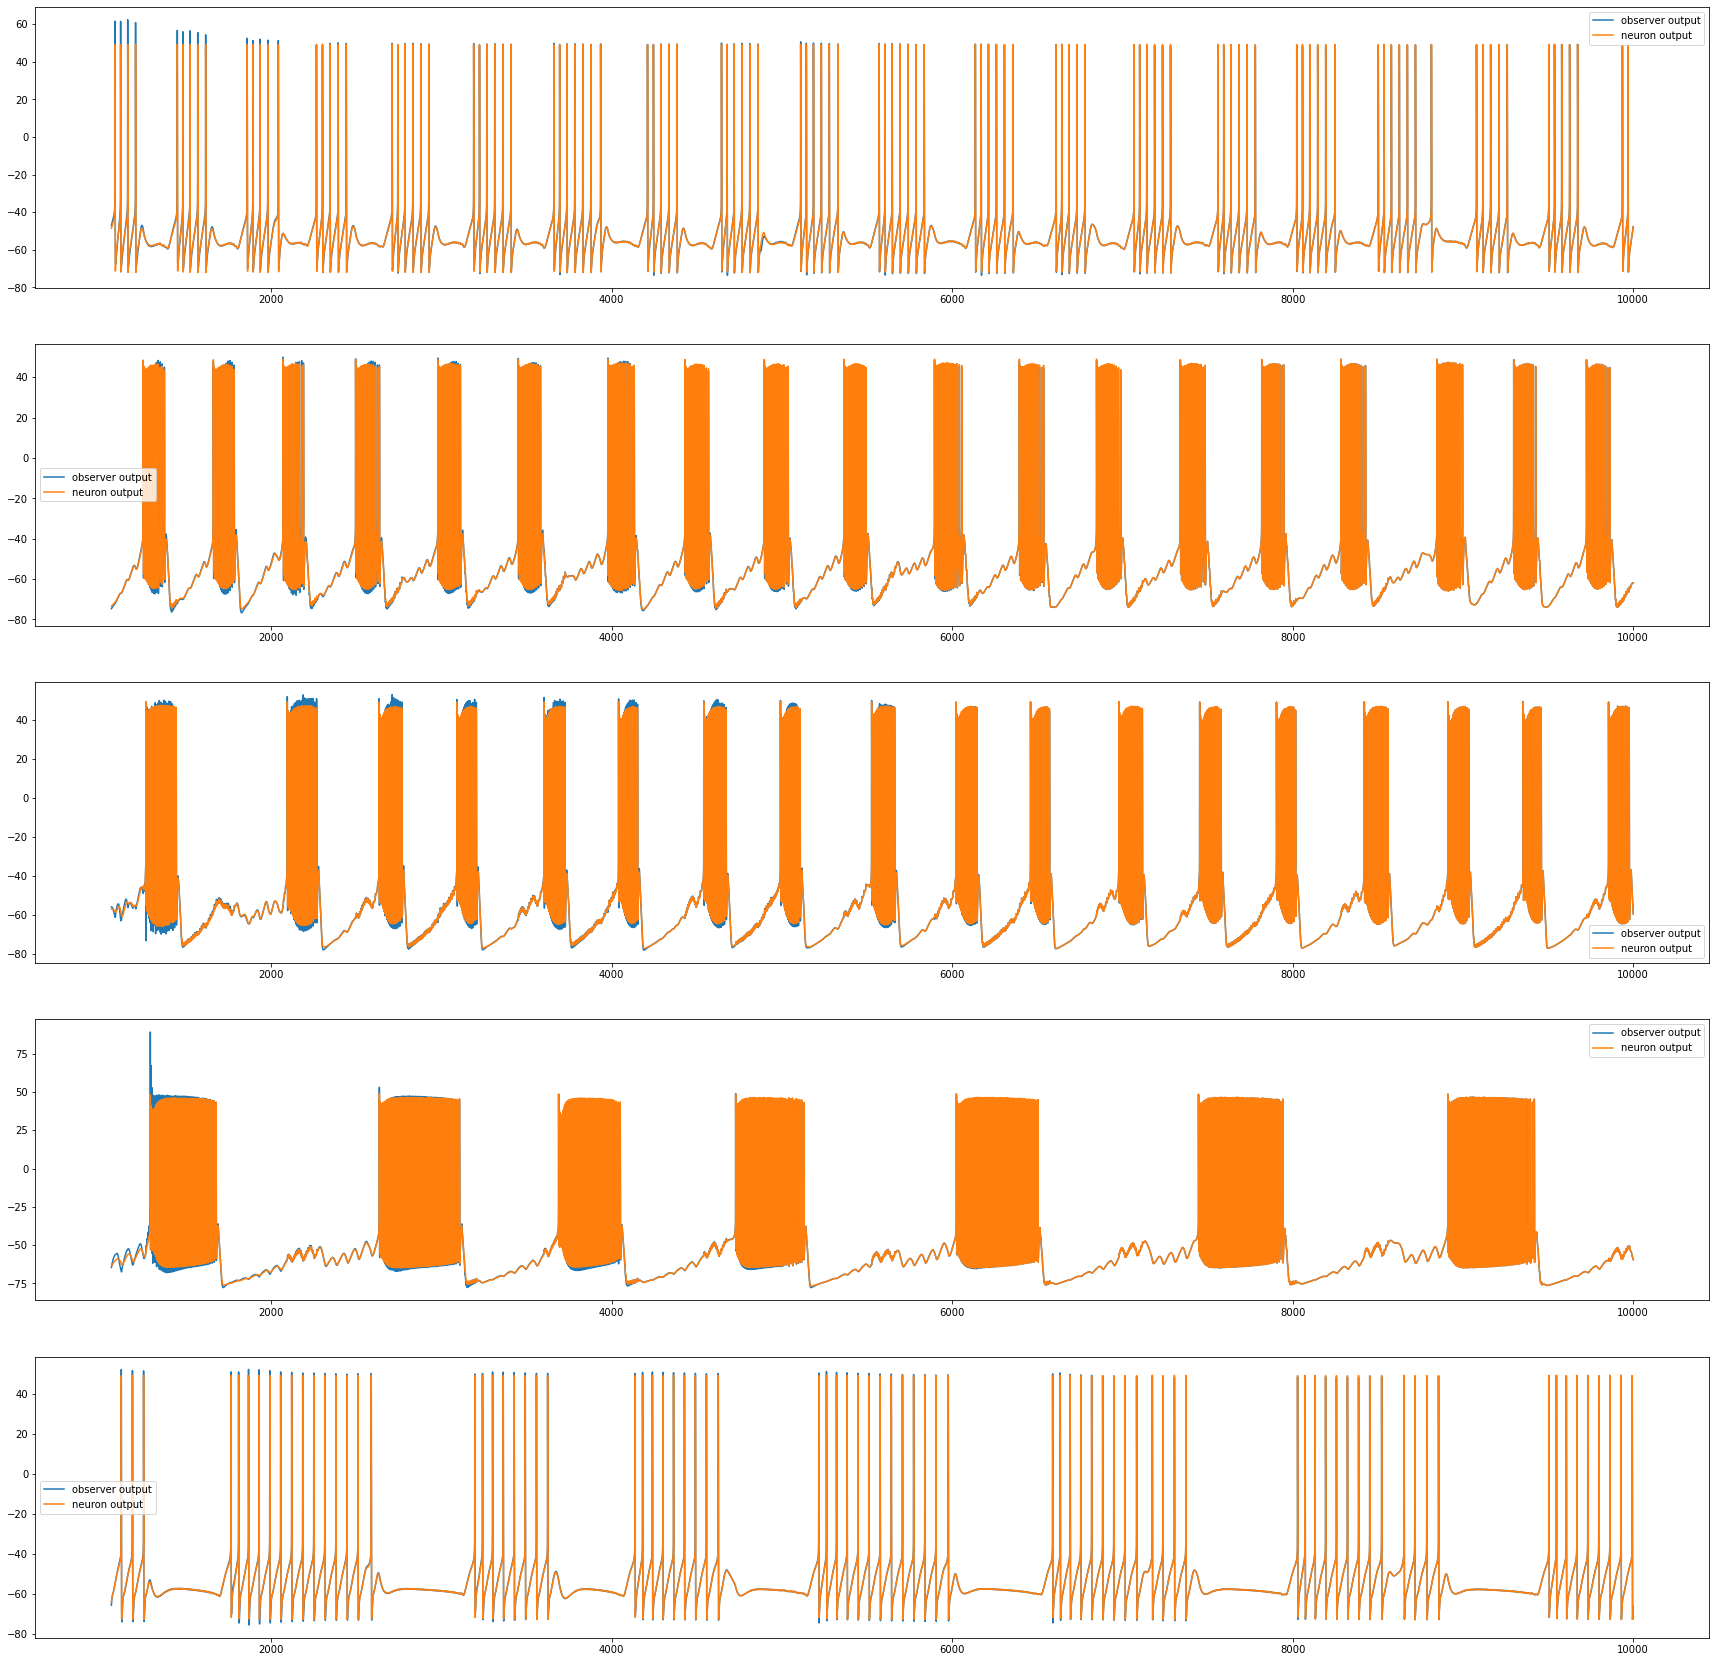

In [27]:
plot_fun(net7,sol9)

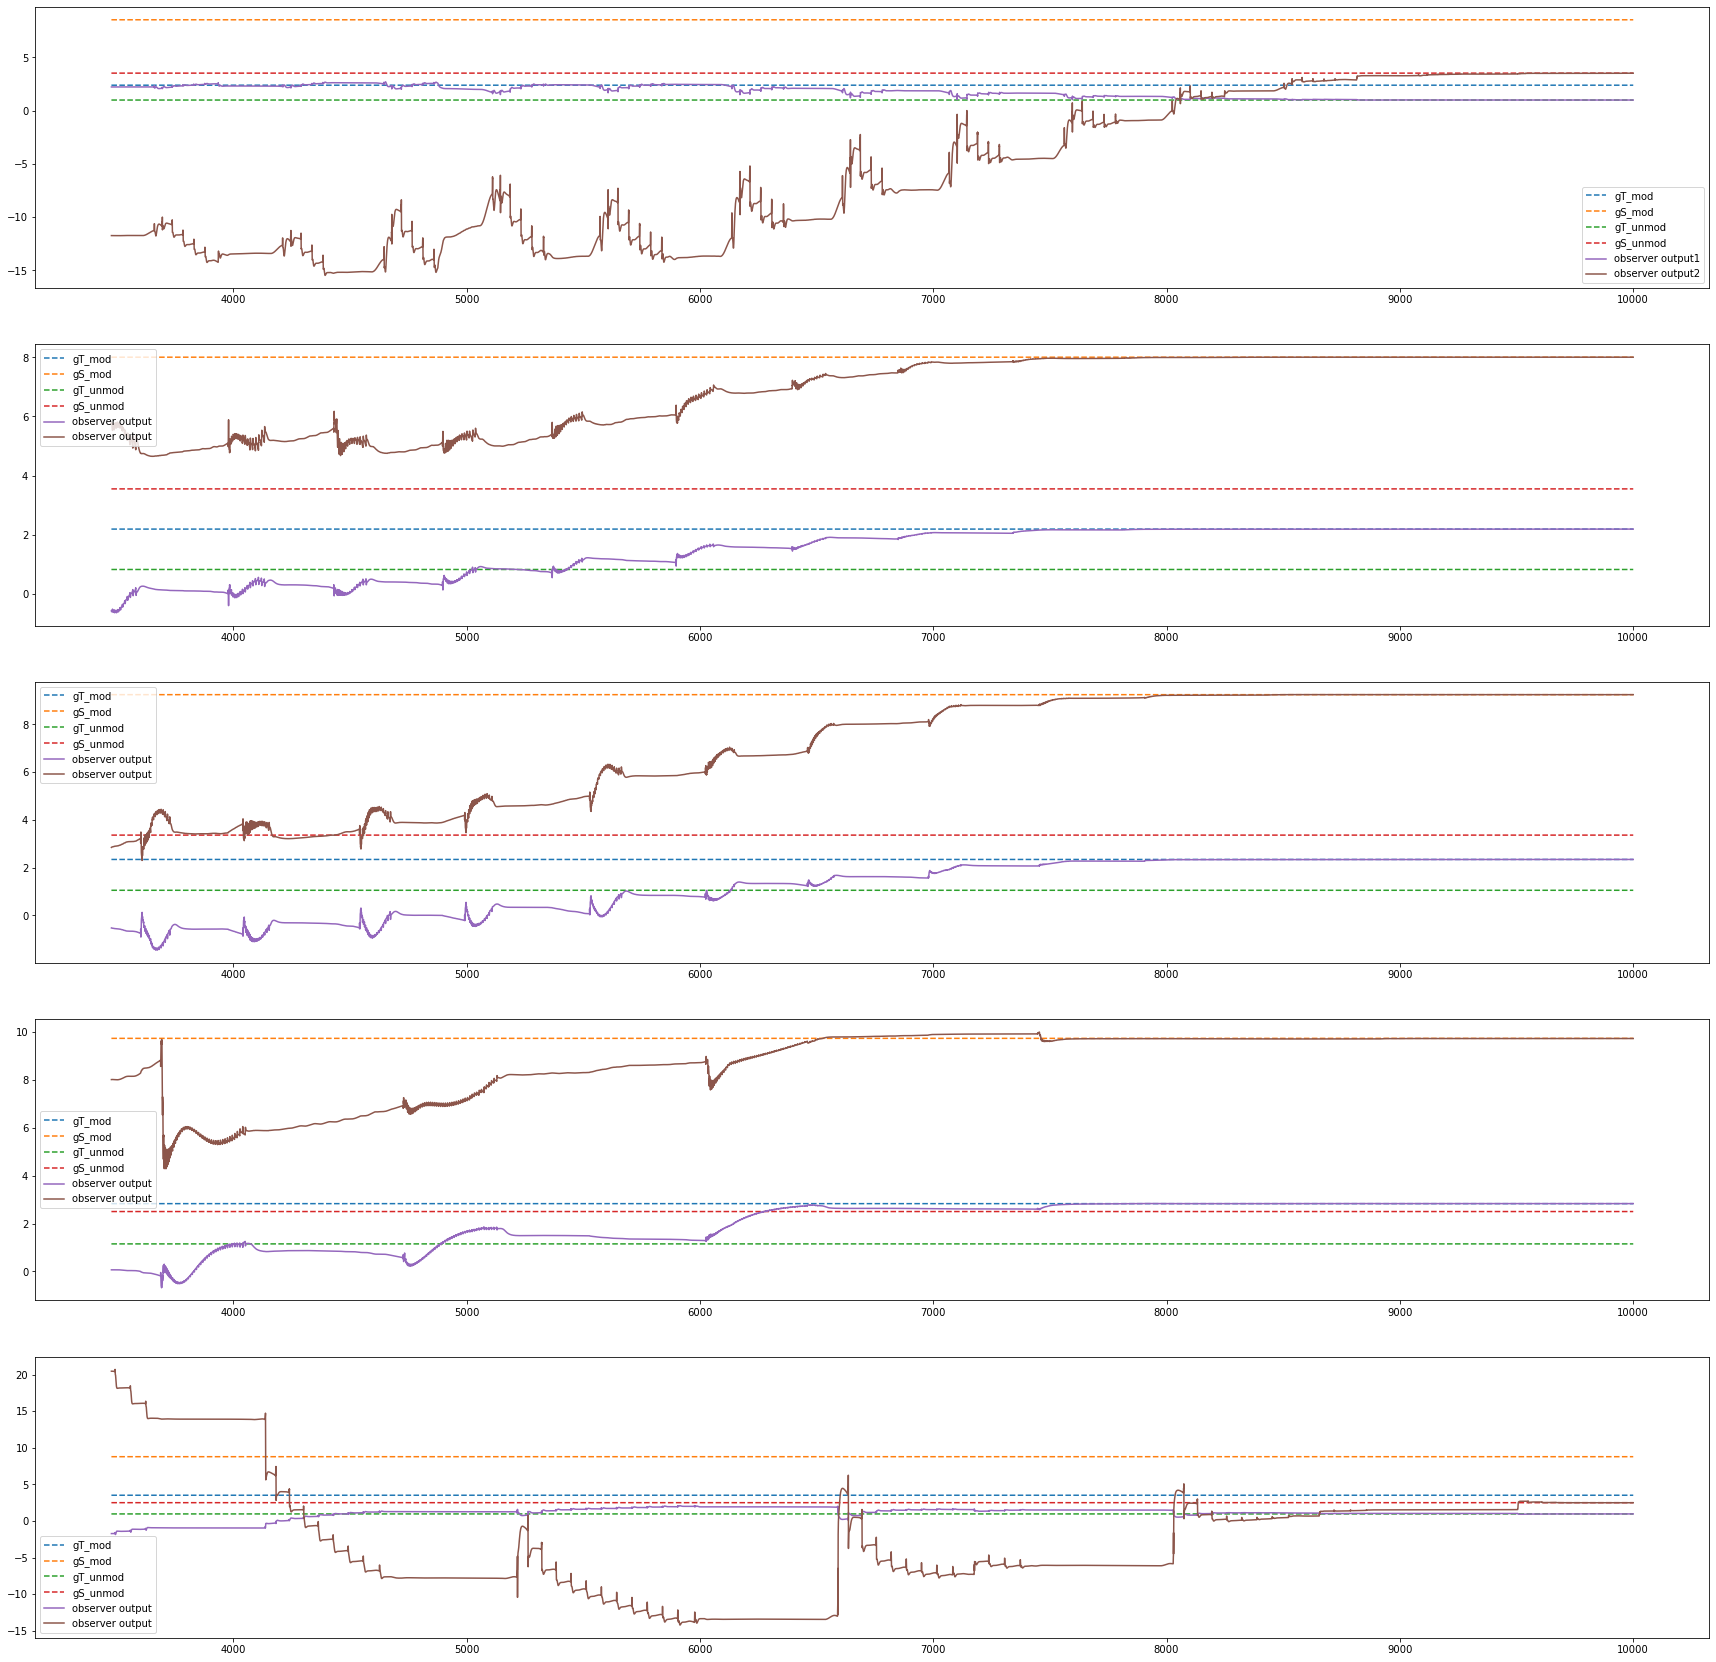

0.9933061153941964
2.1909193606762916
2.3408714493334846
2.831157484251725
0.9724732400666507


In [28]:
plot_fun2(net7,sol9)

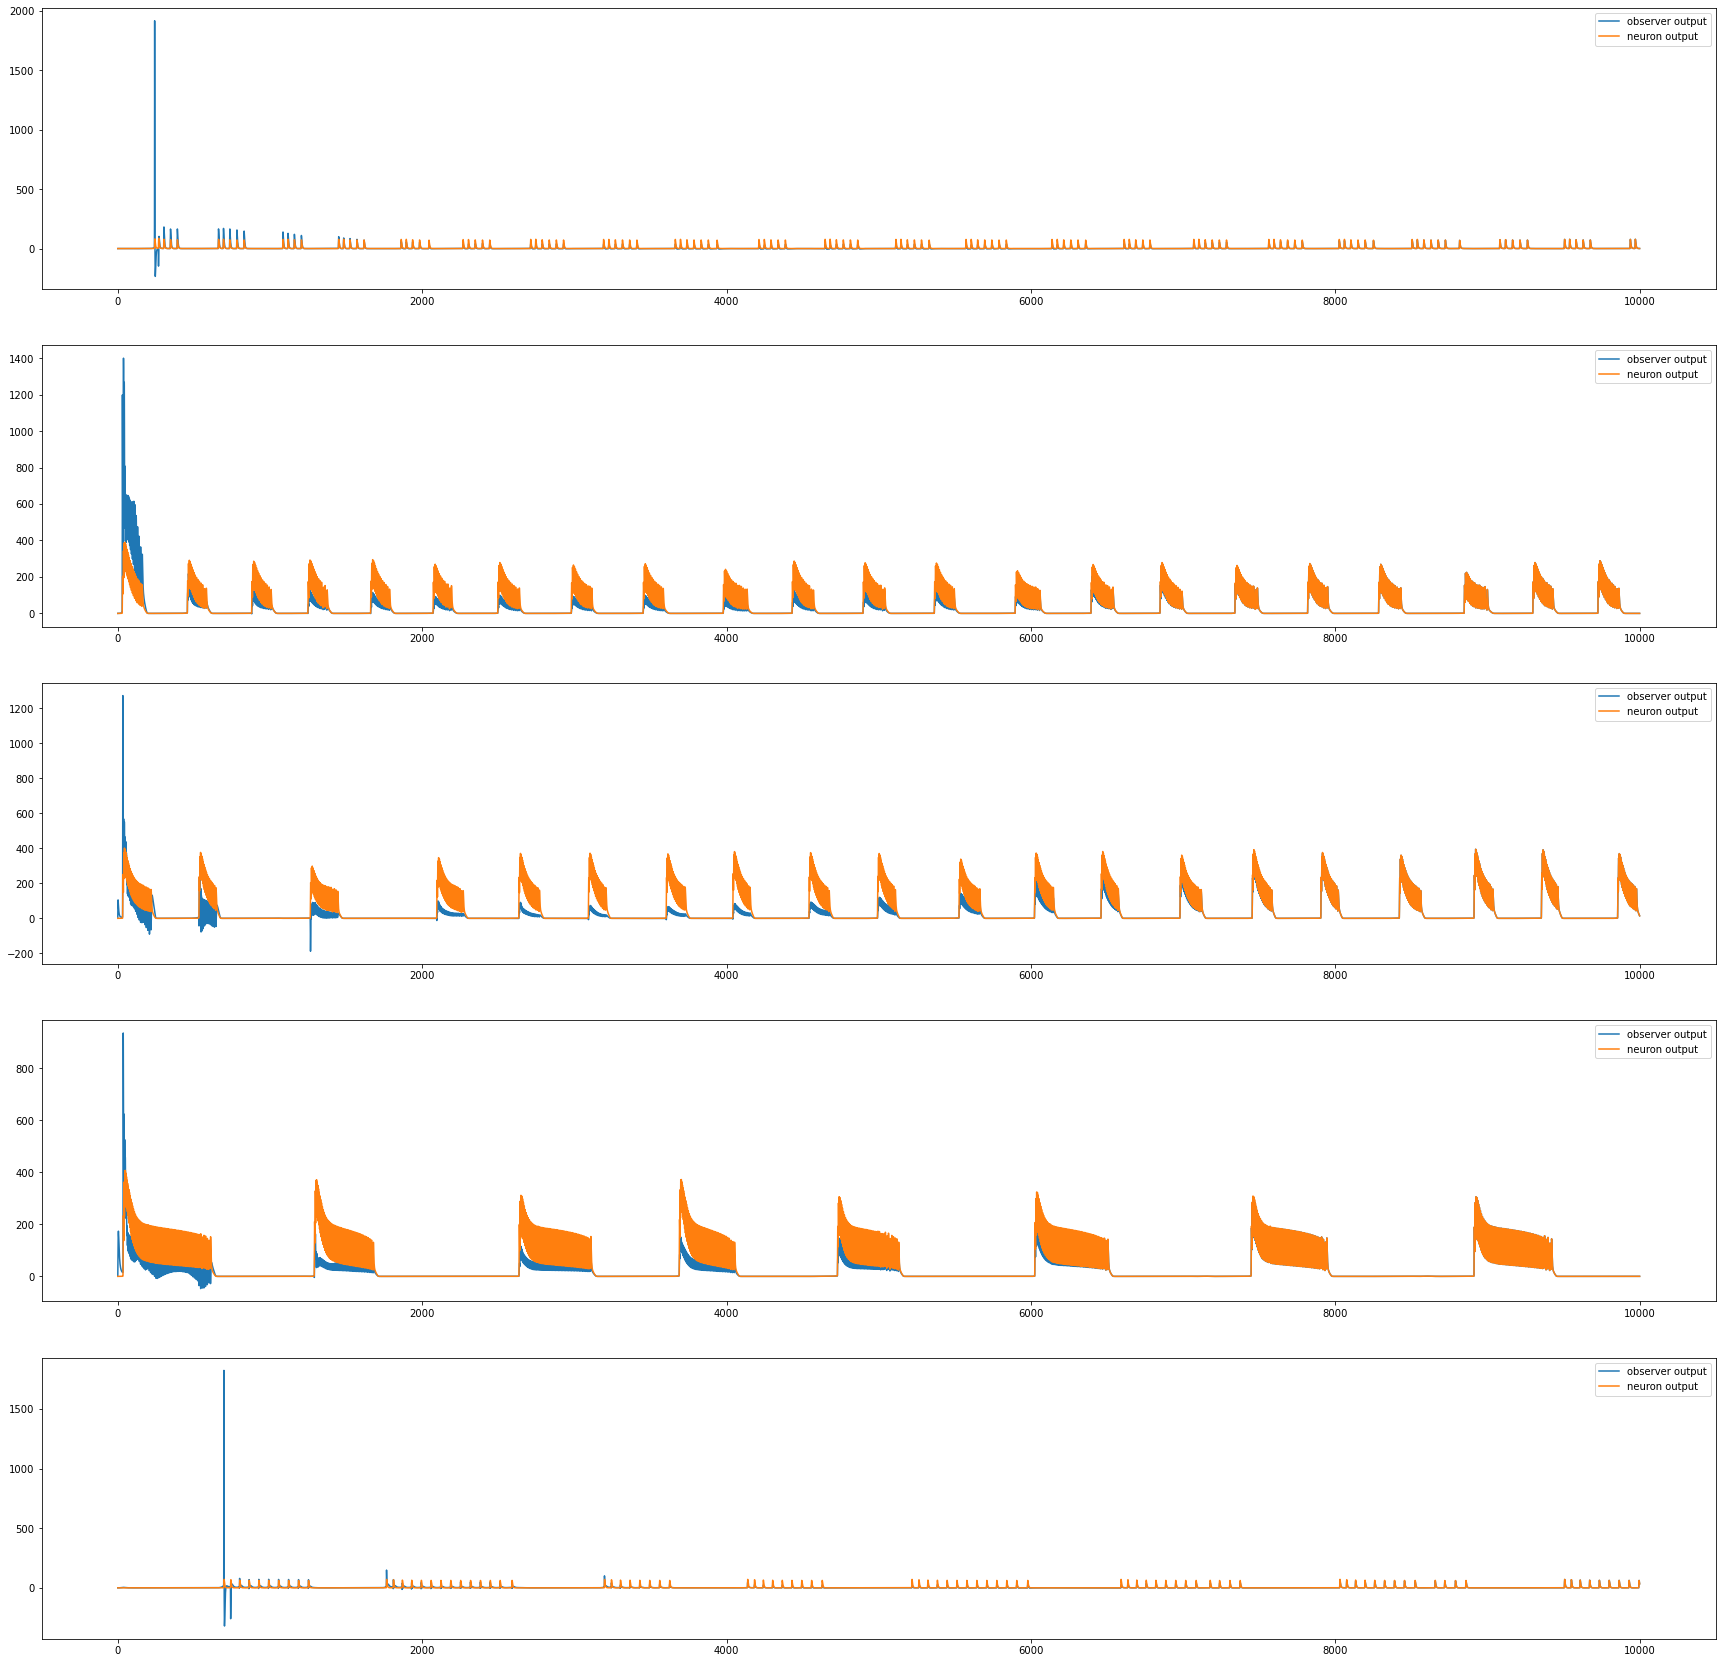

In [33]:
plot_fun1(net7,sol9)

In [43]:
net8=random_MOD_Ca([0.,1.,1.,1.,0.])
gamma=10.
alpha=0.0002
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net8.cells[0].set_hyp(gamma,alpha,variable_mask1)
net8.cells[1].set_hyp(gamma,alpha,variable_mask2)
net8.cells[2].set_hyp(gamma,alpha,variable_mask3)
net8.cells[3].set_hyp(gamma,alpha,variable_mask2)
net8.cells[4].set_hyp(gamma,alpha,variable_mask1)
#net1.set_mod(fgS,fgT)
X0=[*net8.cells[0].init_cond_OB(-60+5),*net8.cells[1].init_cond_OB(-60-5),*net8.cells[2].init_cond_OB(-61),*net8.cells[3].init_cond_OB(-60-2),*net8.cells[4].init_cond_OB(-60+1)]
## Definition of simulation time.


[1. 1. 1. 1. 1. 1.]
num_Theta 8
[1. 1. 1. 1. 1. 1.]
num_Theta 8
[1. 1. 1. 1. 1. 1.]
num_Theta 8
[1. 1. 1. 1. 1. 1.]
num_Theta 8
[1. 1. 1. 1. 1. 1.]
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9
[6.52814000e+02 1.07445000e-01 1.41965879e+01 5.15008000e+01
 1.09659000e+02 1.00000000e-02 6.30373000e+01 7.91550111e+01
 7.71695119e-02]
[-56.17998224]
[5.03580000e+02 9.29811000e-02 4.99010205e+01 5.83269000e+01
 8.41655000e+01 1.00000000e-02 5.41351000e+01 4.68040075e+01
 7.63508367e-02 2.10839169e-02]
[-54.54535703]
[6.34723000e+02 7.81820000e-02 8.17767916e+01 4.03572000e+01
 7.47833000e+01 1.00000000e-02 6.57822000e+01 7.15848384e+01
 7.98892228e-02 8.83547232e-02 2.10839169e-02 2.28748603e-02]
[-26.21174202]
[4.59807000e+02 8.34140000e-02 3.84173903e+01 5.85102000e+01
 9.11938000e+01 1.00000000e-02 5.59324000e+01 3.26071736e+01
 1.17123333e-01 2.28748603e-02]
[-79.74821957]
[6.16433000e+02 8.8734300

In [44]:
Tfinal=10000.0
tspan=[0.0,Tfinal]
start = time.time()
sol10=solve_ivp(net8.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

Elapsed (with compilation) = 180.7002341747284


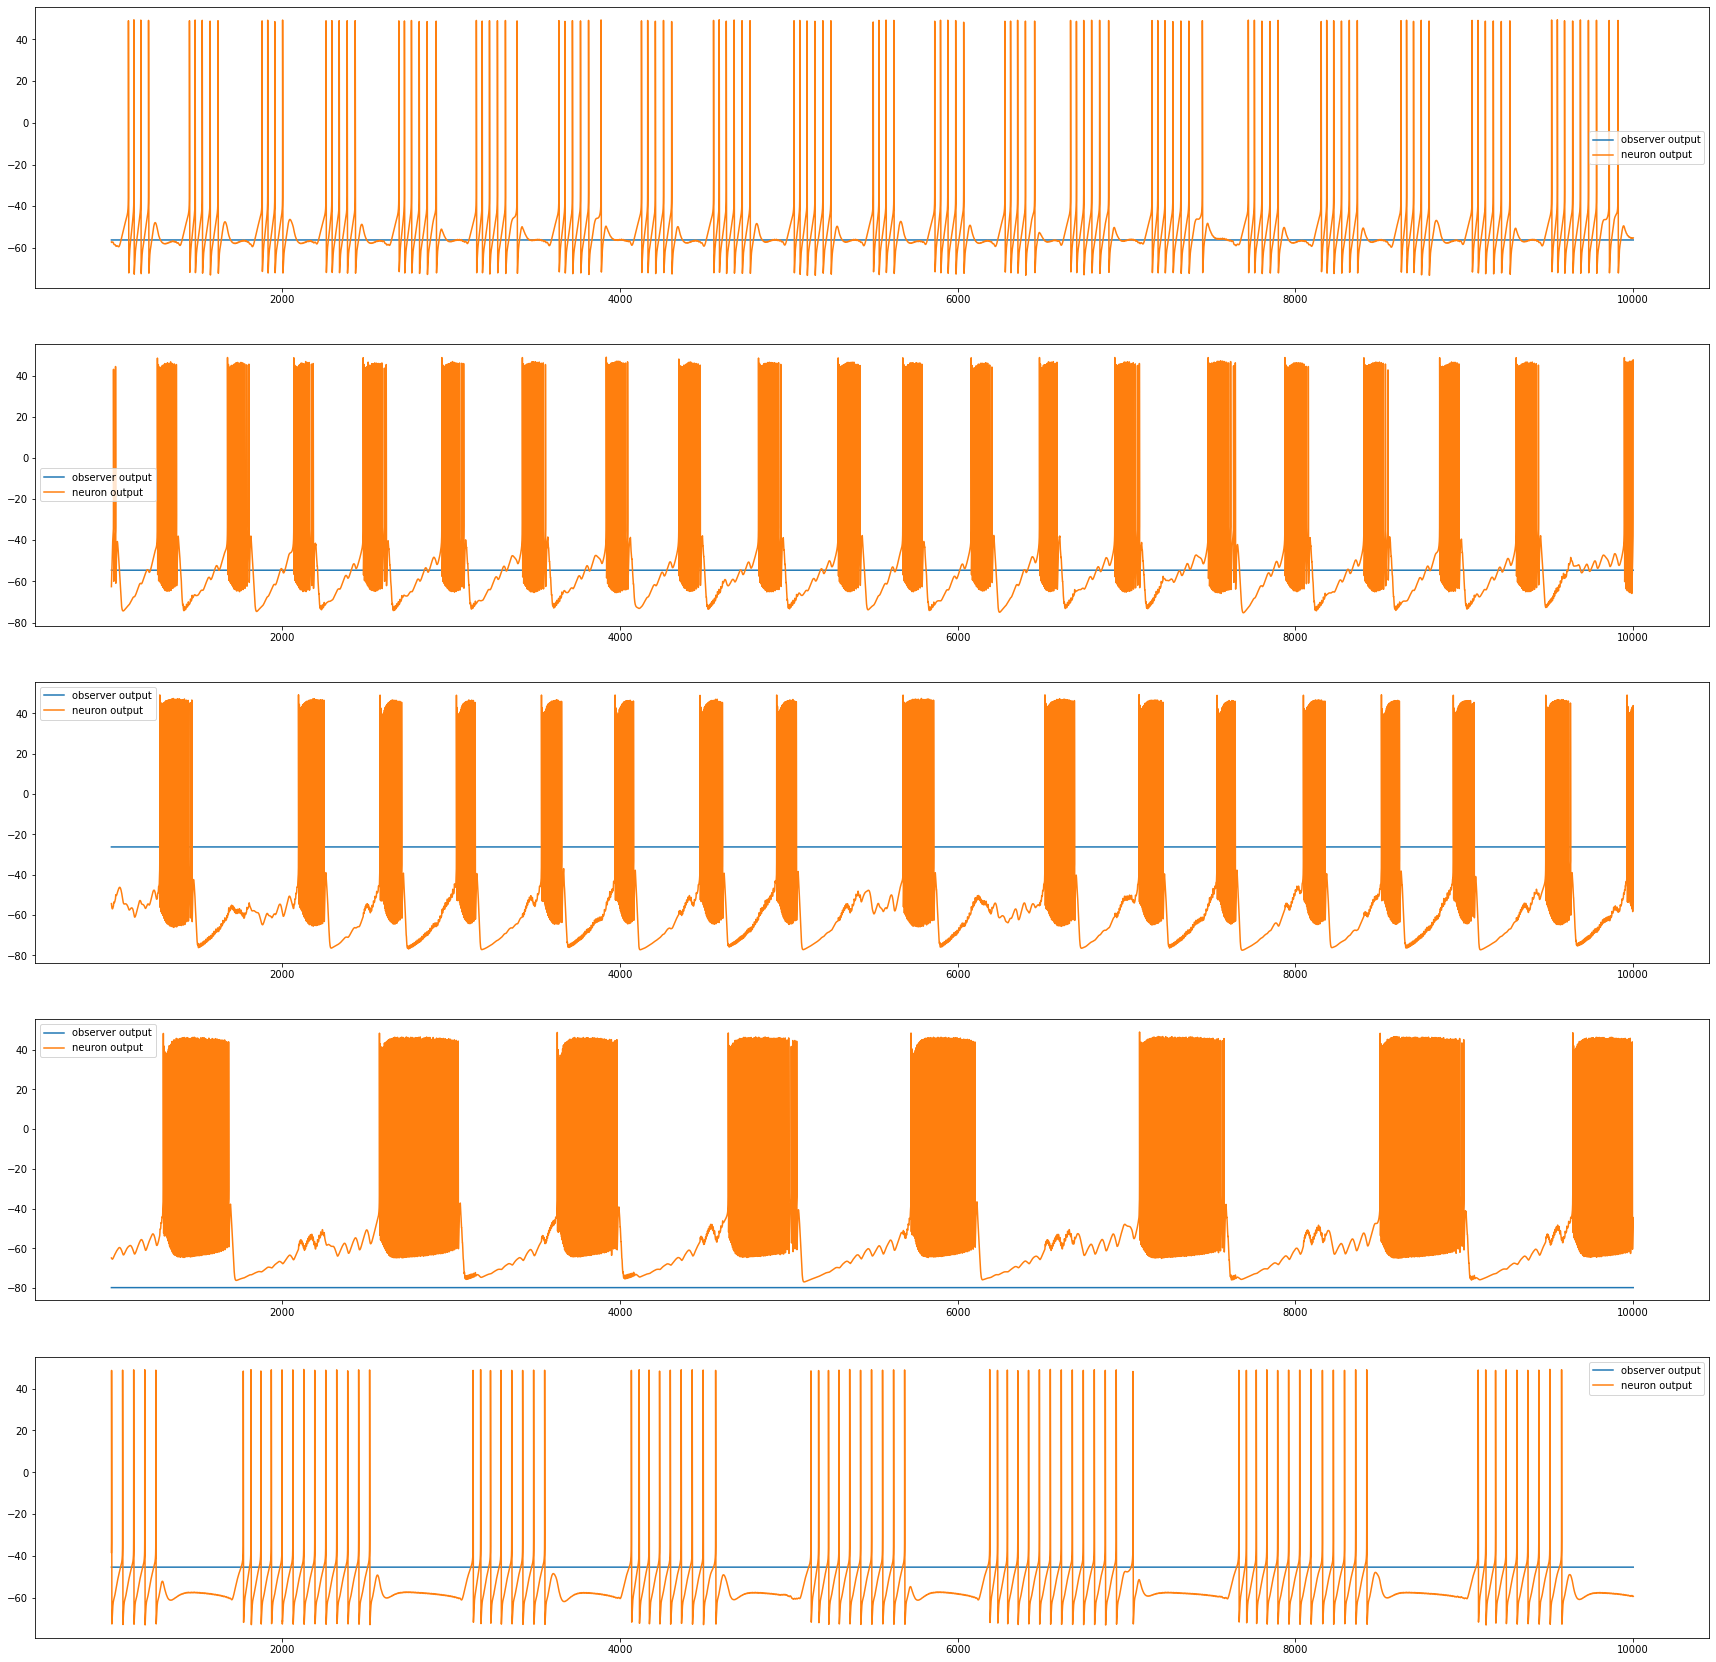

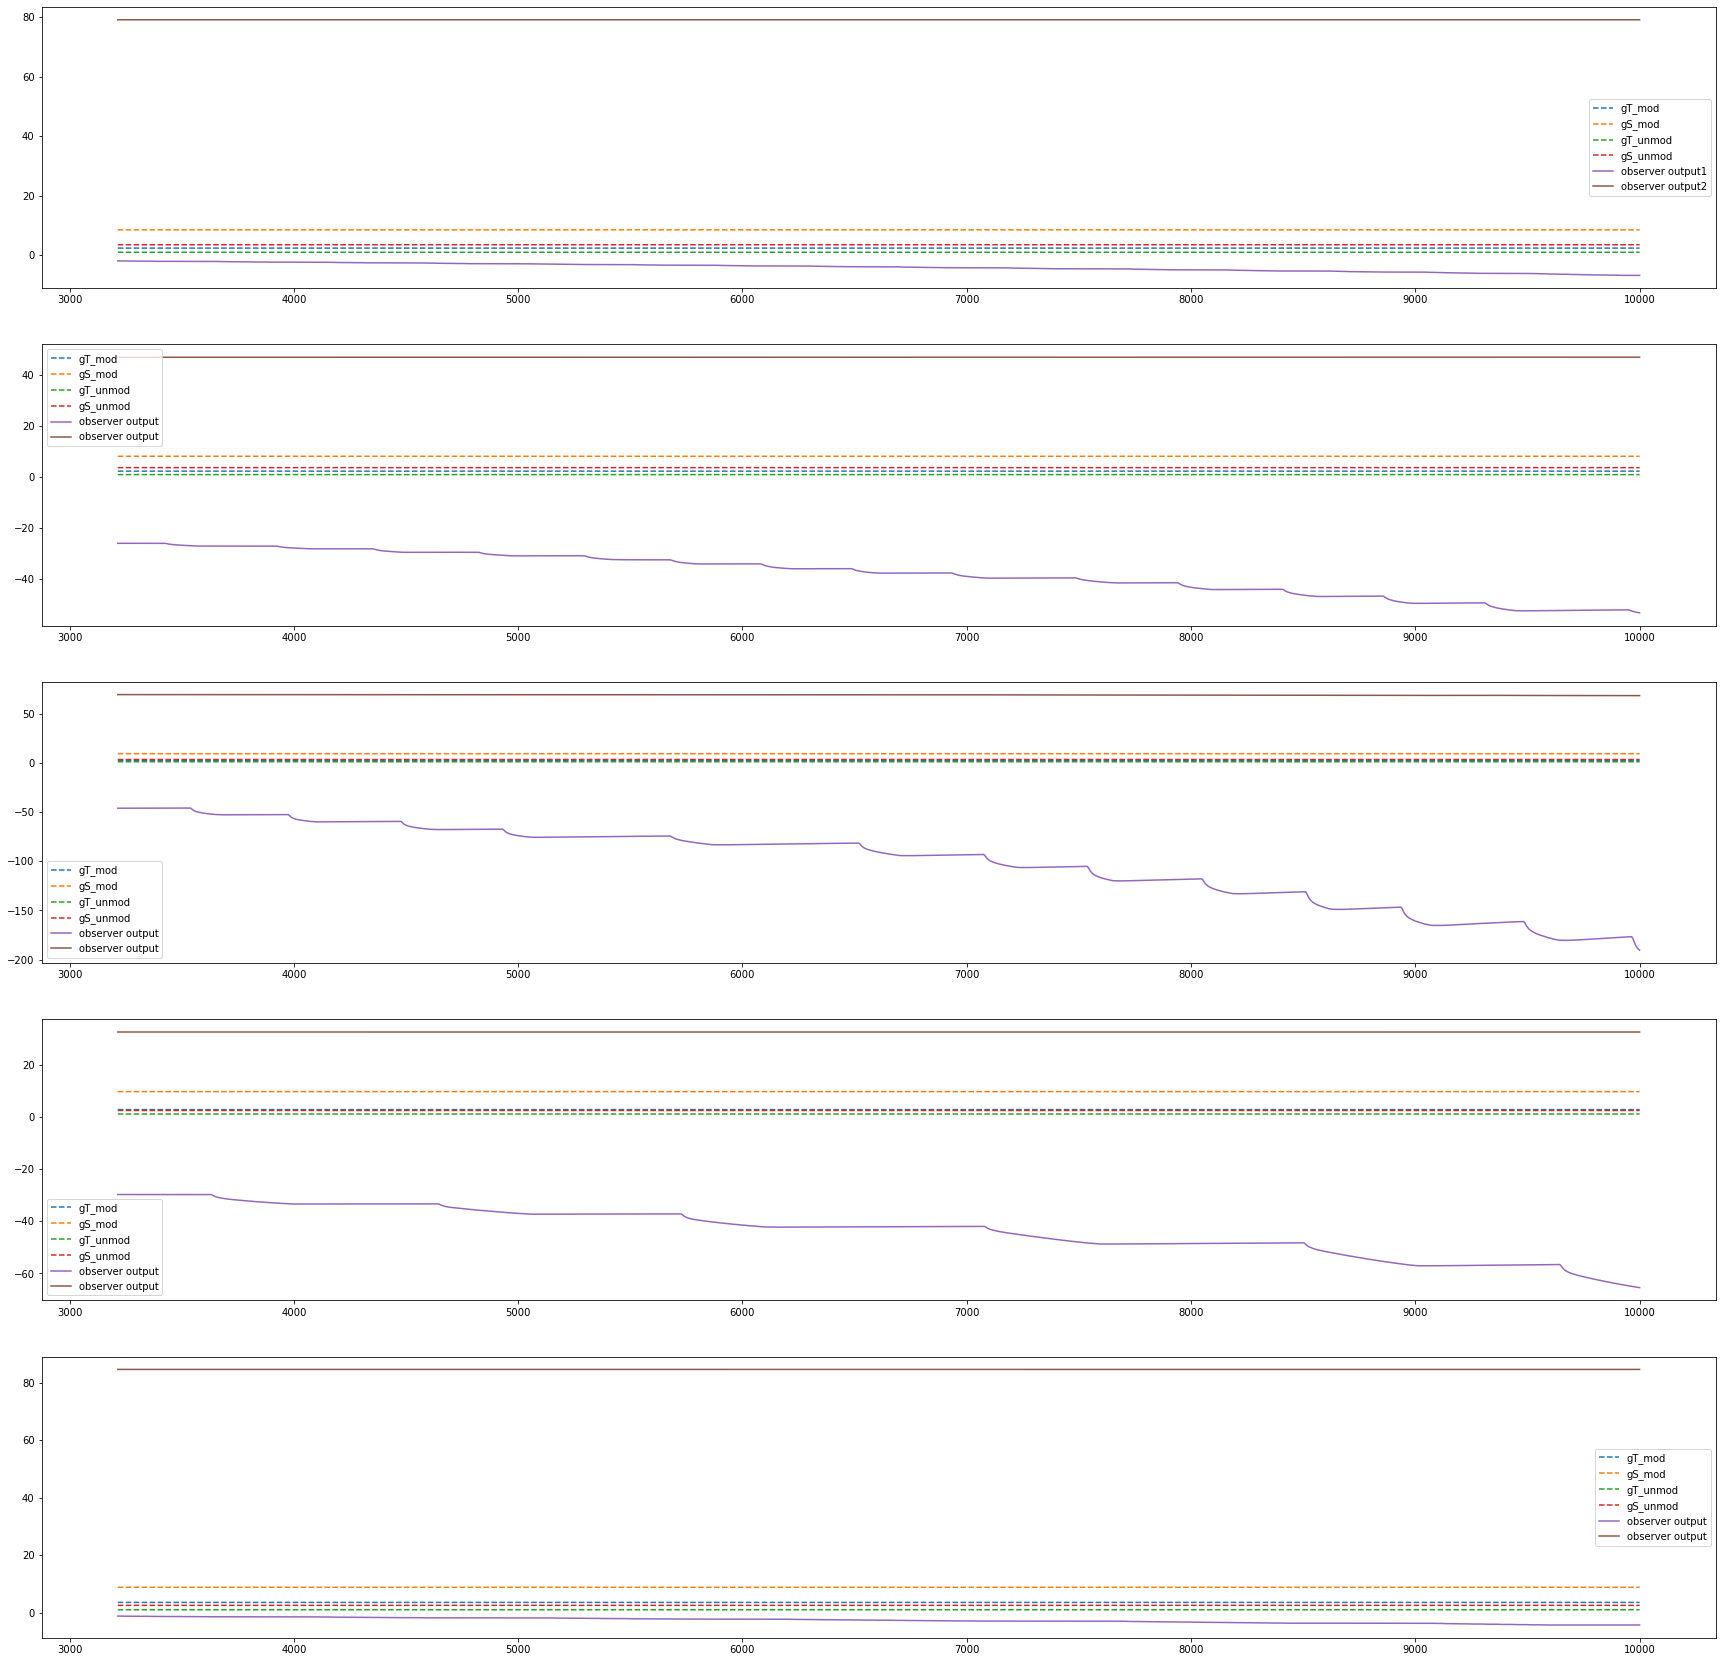

-6.789404590657868
-53.253962971047386
-190.52841143816934
-65.4465253527932
-4.329555881108726


In [45]:
plot_fun(net8,sol10)
plot_fun2(net8,sol10)

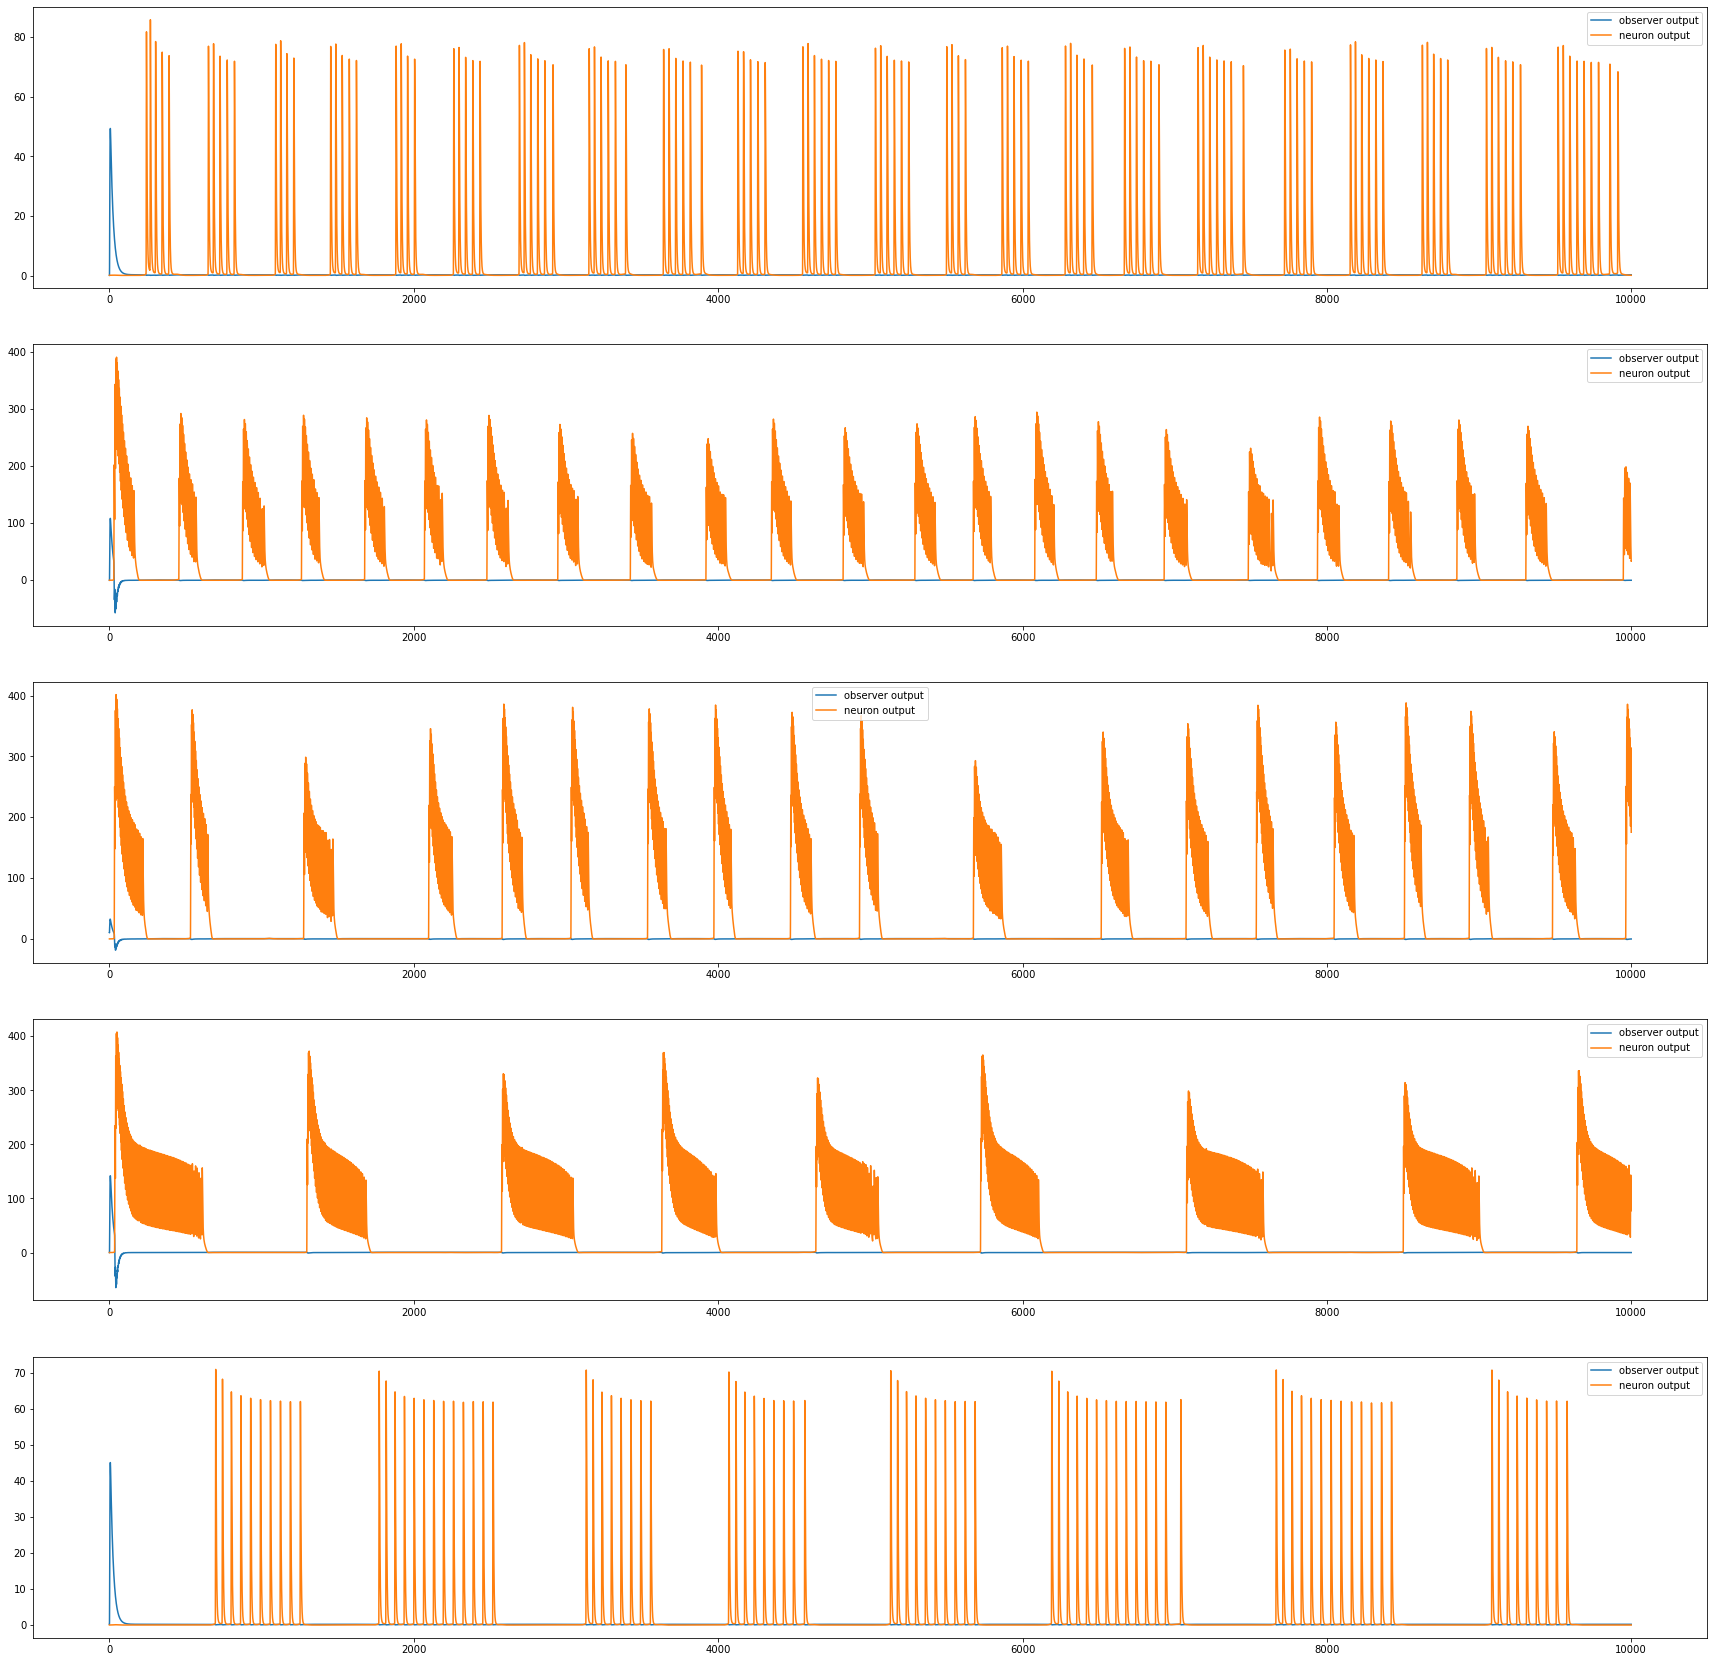

In [46]:
plot_fun1(net8,sol10)

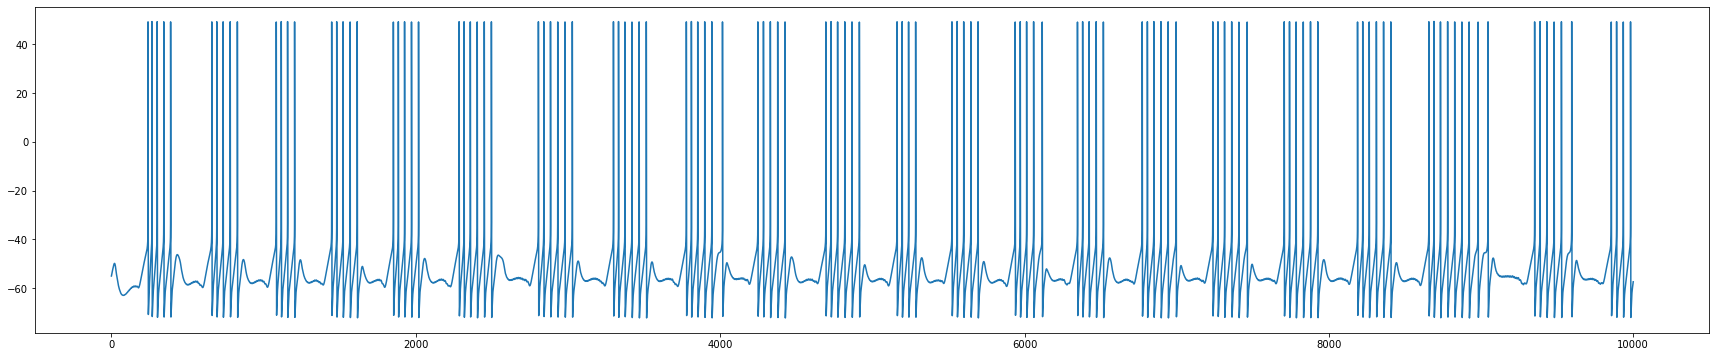

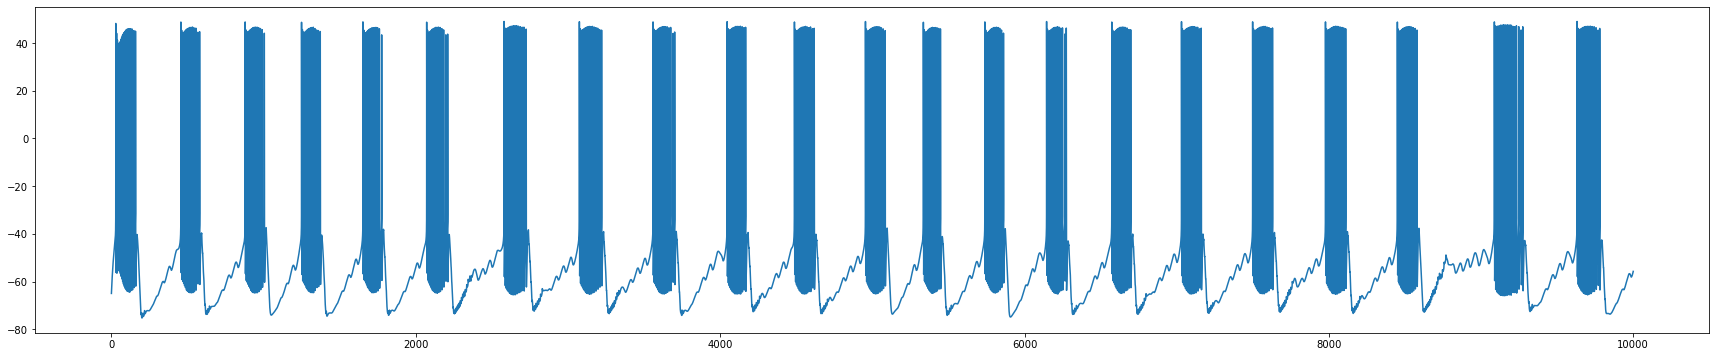

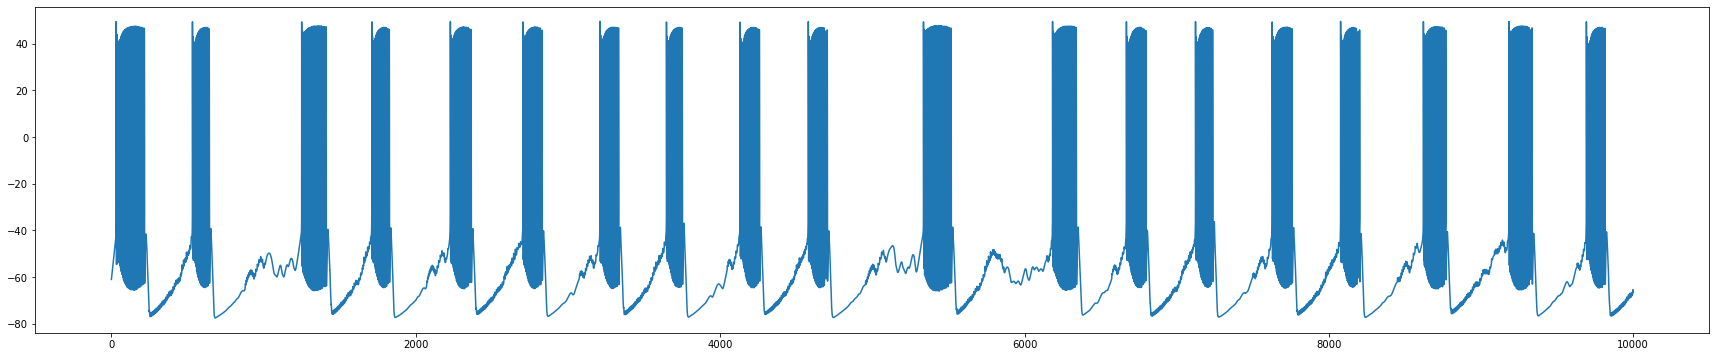

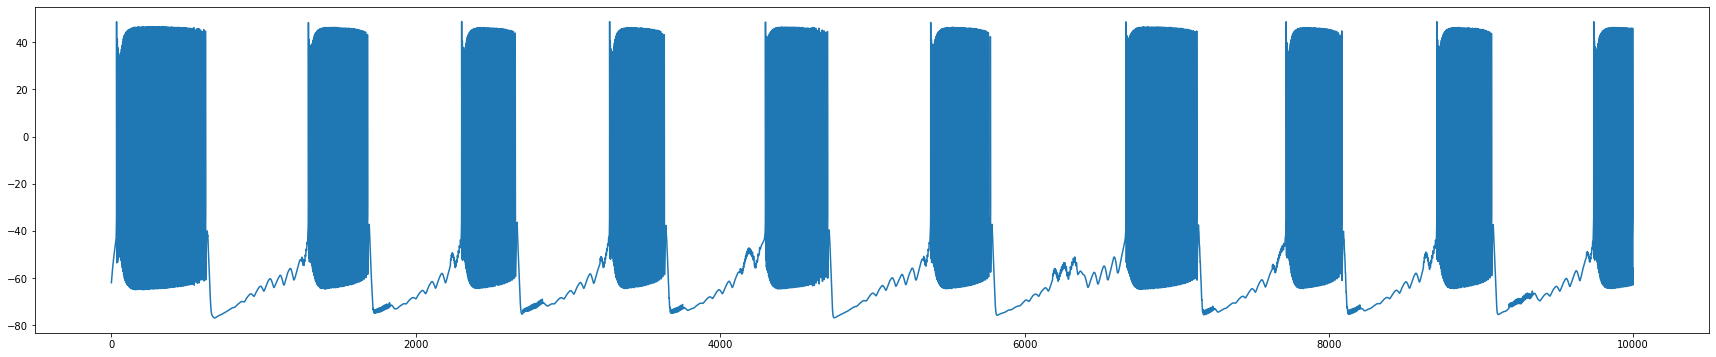

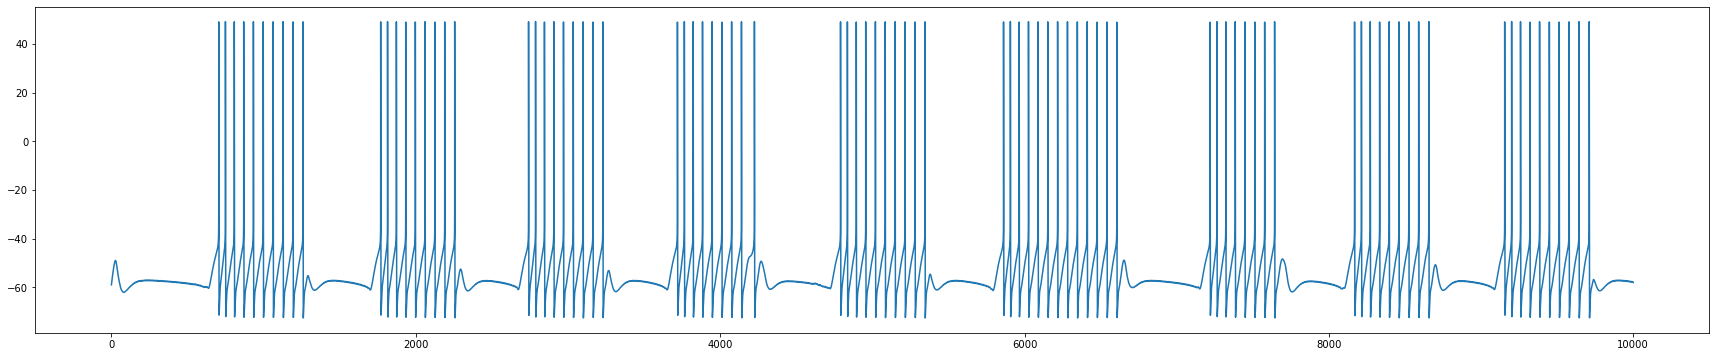

In [10]:
fig=plt.figure(figsize=(30, 6))
plt.plot(sol9.t, sol9.y[0])


fig=plt.figure(figsize=(30, 6))
plt.plot(sol9.t, sol9.y[net7.cells[0].pos_dinamics])



fig=plt.figure(figsize=(30, 6))
plt.plot(sol9.t, sol9.y[net7.cells[0].pos_dinamics+net7.cells[1].pos_dinamics])



fig=plt.figure(figsize=(30, 6))
plt.plot(sol9.t, sol9.y[net7.cells[0].pos_dinamics+net7.cells[1].pos_dinamics+net7.cells[2].pos_dinamics])



fig=plt.figure(figsize=(30, 6))
plt.plot(sol9.t, sol9.y[net7.cells[0].pos_dinamics+net7.cells[1].pos_dinamics+net7.cells[2].pos_dinamics+net7.cells[3].pos_dinamics])



In [48]:
net1=random_MOD([0.,1.,1.,1.,0.])
net1.set_mod(fgS,fgT)
X0=[*net1.cells[0].init_cond(-60+5),*net1.cells[1].init_cond(-60-5),*net1.cells[2].init_cond(-61),*net1.cells[3].init_cond(-60-2),*net1.cells[4].init_cond(-60+1)]
## Definition of simulation time.
Tfinal=24000.0
tspan=[0.0,Tfinal]
start = time.time()
sol=solve_ivp(net1.sys_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9
Elapsed (with compilation) = 235.7353801727295


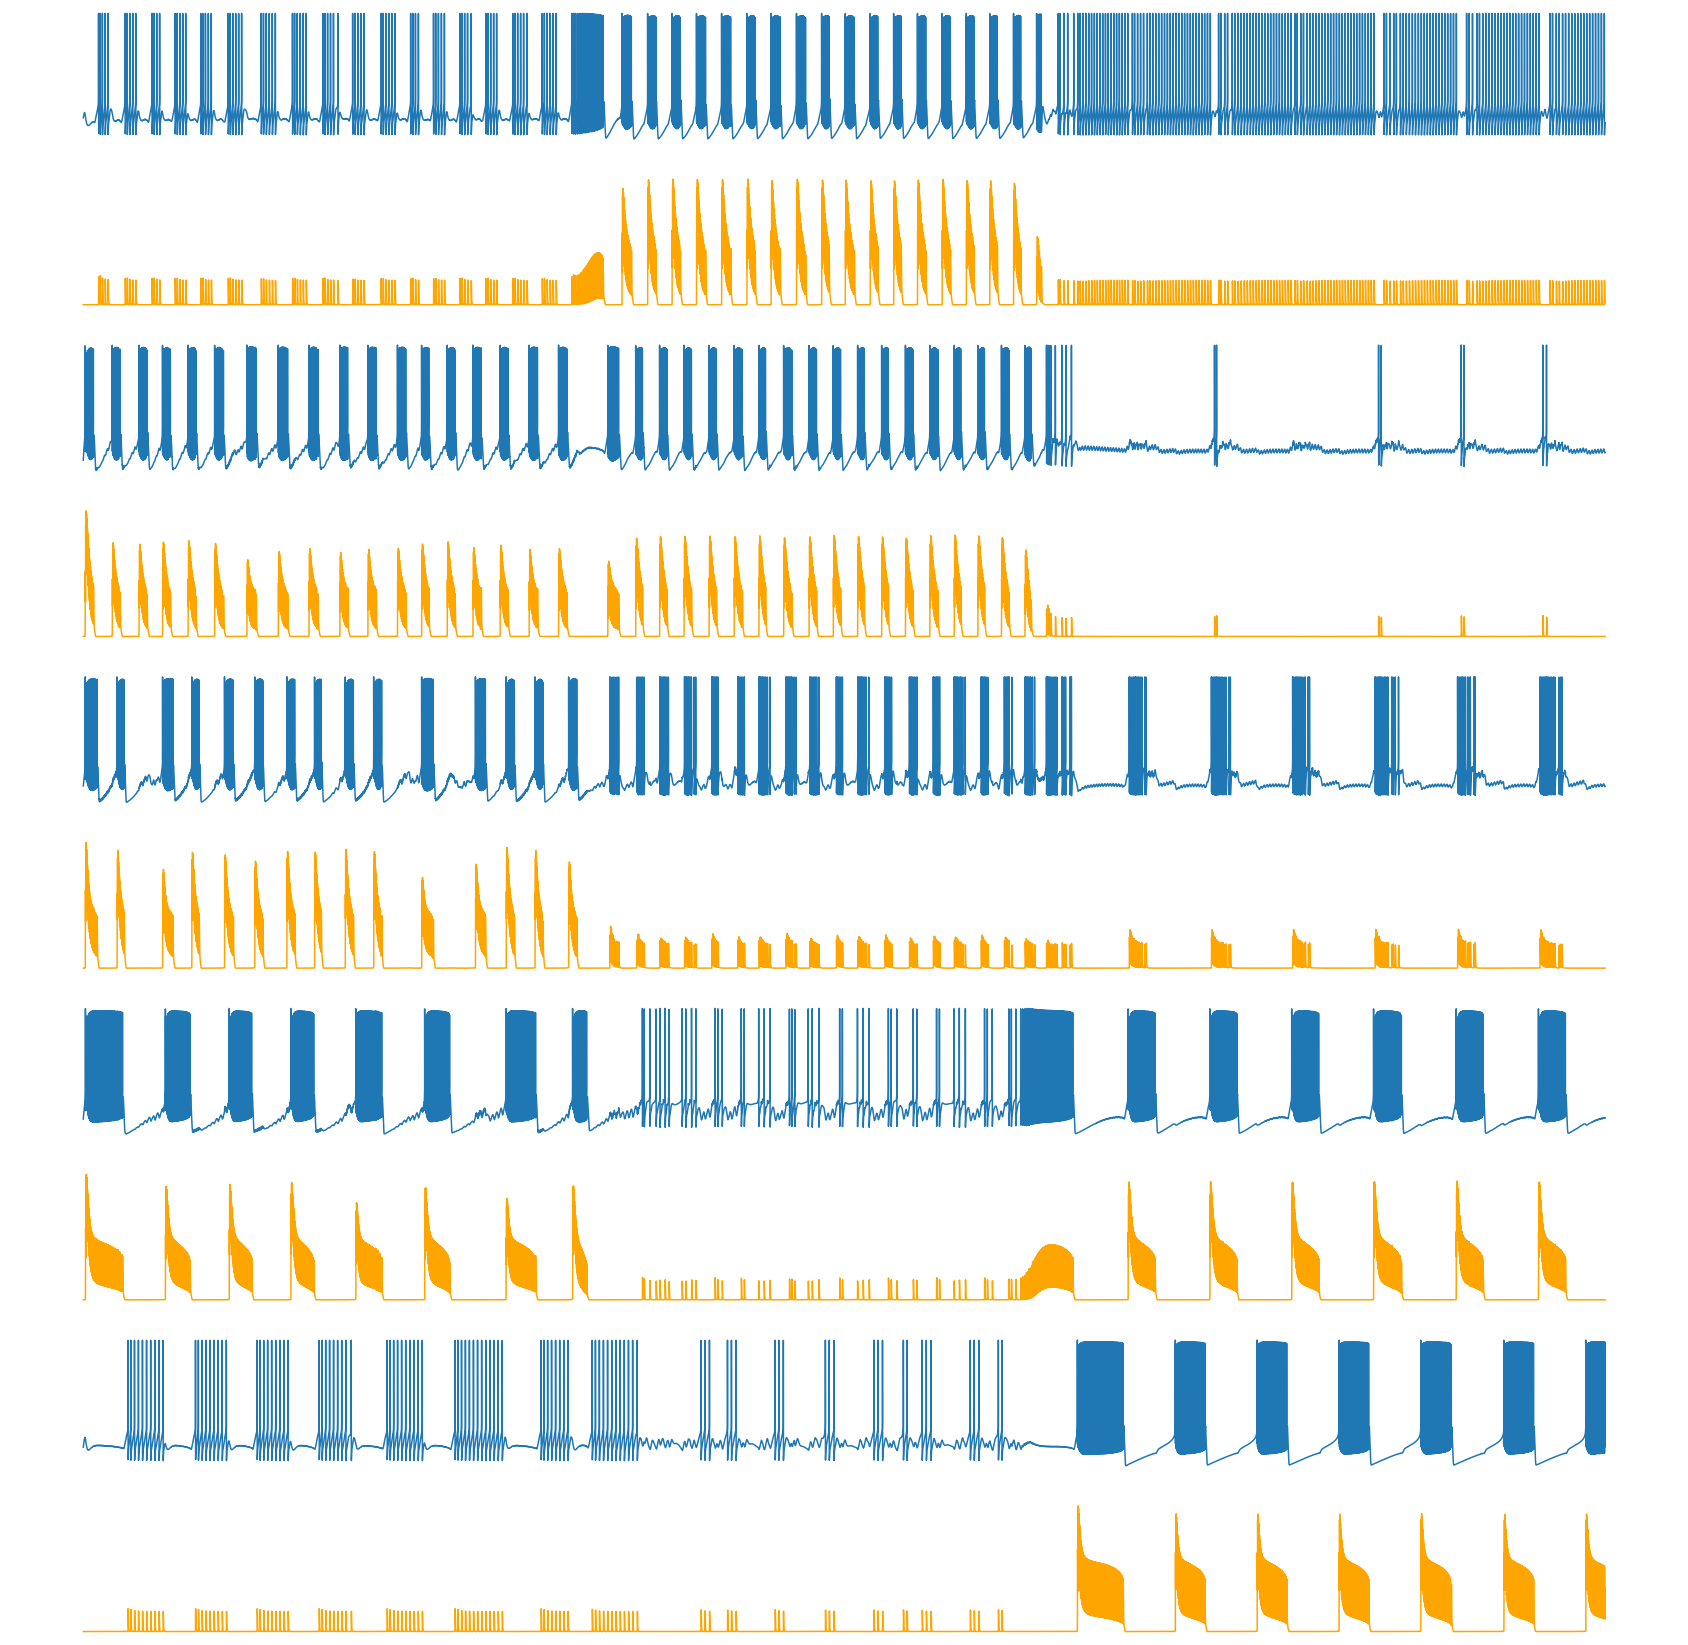

In [52]:
fig=plt.figure(figsize=(30, 30))
plt.subplot(10, 1, 1)
plt.plot(sol.t, sol.y[0])
plt.axis('off')

plt.subplot(10, 1, 2)
plt.plot(sol.t, sol.y[12],'orange')
plt.axis('off')

plt.subplot(10, 1, 3)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics])
plt.axis('off')

plt.subplot(10, 1, 4)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+12],'orange')
plt.axis('off')

plt.subplot(10, 1, 5)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics])
plt.axis('off')

plt.subplot(10, 1, 6)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+12],'orange')
plt.axis('off')

plt.subplot(10, 1, 7)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics])
plt.axis('off')

plt.subplot(10, 1, 8)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics+12],'orange')
plt.axis('off')

plt.subplot(10, 1, 9)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics+net1.cells[3].pos_dinamics])
plt.axis('off')

plt.subplot(10, 1, 10)
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics+net1.cells[3].pos_dinamics+12],'orange')
plt.axis('off')
fig.savefig('Ca_con.jpg')

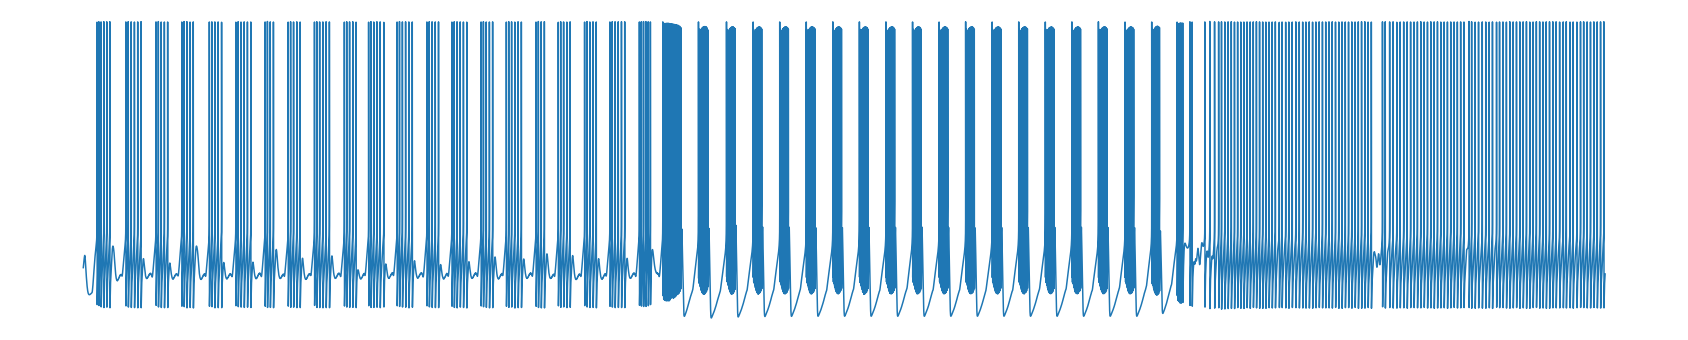

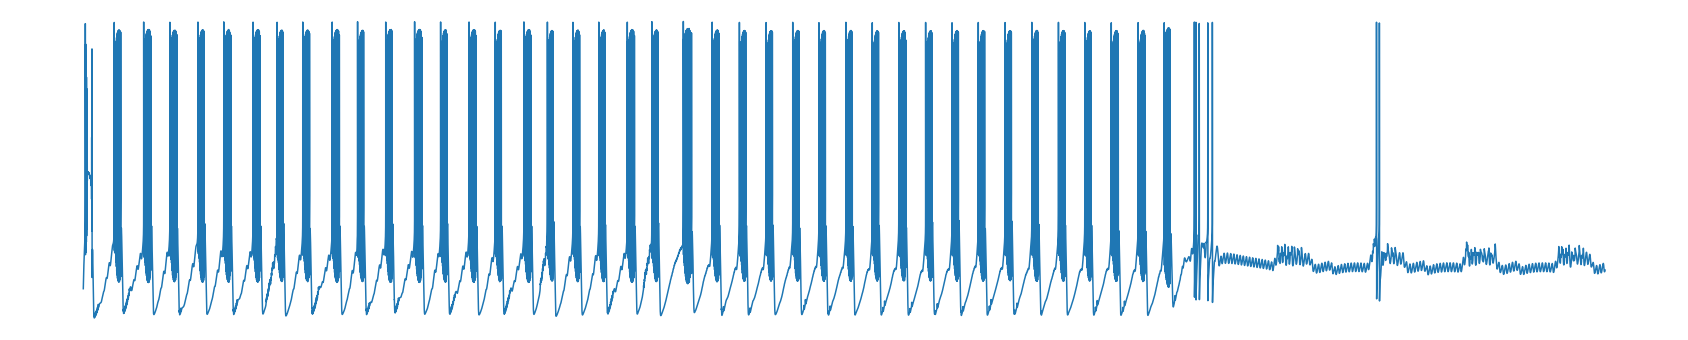

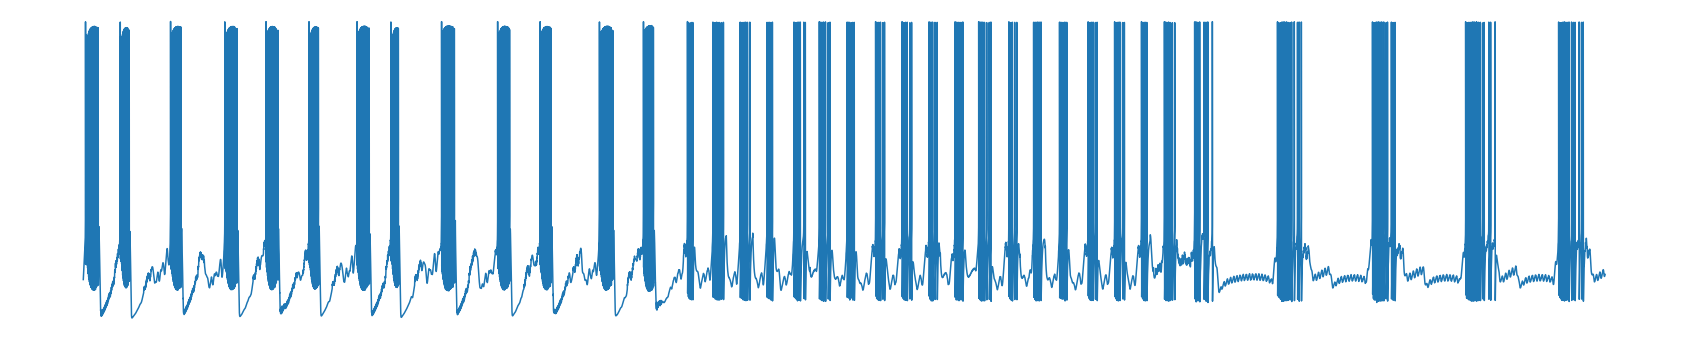

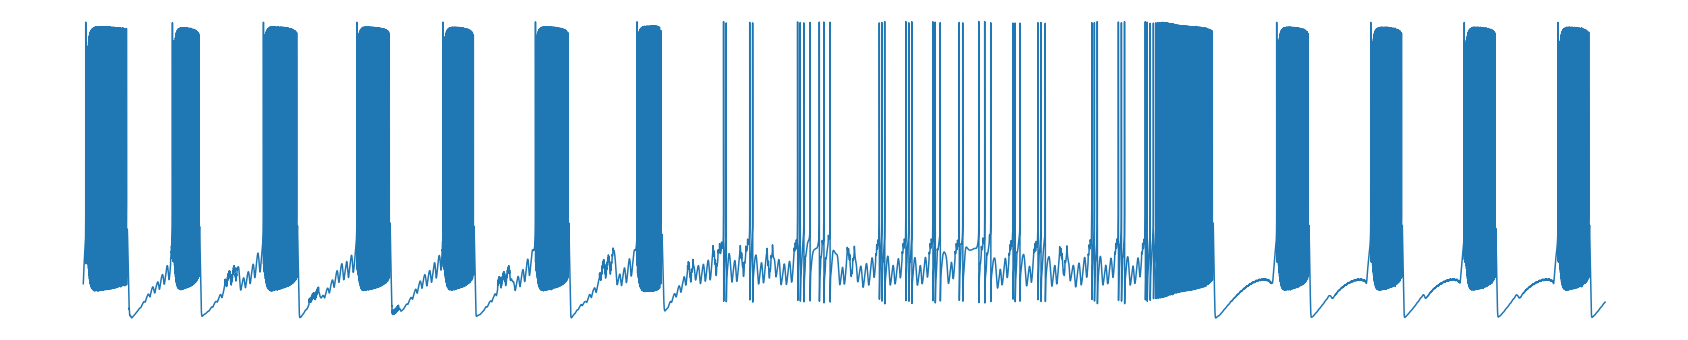

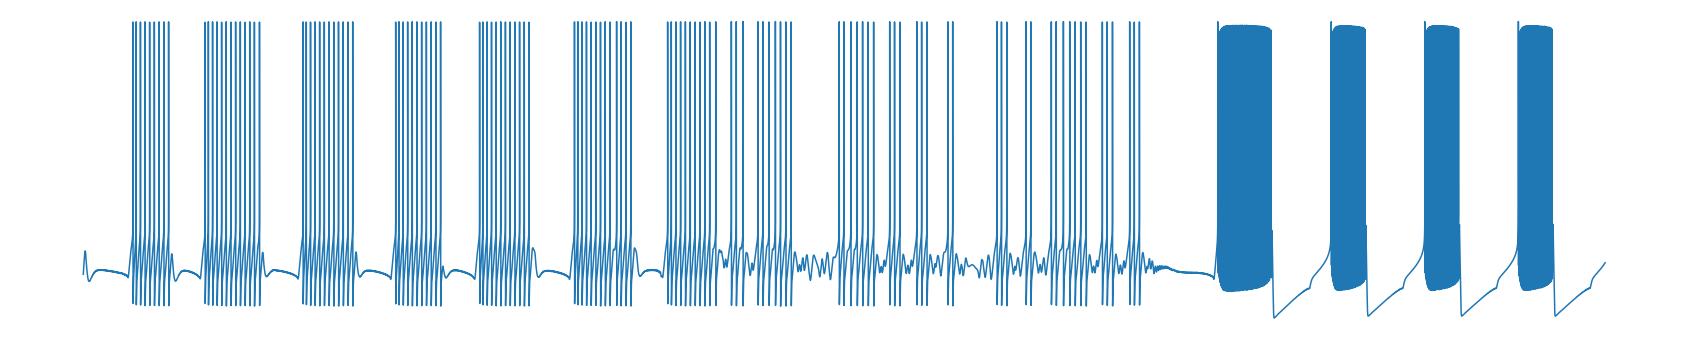

In [299]:
fig=plt.figure(figsize=(30, 6))
plt.plot(sol.t, sol.y[0])
plt.axis('off')
fig.savefig('STG1.jpg')

fig=plt.figure(figsize=(30, 6))
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics])
plt.axis('off')
fig.savefig('STG2.jpg')

fig=plt.figure(figsize=(30, 6))
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics])
plt.axis('off')
fig.savefig('STG3.jpg')

fig=plt.figure(figsize=(30, 6))
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics])
plt.axis('off')
fig.savefig('STG4.jpg')

fig=plt.figure(figsize=(30, 6))
plt.plot(sol.t, sol.y[net1.cells[0].pos_dinamics+net1.cells[1].pos_dinamics+net1.cells[2].pos_dinamics+net1.cells[3].pos_dinamics])
plt.axis('off')
fig.savefig('STG5.jpg')


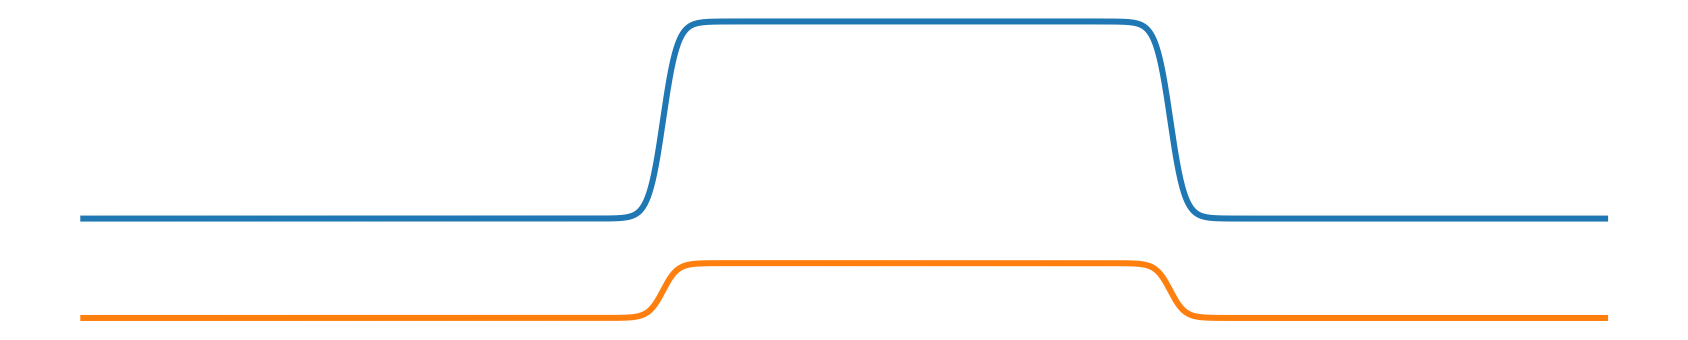

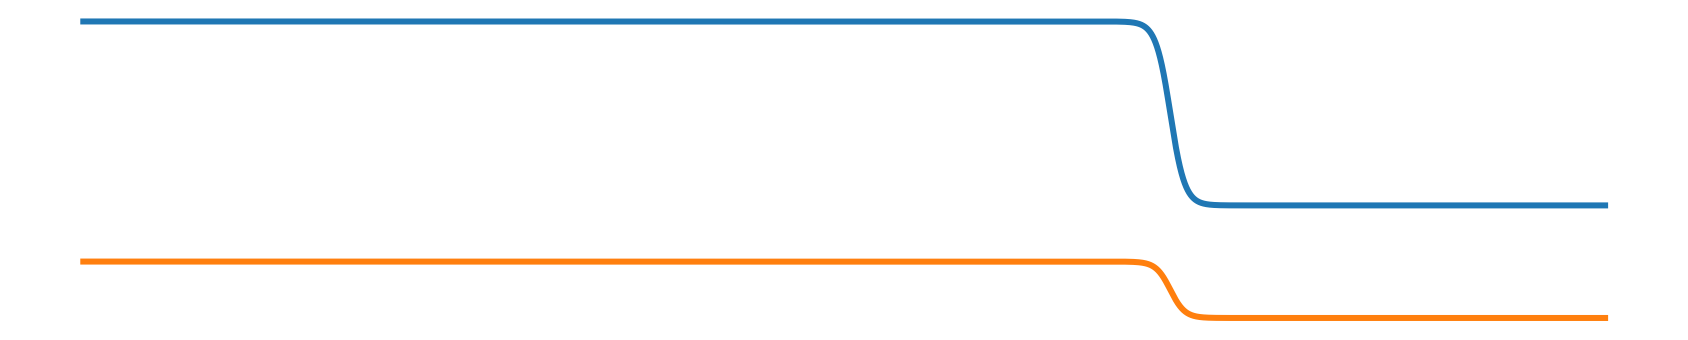

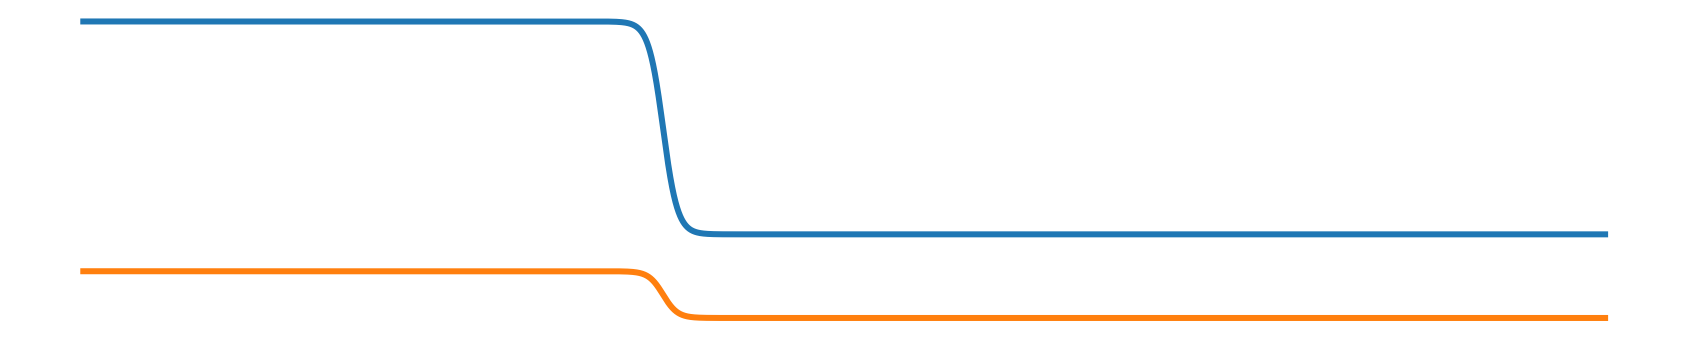

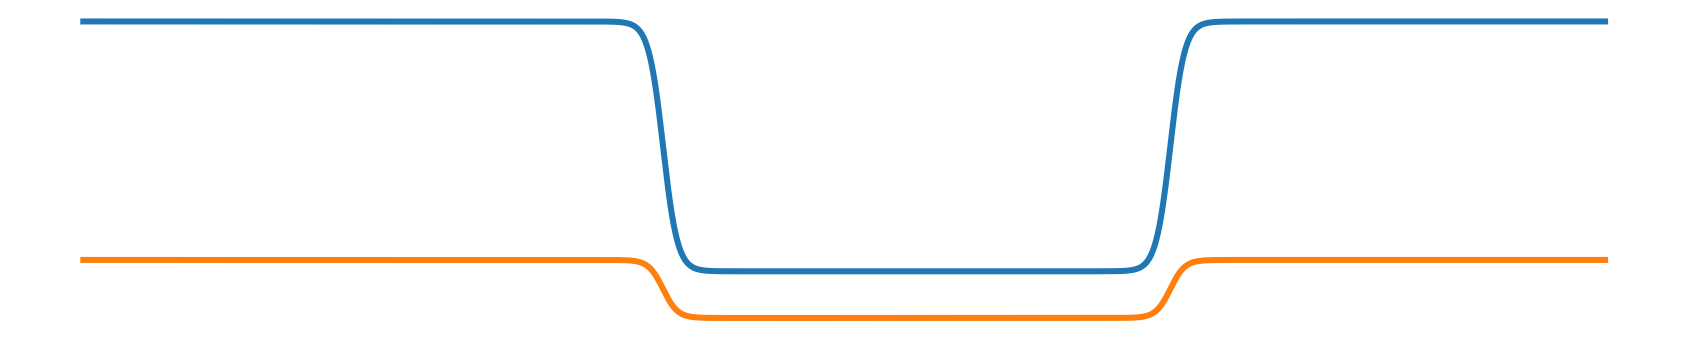

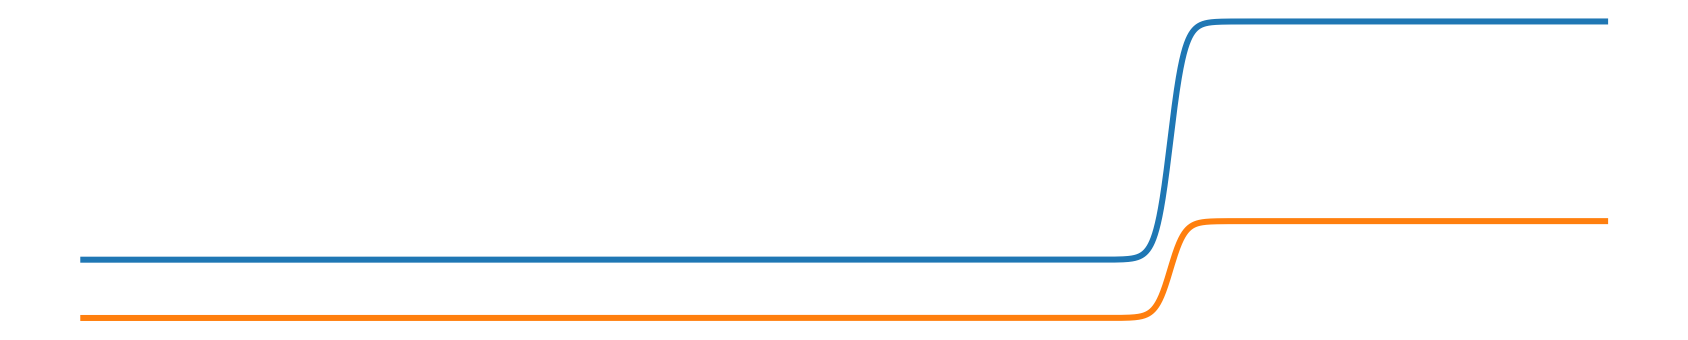

In [304]:
fig=plt.figure(figsize=(30, 6))
plt.plot(sol.t,fgS_array[0],label='gS',linewidth=6)
plt.plot(sol.t,fgT_array[0],label='gT',linewidth=6)
plt.axis('off')
fig.savefig('STG1_c.jpg')

fig=plt.figure(figsize=(30, 6))
plt.plot(sol.t,fgS_array[1],label='gS',linewidth=6)
plt.plot(sol.t,fgT_array[1],label='gT',linewidth=6)
plt.axis('off')
fig.savefig('STG2_c.jpg')

fig=plt.figure(figsize=(30, 6))
plt.plot(sol.t,fgS_array[2],label='gS',linewidth=6)
plt.plot(sol.t,fgT_array[2],label='gT',linewidth=6)
plt.axis('off')
fig.savefig('STG3_c.jpg')

fig=plt.figure(figsize=(30, 6))
plt.plot(sol.t,fgS_array[3],label='gS',linewidth=6)
plt.plot(sol.t,fgT_array[3],label='gT',linewidth=6)
plt.axis('off')
fig.savefig('STG4_c.jpg')

fig=plt.figure(figsize=(30, 6))
plt.plot(sol.t,fgS_array[4],label='gS',linewidth=6)
plt.plot(sol.t,fgT_array[4],label='gT',linewidth=6)
plt.axis('off')
fig.savefig('STG5_c.jpg')

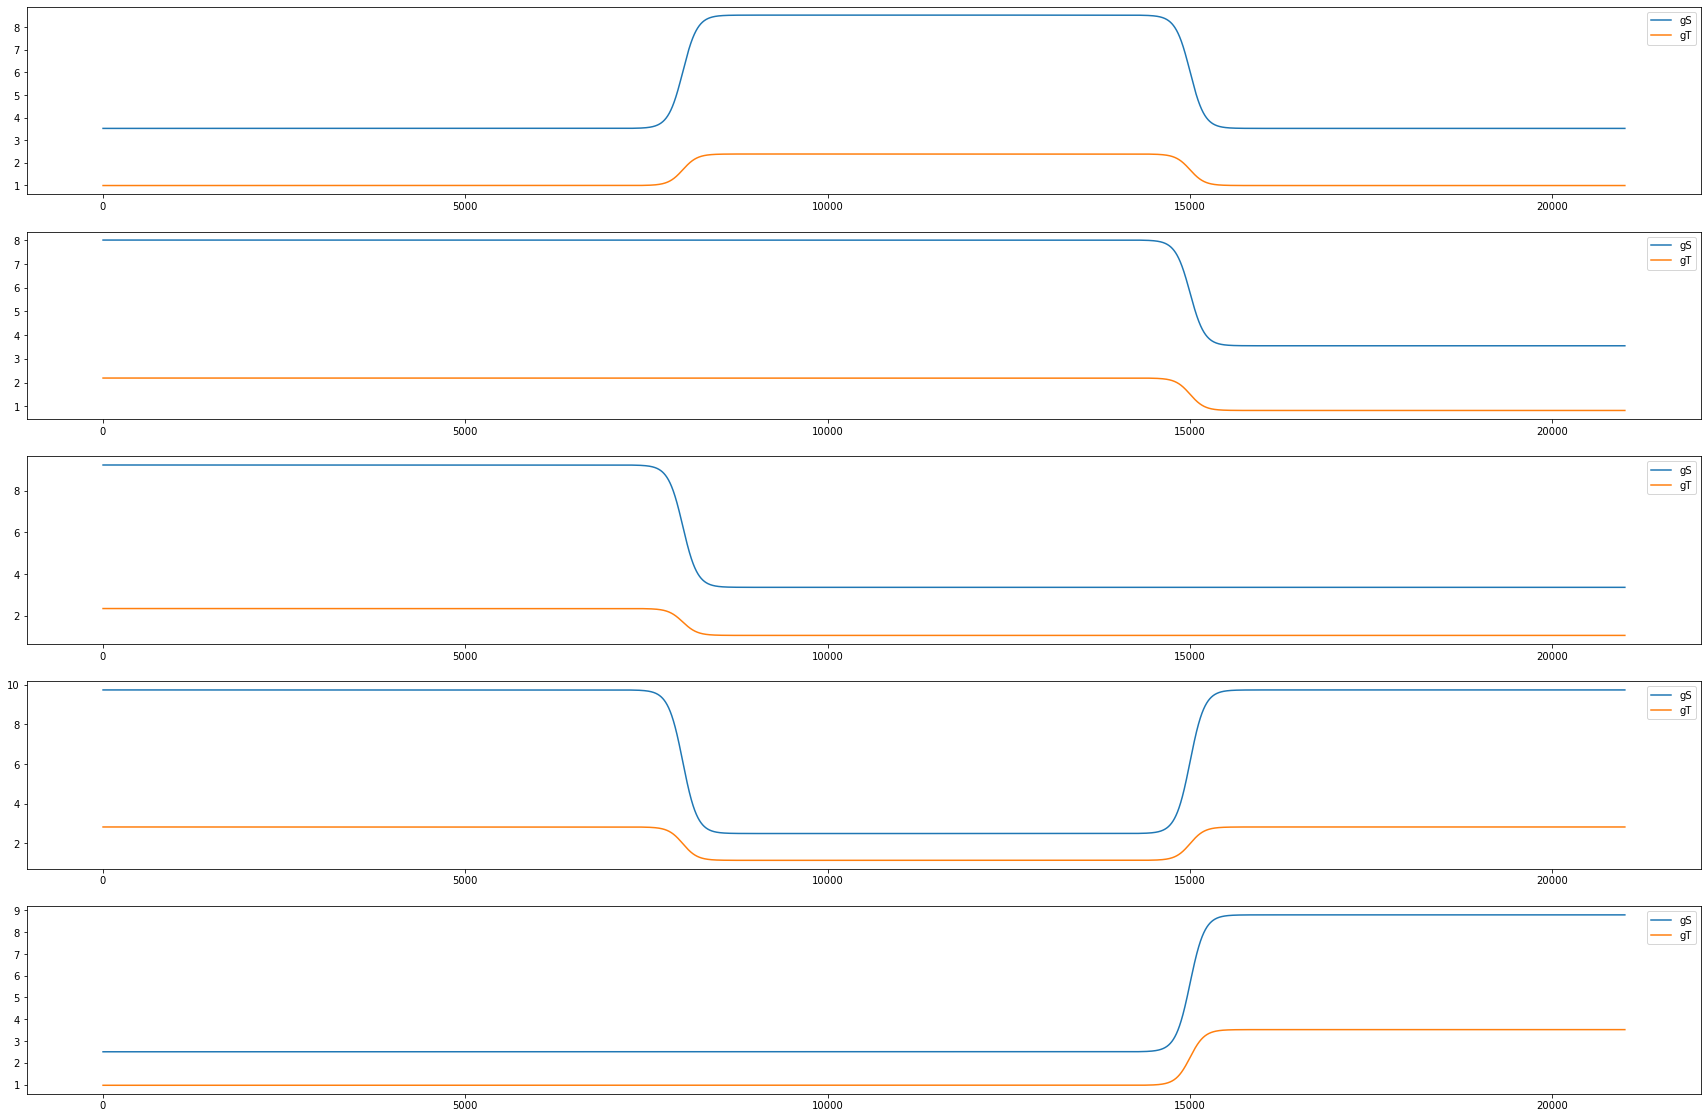

In [291]:
fgS_array=[[fgS(j,i) for i in sol.t]for j in range(5)]
fgT_array=[[fgT(j,i) for i in sol.t]for j in range(5)]
plt.figure(figsize=(30, 20))
plt.subplot(5, 1, 1)
plt.plot(sol.t,fgS_array[0],label='gS')
plt.plot(sol.t,fgT_array[0],label='gT')
plt.legend()
plt.subplot(5, 1, 2)
plt.plot(sol.t,fgS_array[1],label='gS')
plt.plot(sol.t,fgT_array[1],label='gT')
plt.legend()
plt.subplot(5, 1, 3)
plt.plot(sol.t,fgS_array[2],label='gS')
plt.plot(sol.t,fgT_array[2],label='gT')
plt.legend()
plt.subplot(5, 1, 4)
plt.plot(sol.t,fgS_array[3],label='gS')
plt.plot(sol.t,fgT_array[3],label='gT')
plt.legend()
plt.subplot(5, 1, 5)
plt.plot(sol.t,fgS_array[4],label='gS')
plt.plot(sol.t,fgT_array[4],label='gT')
plt.legend()
plt.show()


In [74]:
file_sol= open('sol.data','wb') 
pickle.dump(sol, file_sol)

In [269]:
#Hyperparameters
net1.set_mod(fgS,fgT)
gamma=10.
alpha=0.001
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net1.cells[0].set_hyp(gamma,alpha,variable_mask1)
net1.cells[1].set_hyp(gamma,alpha,variable_mask2)
net1.cells[2].set_hyp(gamma,alpha,variable_mask3)
net1.cells[3].set_hyp(gamma,alpha,variable_mask2)
net1.cells[4].set_hyp(gamma,alpha,variable_mask1)

In [270]:
X0=[*net1.cells[0].init_cond_OB(-60+5),*net1.cells[1].init_cond_OB(-60-5),*net1.cells[2].init_cond_OB(-61),*net1.cells[3].init_cond_OB(-60-2),*net1.cells[4].init_cond_OB(-60+1)]
## Definition of simulation time.
Tfinal=28000.0
tspan=[0.0,Tfinal]
start = time.time()
sol2=solve_ivp(net1.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[6.52814000e+02 1.07445000e-01 5.28839738e+01 5.15008000e+01
 1.09659000e+02 1.00000000e-02 6.30373000e+01 9.05788963e+01
 7.71695119e-02]
[-24.20169049]
[5.03580000e+02 9.29811000e-02 5.04889680e+01 5.83269000e+01
 7.41655000e+01 1.00000000e-02 5.41351000e+01 5.74556296e+01
 7.63508367e-02 2.10839169e-02]
[-11.01243488]
[6.34723000e+02 7.81820000e-02 4.33153730e+01 4.03572000e+01
 7.47833000e+01 1.00000000e-02 6.57822000e+01 1.08306908e+01
 7.98892228e-02 8.83547232e-02 2.10839169e-02 2.28748603e-02]
[-76.37485592]
[4.59807000e+02 8.34140000e-02 6.86189015e+01 5.85102000e+01
 9.11938000e+01 1.00000000e-02 5.59324000e+01 5.97965784e+01
 1.17123333e-01 2.28748603e-02]
[-57.34718794]
[6.16433000e+02 8.87343000e-02 5.24145591e+01 5.18502000e+01
 1.11870000e+02 1.00000000e-02 7.02168000e+01 2.80354862e+00
 7.76215841e-02]
[-62.17130788]
Elapsed (with compilation) = 463.79711413383484


In [271]:
file_sol2= open('sol2.data','wb') 
pickle.dump(sol2, file_sol2)

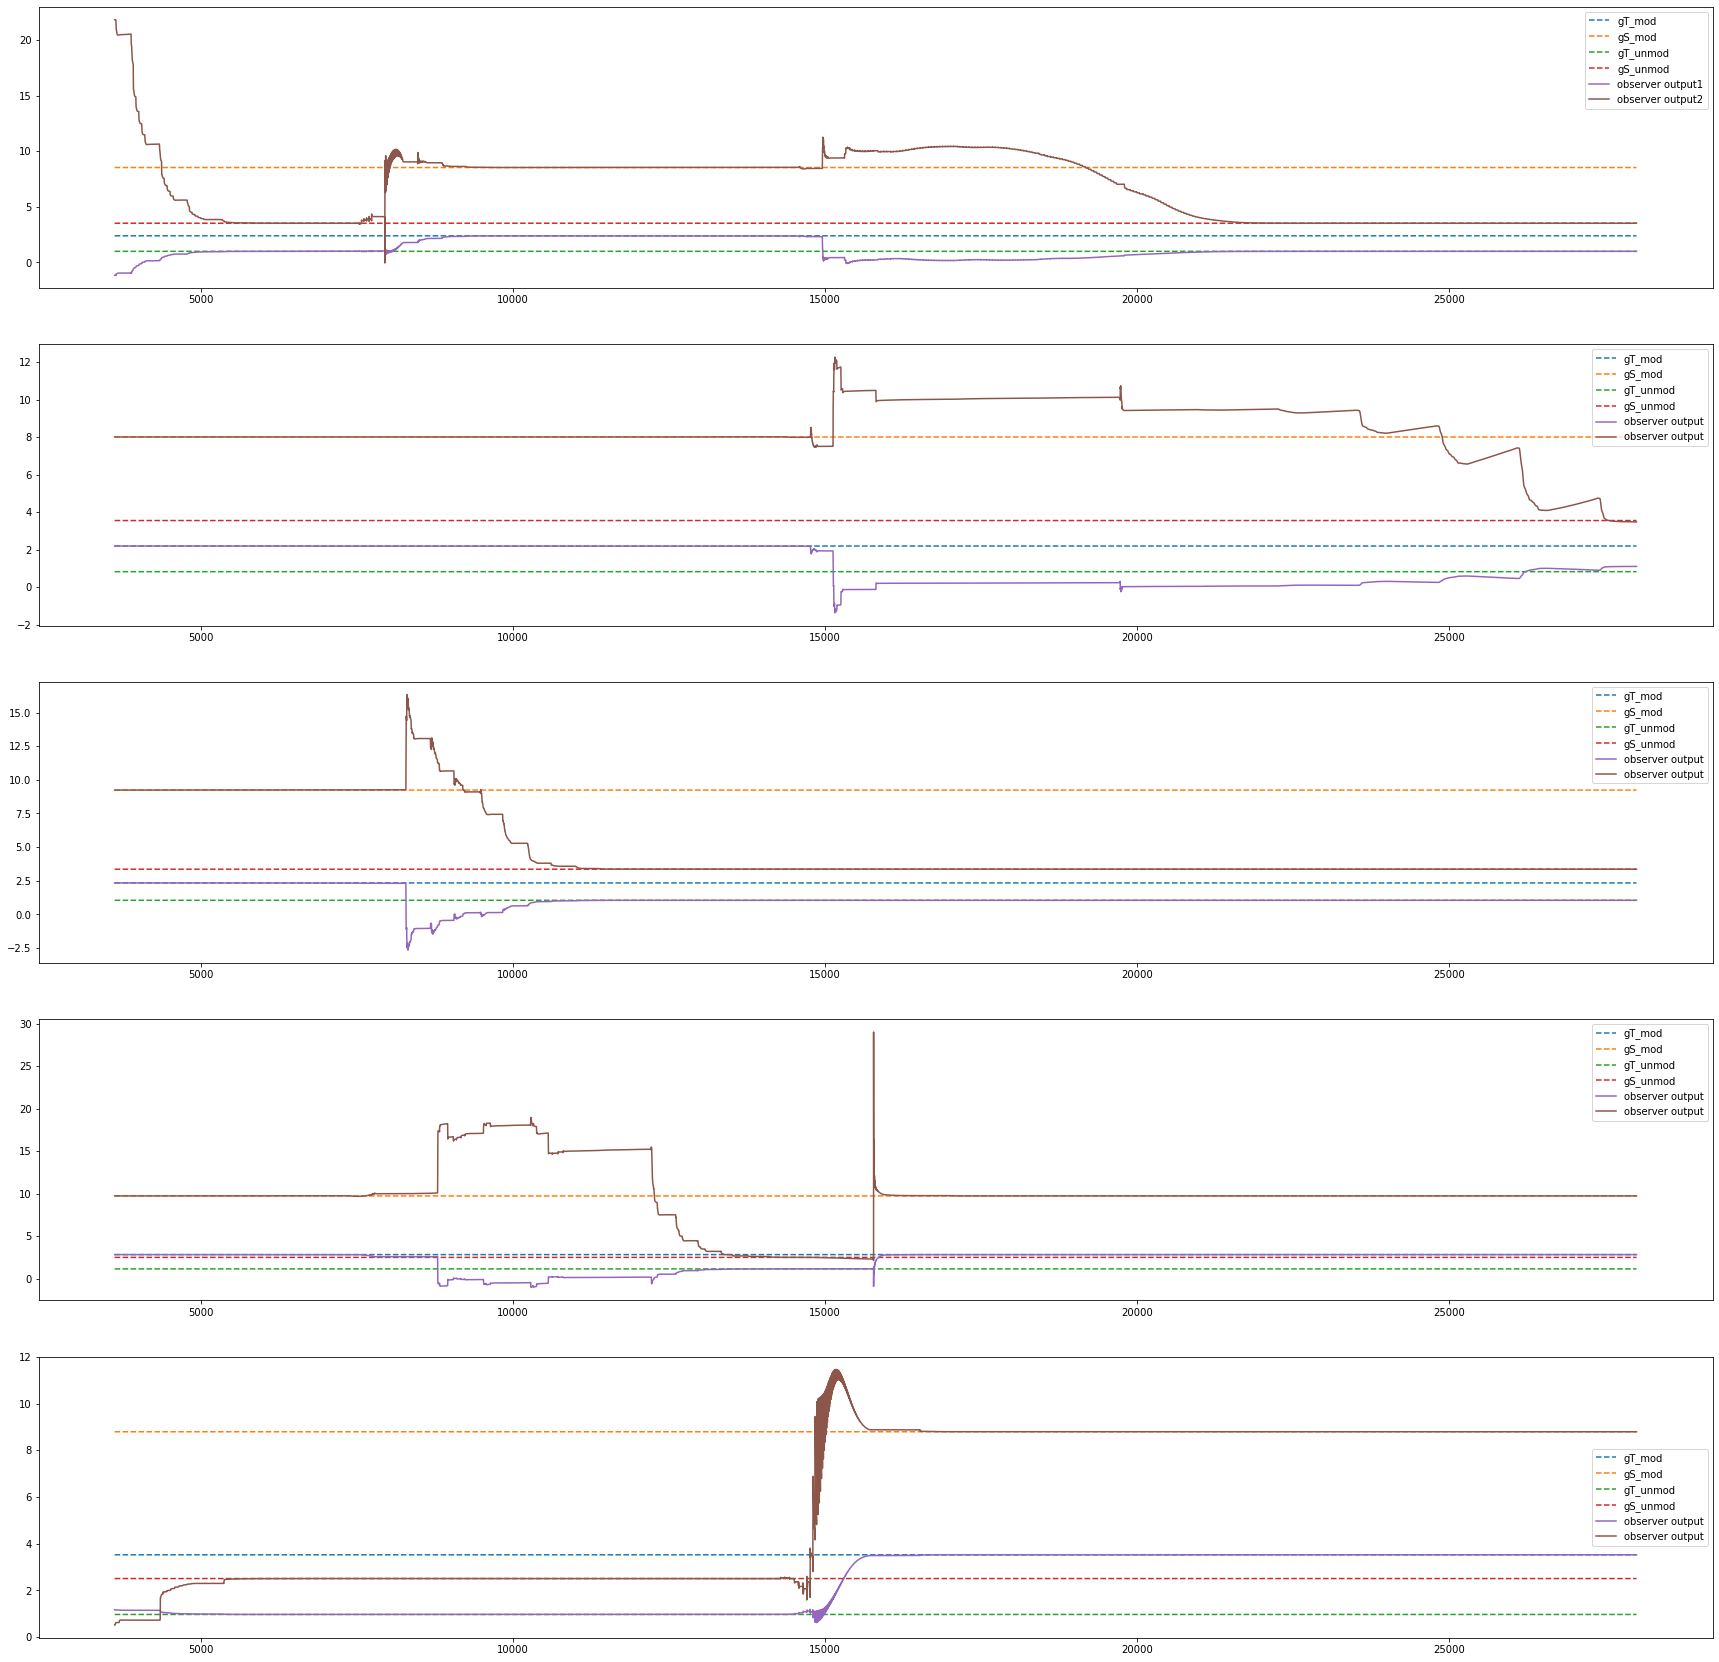

0.9928840000000042
1.1035529647182203
1.0495799999999984
2.829570000000002
3.525739999999997


In [272]:
plot_fun2(net1,sol2)

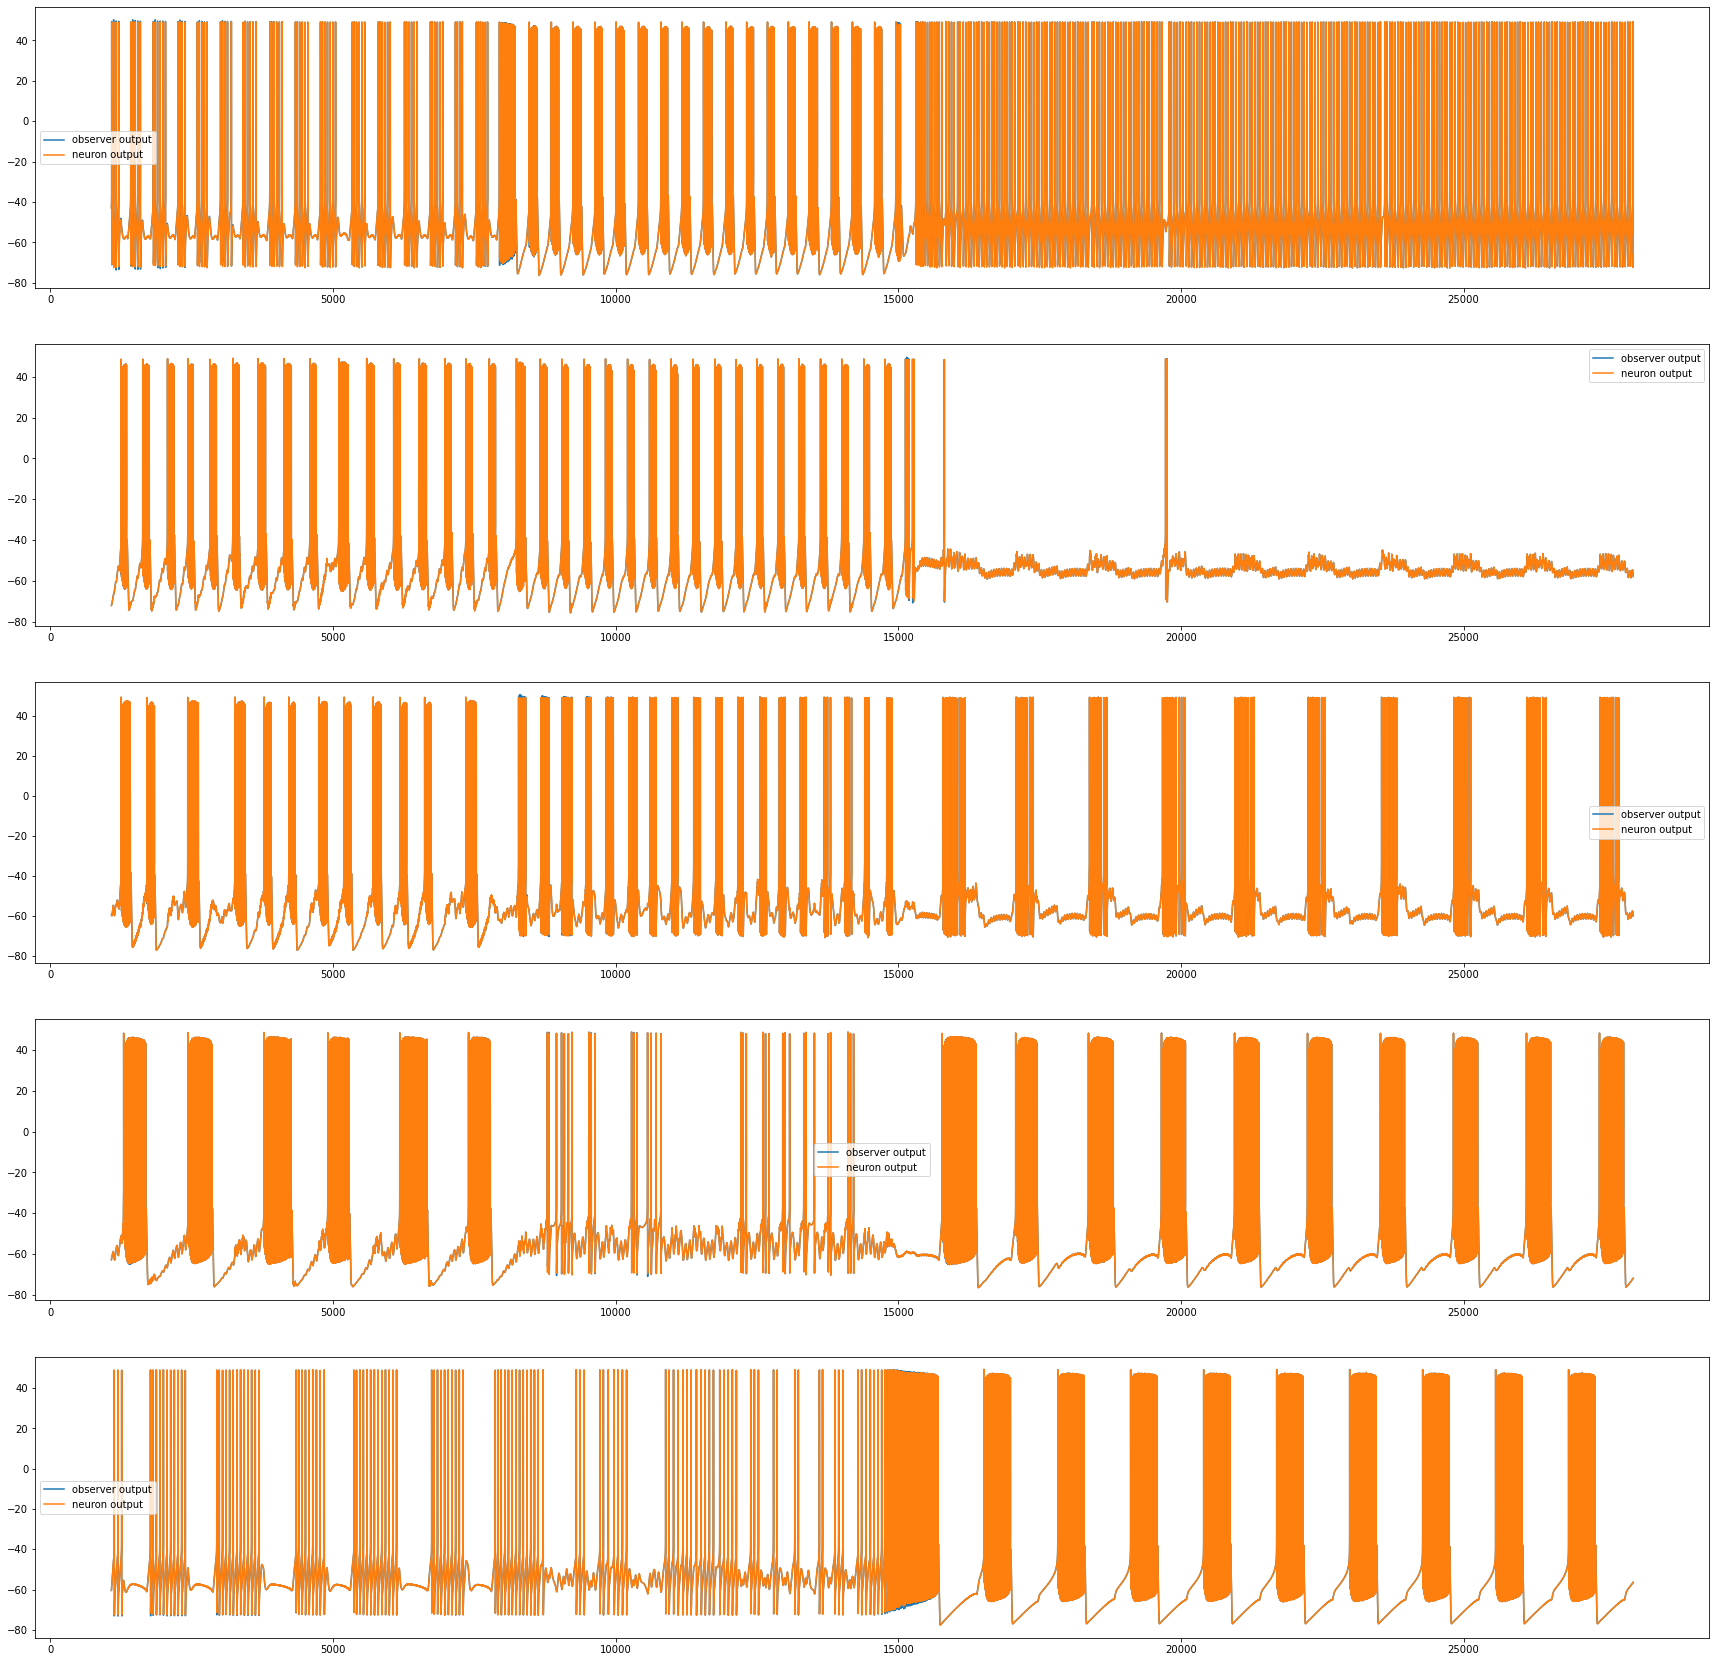

In [273]:
plot_fun(net1,sol2)

In [261]:
#Hyperparameters
gamma=8.
alpha=0.005
variable_mask1=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.])
variable_mask2=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
variable_mask3=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
net1.cells[0].set_hyp(gamma,alpha,variable_mask1)
net1.cells[1].set_hyp(gamma,alpha,variable_mask2)
net1.cells[2].set_hyp(gamma,alpha,variable_mask3)
net1.cells[3].set_hyp(gamma,alpha,variable_mask2)
net1.cells[4].set_hyp(gamma,alpha,variable_mask1)

In [262]:
X0=[*net1.cells[0].init_cond_OB(-60+5),*net1.cells[1].init_cond_OB(-60-5),*net1.cells[2].init_cond_OB(-61),*net1.cells[3].init_cond_OB(-60-2),*net1.cells[4].init_cond_OB(-60+1)]
## Definition of simulation time.
Tfinal=24000.0
tspan=[0.0,Tfinal]
start = time.time()
sol3=solve_ivp(net1.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[ 3.34846947 94.77456015 49.12499366 51.75472036 78.03497179 21.09592072
 43.97061921 94.98135436 94.81714661]
[-81.0187386]
[51.40907646 65.93151113 40.57505371 77.85387576  7.00154928 59.65627272
 29.48649986  8.35148182 15.39160408  6.7439122 ]
[-84.0372111]
[ 4.14063404  4.71300172 52.49364275 44.45848324 29.9058063  50.78453497
 51.33793245 30.69400851 61.84039804 25.15799282  8.20986713 95.36632082]
[-25.26365972]
[19.29795165 88.21615007 47.3268648  34.7663586  29.28546018 42.0779473
 73.35682333 82.01503261 11.45381346 78.3851238 ]
[-91.71960173]
[44.87604408 55.05523555 19.15153964  3.41618087 36.66790287 53.78728451
 38.89130747  1.72417281 90.17237151]
[-68.20722032]
Elapsed (with compilation) = 416.3254556655884


In [263]:
file_sol3= open('sol3.data','wb') 
pickle.dump(sol3, file_sol3)

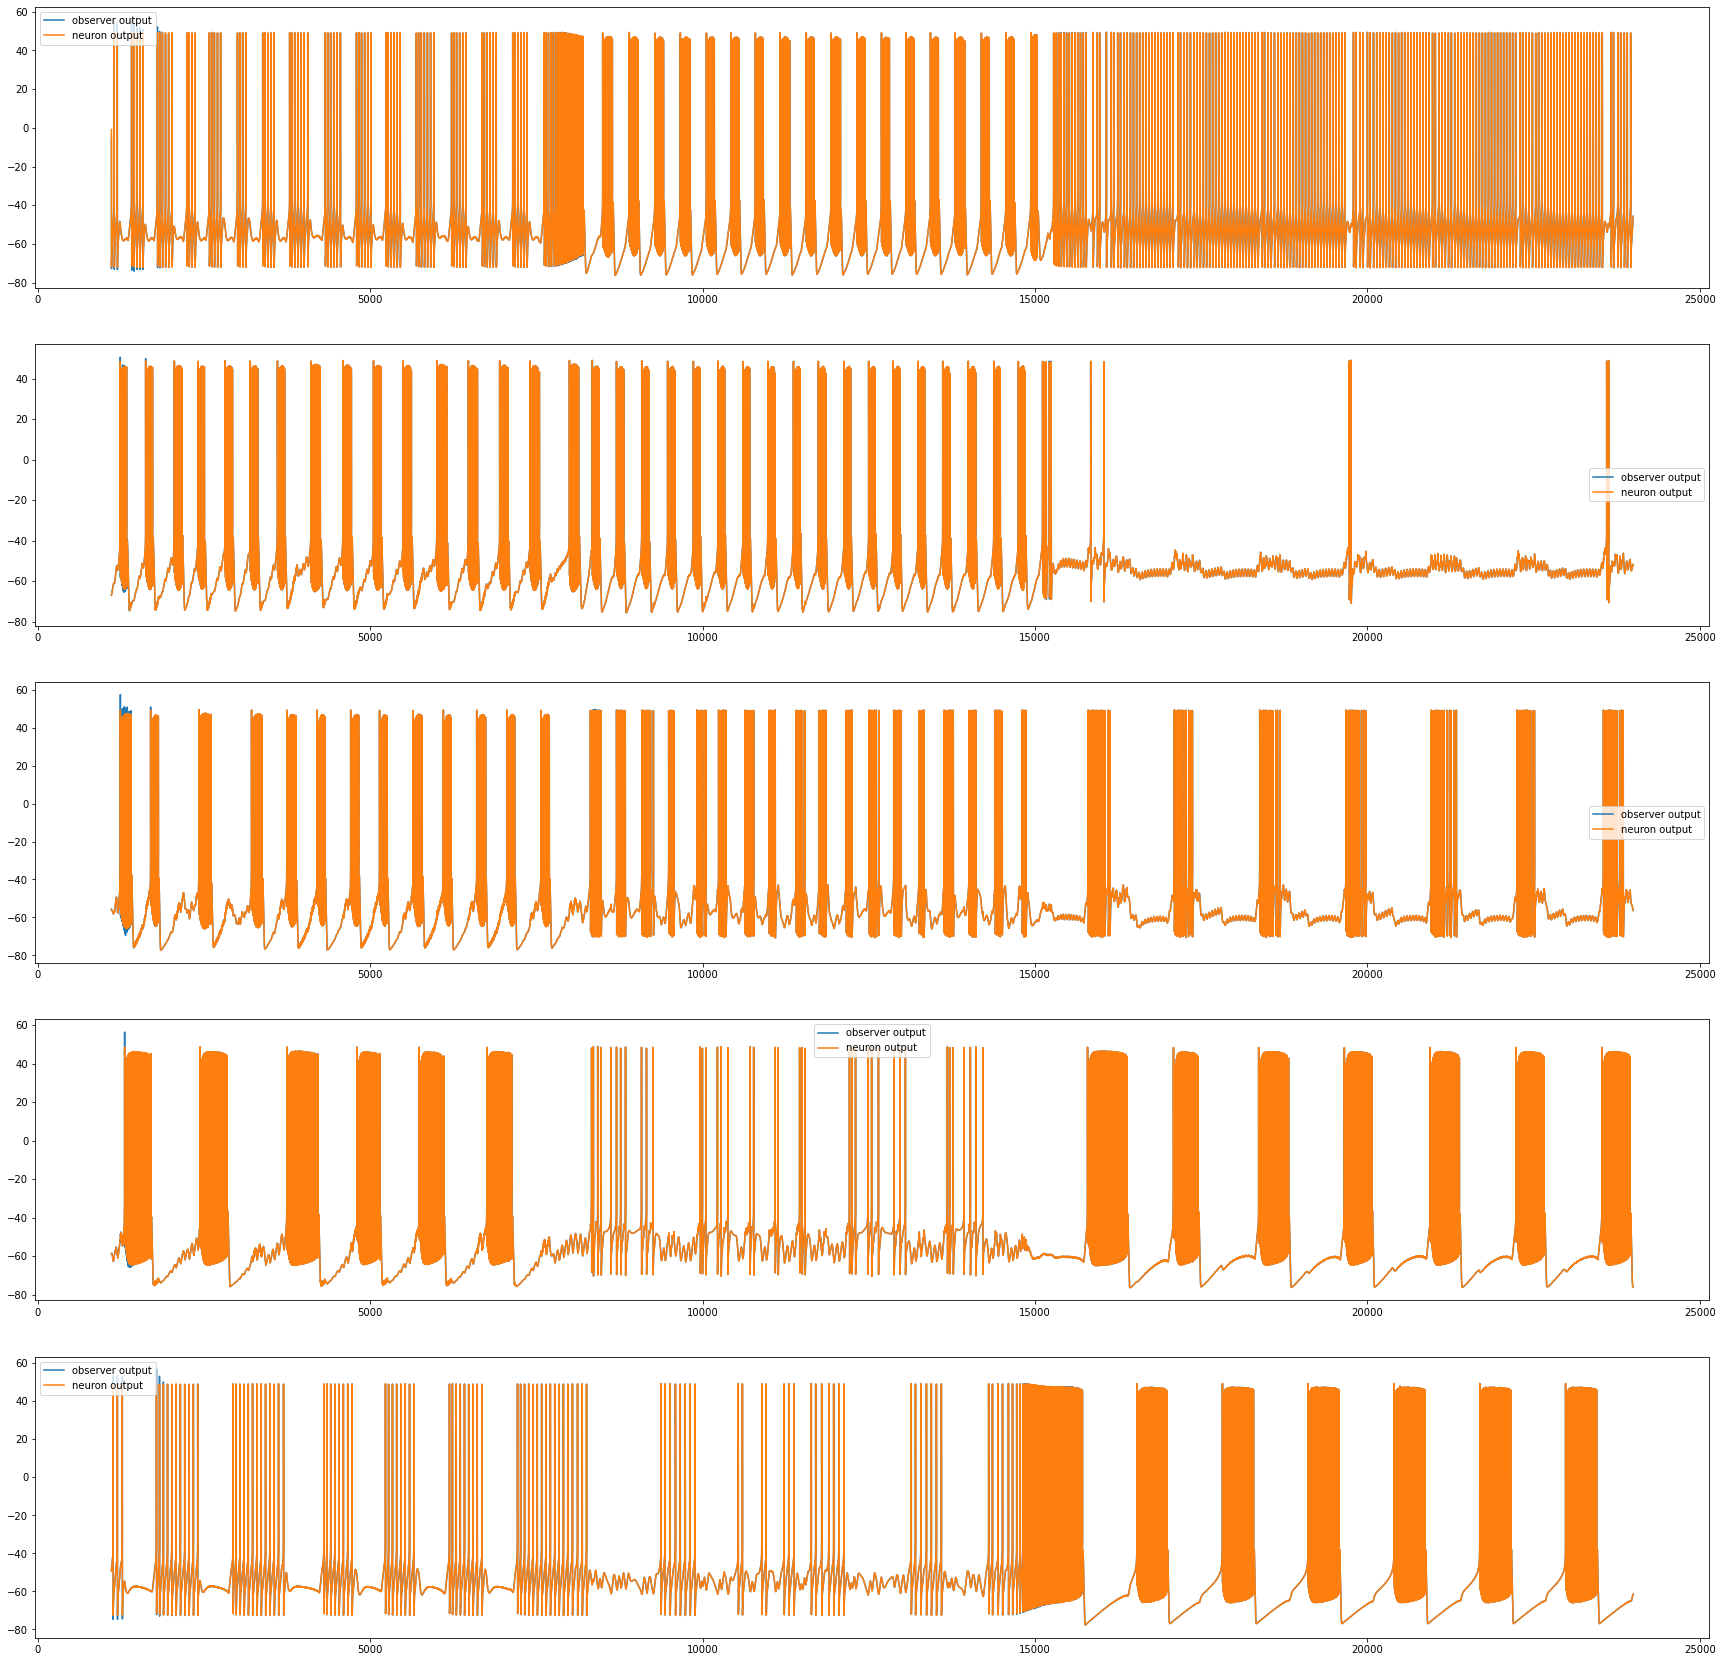

In [264]:
plot_fun(net1,sol3)

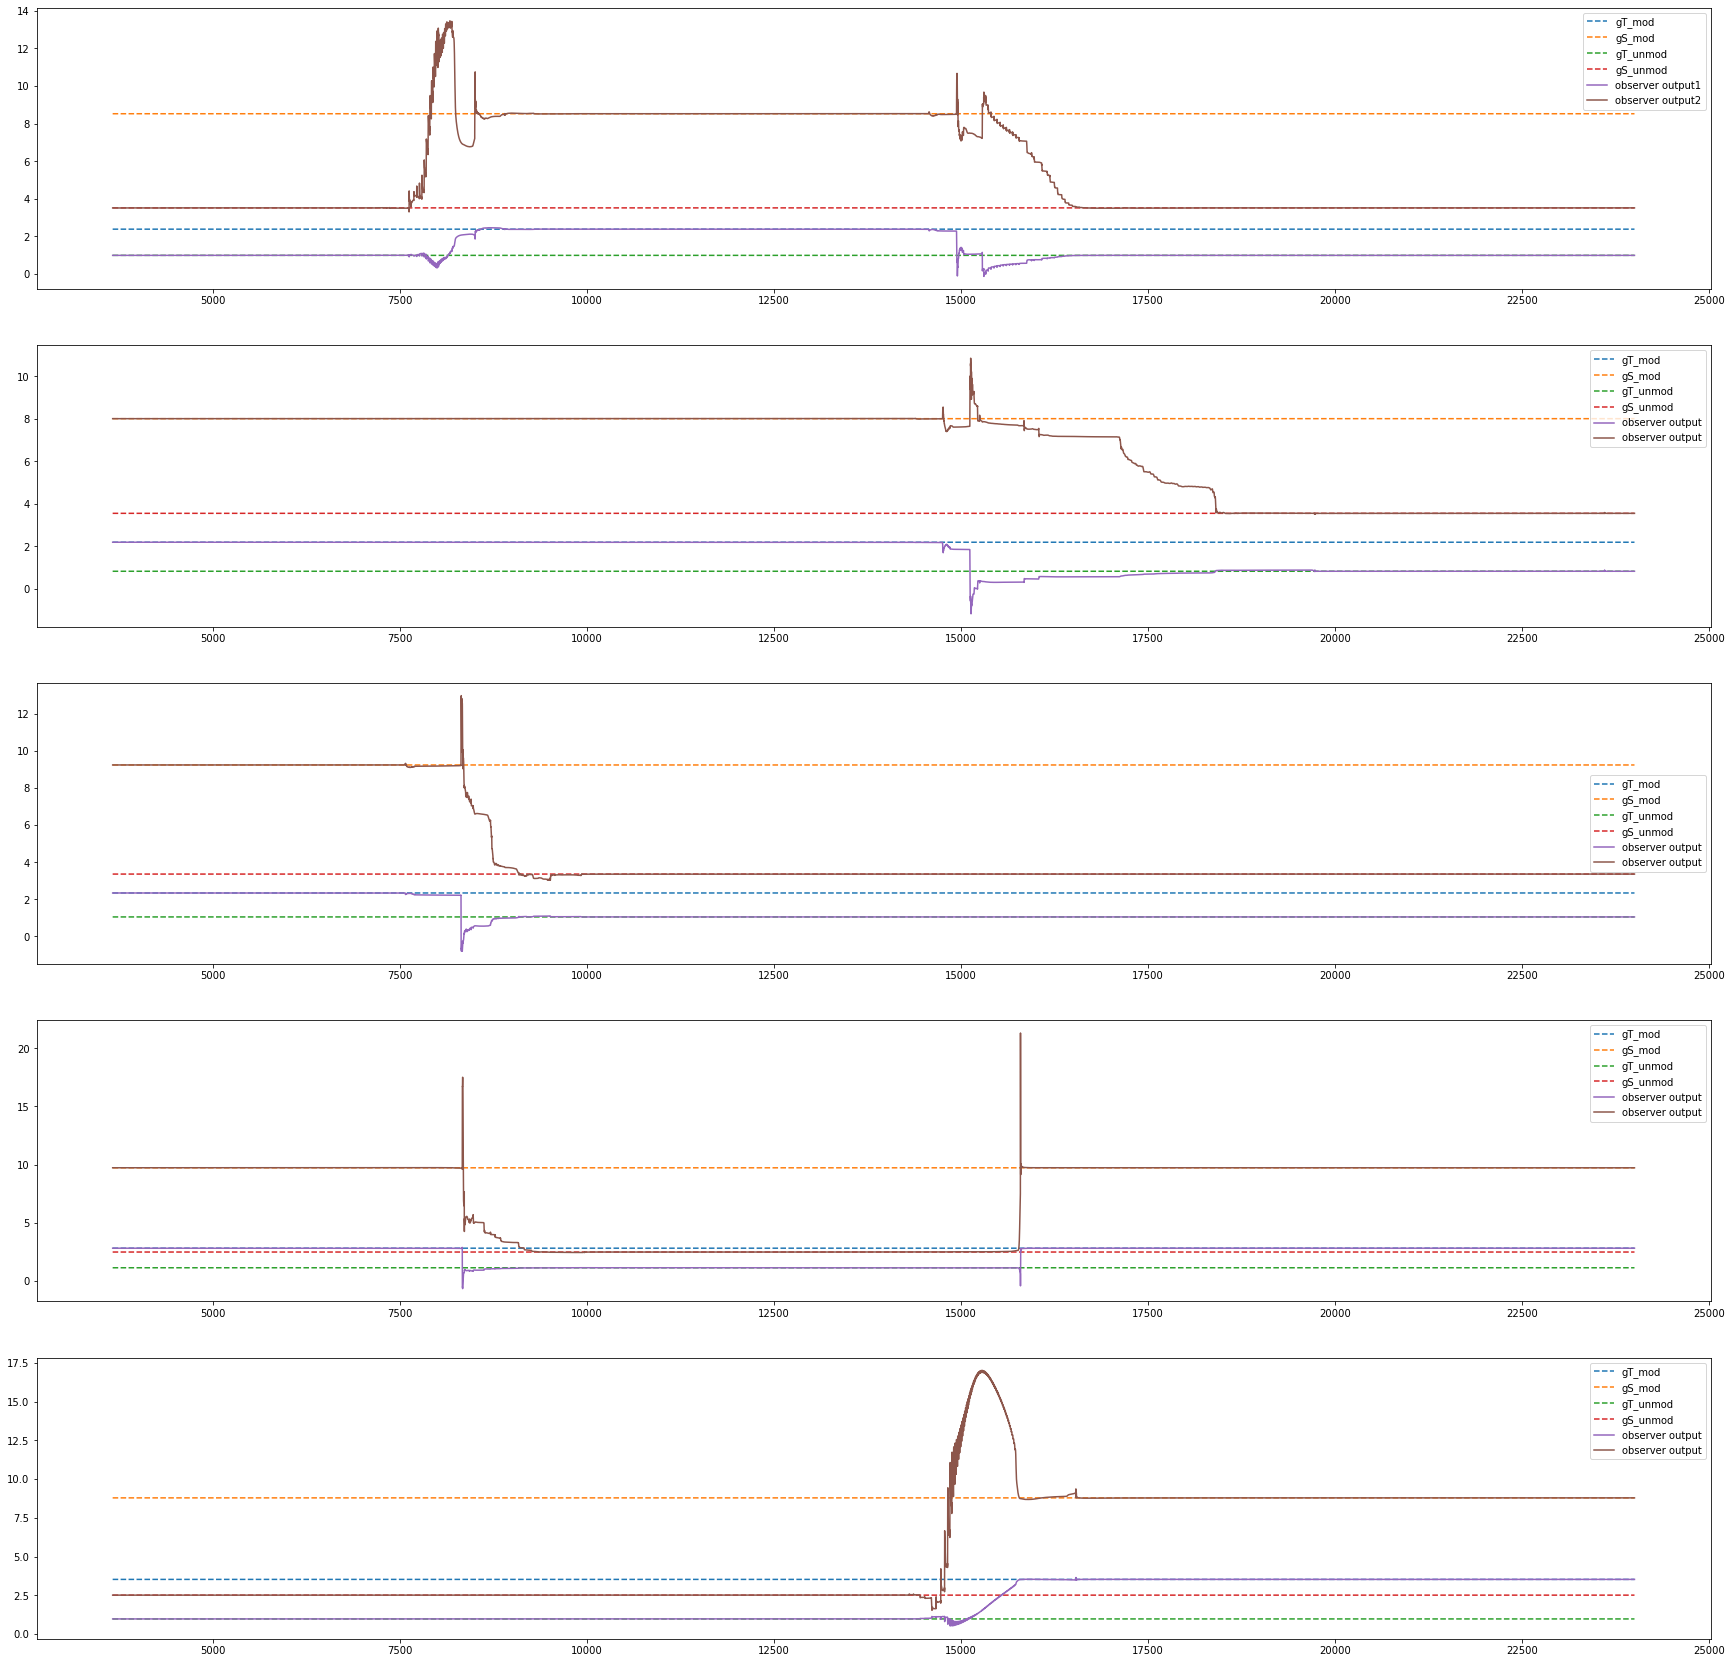

0.9928840000000054
0.8247925517327863
1.049579999999992
2.8295700000000252
3.5257399999956367


In [265]:
plot_fun2(net1,sol3)

In [158]:
net2=random_MOD2([0.,1.,1.,1.,0.])
#Hyperparameters
net2.set_mod(fgS,fgT)
gamma=15.
alpha=0.0015
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net2.cells[0].set_hyp(gamma,alpha,variable_mask1)
net2.cells[1].set_hyp(gamma,alpha,variable_mask2)
net2.cells[2].set_hyp(gamma,alpha,variable_mask3)
net2.cells[3].set_hyp(gamma,alpha,variable_mask2)
net2.cells[4].set_hyp(gamma,alpha,variable_mask1)


num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9


In [159]:
X0=[*net2.cells[0].init_cond_OB(-60+5),*net2.cells[1].init_cond_OB(-60+2),*net2.cells[2].init_cond_OB(-61),*net2.cells[3].init_cond_OB(-60-2),*net2.cells[4].init_cond_OB(-60+1)]
## Definition of simulation time.
Tfinal=24000.0
tspan=[0.0,Tfinal]
start = time.time()
sol4=solve_ivp(net2.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[6.52814000e+02 1.07445000e-01 1.32706916e+01 5.15008000e+01
 1.09659000e+02 1.00000000e-02 6.30373000e+01 8.56862581e+01
 7.71695119e-02]
[-79.86346381]
[5.03580000e+02 9.29811000e-02 8.78540118e+01 5.83269000e+01
 8.41655000e+01 1.00000000e-02 5.41351000e+01 3.99226513e+01
 7.63508367e-02 2.10839169e-02]
[-67.75630125]
[6.34723000e+02 7.81820000e-02 6.83235218e+01 4.03572000e+01
 7.47833000e+01 1.00000000e-02 6.57822000e+01 3.44660648e+01
 7.98892228e-02 8.83547232e-02 2.10839169e-02 2.28748603e-02]
[-41.73945862]
[4.59807000e+02 8.34140000e-02 4.78381715e+01 5.85102000e+01
 9.11938000e+01 1.00000000e-02 5.59324000e+01 8.99711109e+01
 1.17123333e-01 2.28748603e-02]
[-12.59531226]
[6.16433000e+02 8.87343000e-02 1.40597356e+01 5.18502000e+01
 1.11870000e+02 1.00000000e-02 7.02168000e+01 9.81634177e+01
 7.76215841e-02]
[-99.38990637]
Elapsed (with compilation) = 424.42637395858765


In [160]:
file_sol4= open('sol4.data','wb') 
pickle.dump(sol4, file_sol4)
file_sol4.close()

In [ ]:
file_sol4r = open('sol4.data', 'rb') 
sol4= pickle.load(file_sol4r)
file_sol4r.close()

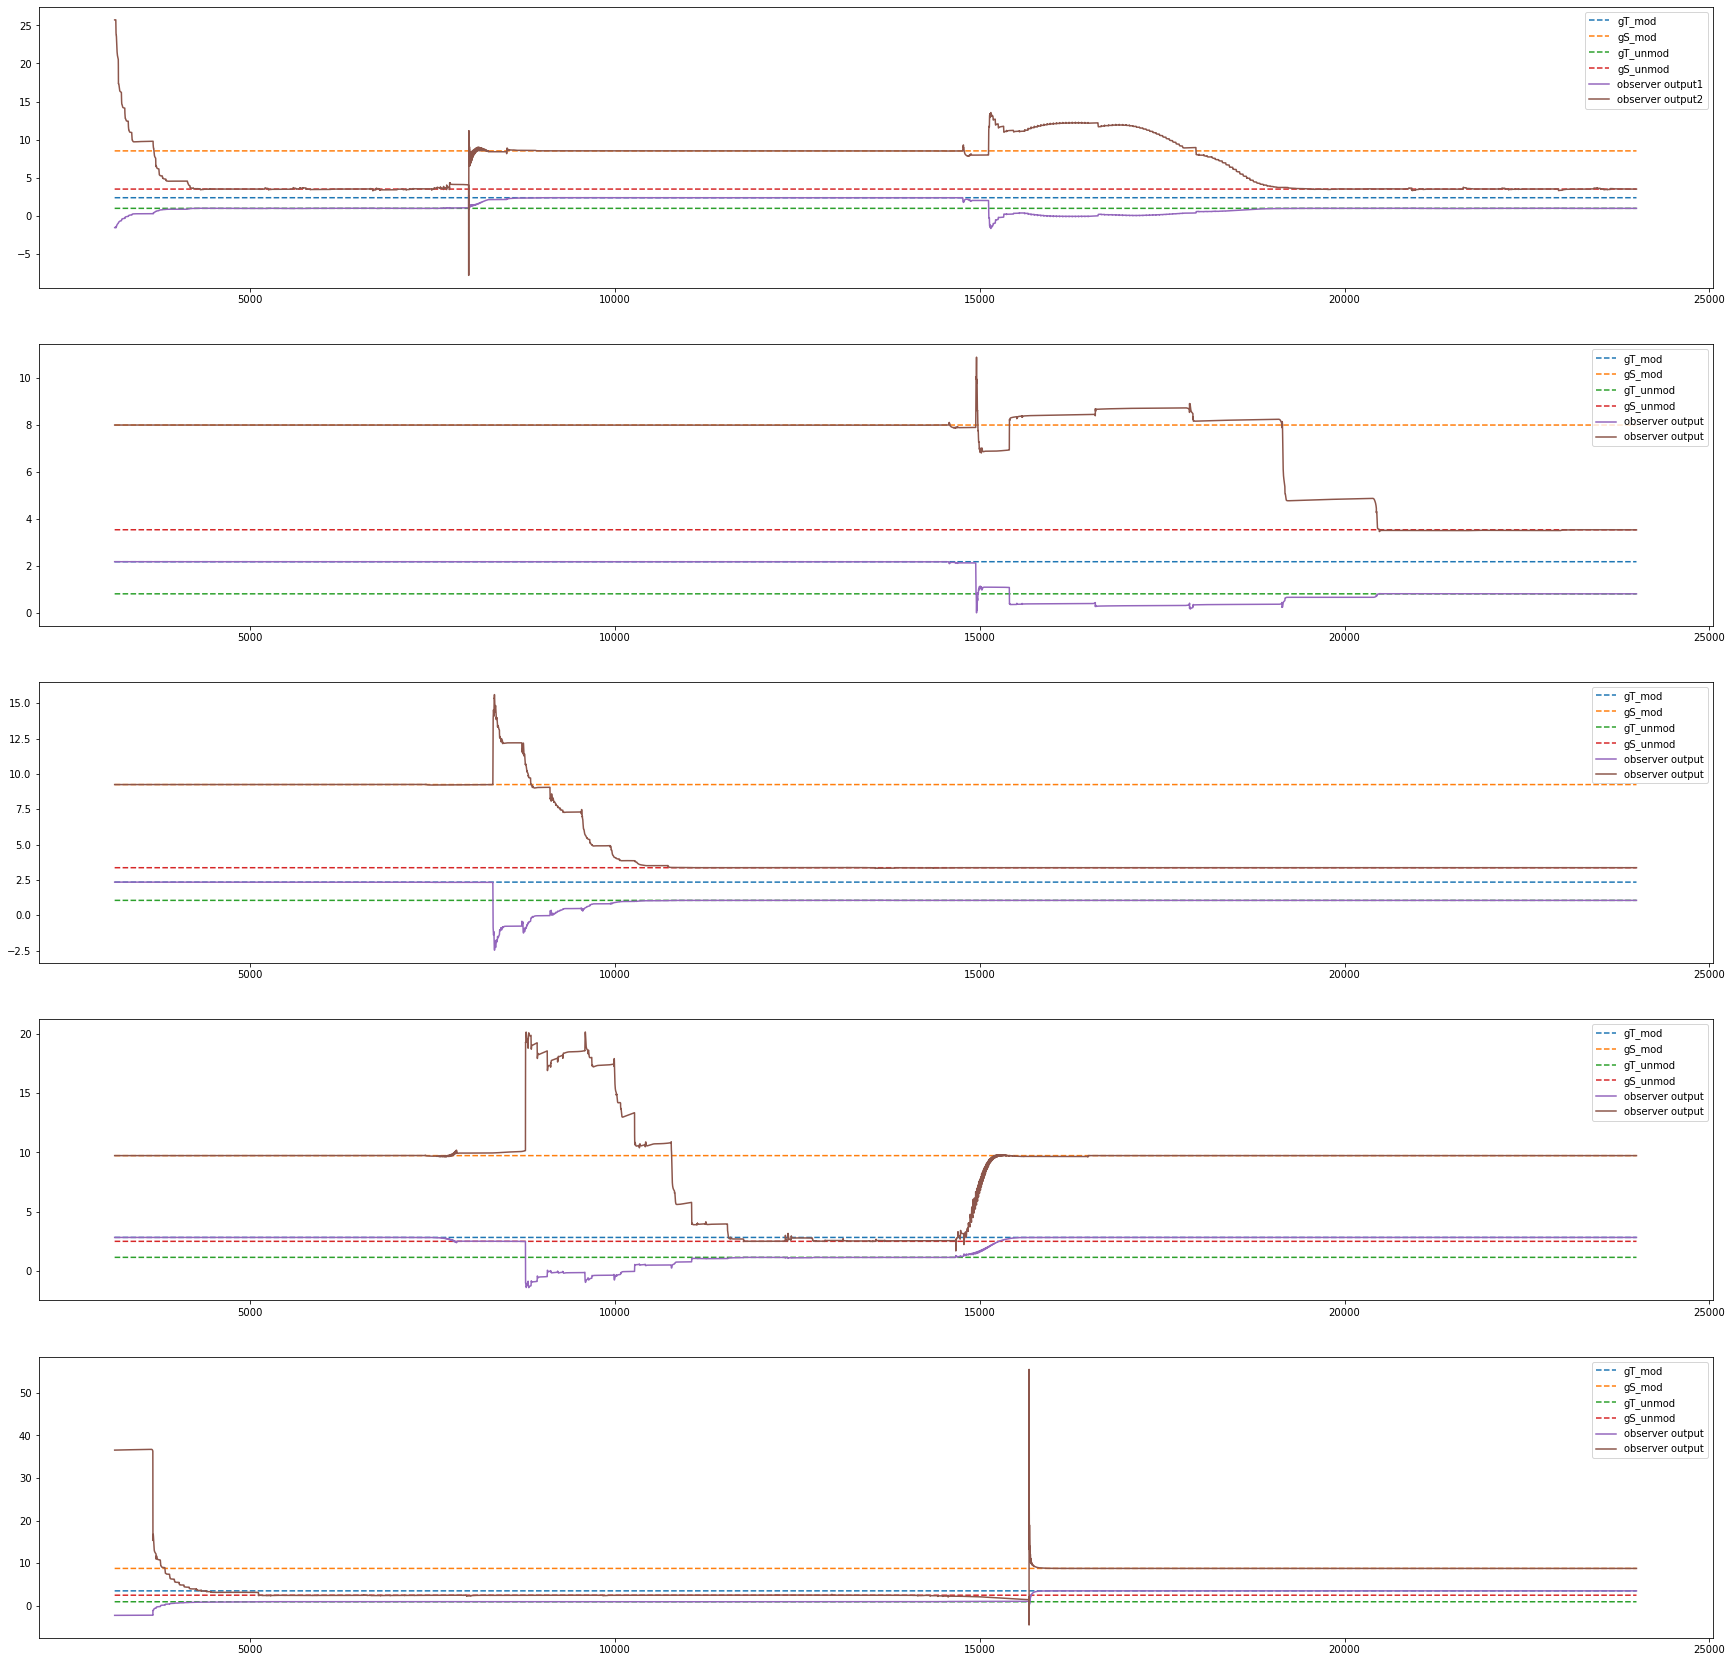

0.9928716501432812
0.8248336069950389
1.0495800000059112
2.829564236467341
3.5257400000476897


In [277]:
gT_mod_2=ones(len(sol4.t))*gCaTvec_MOD[2]
gS_mod_2=ones(len(sol4.t))*gCaSvec_MOD[2]
gT_unmod_2=ones(len(sol4.t))*gCaTvec[2]
gS_unmod_2=ones(len(sol4.t))*gCaSvec[2]

gT_mod_0=ones(len(sol4.t))*gCaTvec_MOD[0]
gS_mod_0=ones(len(sol4.t))*gCaSvec_MOD[0]
gT_unmod_0=ones(len(sol4.t))*gCaTvec[0]
gS_unmod_0=ones(len(sol4.t))*gCaSvec[0]

gT_mod_1=ones(len(sol4.t))*gCaTvec_MOD[1]
gS_mod_1=ones(len(sol4.t))*gCaSvec_MOD[1]
gT_unmod_1=ones(len(sol4.t))*gCaTvec[1]
gS_unmod_1=ones(len(sol4.t))*gCaSvec[1]

gT_mod_3=ones(len(sol4.t))*gCaTvec_MOD[3]
gS_mod_3=ones(len(sol4.t))*gCaSvec_MOD[3]
gT_unmod_3=ones(len(sol4.t))*gCaTvec[3]
gS_unmod_3=ones(len(sol4.t))*gCaSvec[3]

gT_mod_4=ones(len(sol4.t))*gCaTvec_MOD[4]
gS_mod_4=ones(len(sol4.t))*gCaSvec_MOD[4]
gT_unmod_4=ones(len(sol4.t))*gCaTvec[4]
gS_unmod_4=ones(len(sol4.t))*gCaSvec[4]


plot_fun2(net2,sol4)

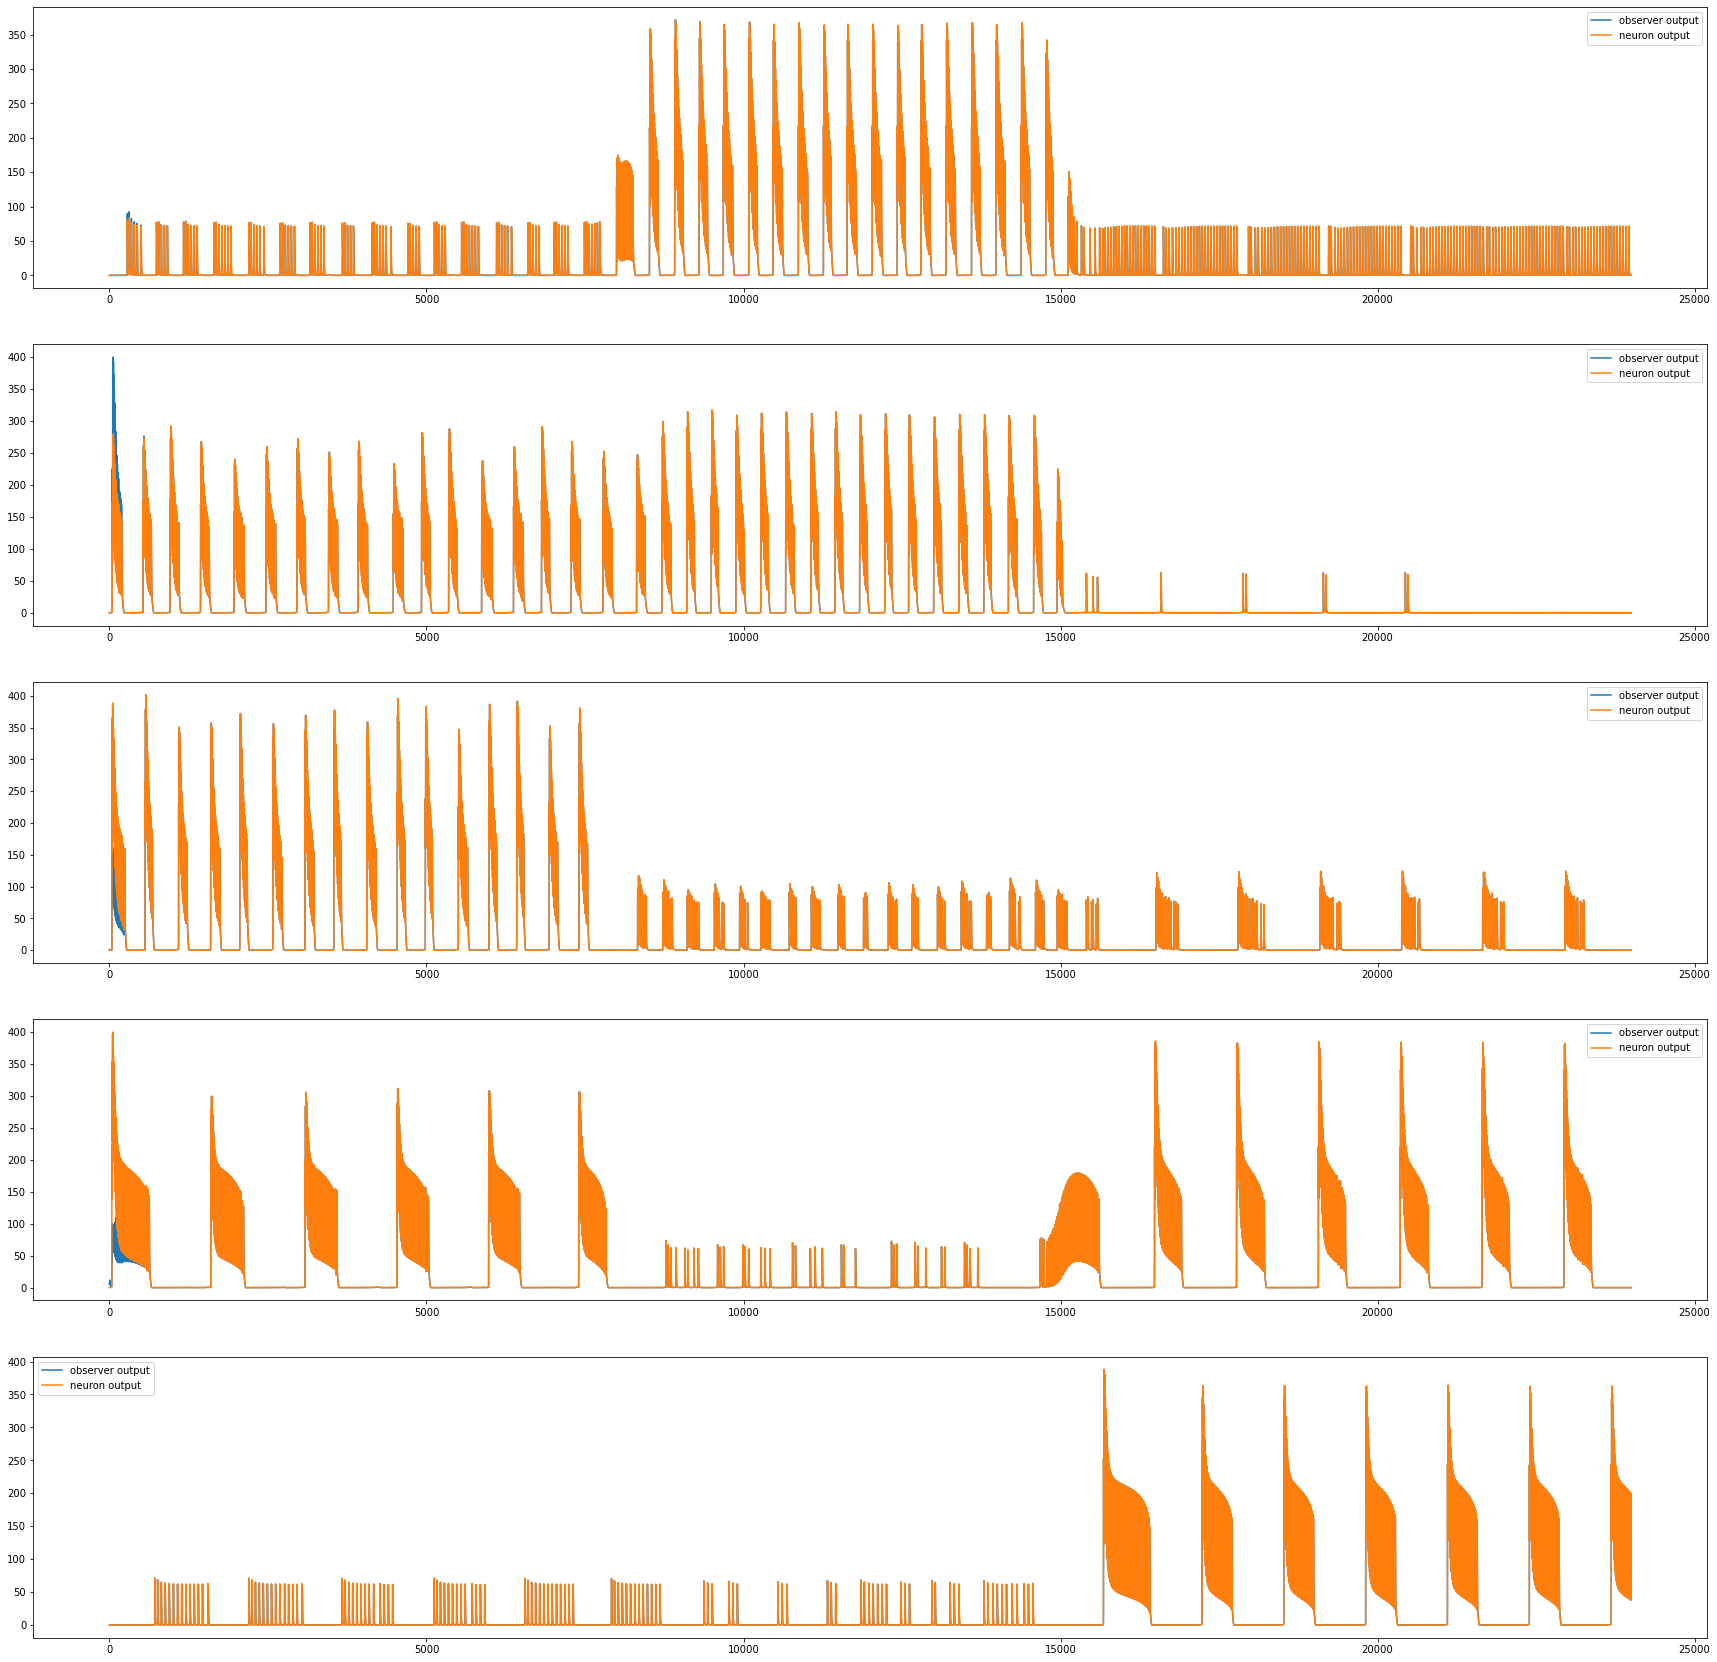

In [278]:
plot_fun1(net2,sol4)

In [194]:
net3=random_MOD_diag([0.,1.,1.,1.,0.])
#Hyperparameters
net3.set_mod(fgS2,fgT2)
gamma=10
alpha=0.0016
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net3.cells[0].set_hyp(gamma,alpha,variable_mask1)
net3.cells[1].set_hyp(gamma,alpha,variable_mask2)
net3.cells[2].set_hyp(gamma,alpha,variable_mask3)
net3.cells[3].set_hyp(gamma,alpha,variable_mask2)
net3.cells[4].set_hyp(gamma,alpha,variable_mask1)

num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9


In [195]:
X0=[*net3.cells[0].init_cond_OB(-60+5),*net3.cells[1].init_cond_OB(-60+2),*net3.cells[2].init_cond_OB(-61),*net3.cells[3].init_cond_OB(-60-2),*net3.cells[4].init_cond_OB(-60+1)]
## Definition of simulation time.
Tfinal=24000.0
tspan=[0.0,Tfinal]
start = time.time()
sol5=solve_ivp(net3.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[6.52814000e+02 1.07445000e-01 1.25788402e+00 5.15008000e+01
 1.09659000e+02 1.00000000e-02 6.30373000e+01 4.05496469e+00
 7.71695119e-02]
[-53.27762658]
[5.03580000e+02 9.29811000e-02 2.99479291e+00 5.83269000e+01
 8.41655000e+01 1.00000000e-02 5.41351000e+01 8.04748975e+00
 7.63508367e-02 2.10839169e-02]
[-33.68881286]
[6.34723000e+02 7.81820000e-02 2.77422970e+00 4.03572000e+01
 7.47833000e+01 1.00000000e-02 6.57822000e+01 9.25058399e+00
 7.98892228e-02 8.83547232e-02 2.10839169e-02 2.28748603e-02]
[-47.51987156]
[4.59807000e+02 8.34140000e-02 2.99847441e+00 5.85102000e+01
 9.11938000e+01 1.00000000e-02 5.59324000e+01 1.05561219e+01
 1.17123333e-01 2.28748603e-02]
[-2.77923441]
[6.16433000e+02 8.87343000e-02 1.63859239e+00 5.18502000e+01
 1.11870000e+02 1.00000000e-02 7.02168000e+01 3.32622110e+00
 7.76215841e-02]
[-11.2244784]
Elapsed (with compilation) = 287.3542604446411


In [197]:
file_sol5= open('sol5.data','wb') 
pickle.dump(sol5, file_sol5)
file_sol5.close()

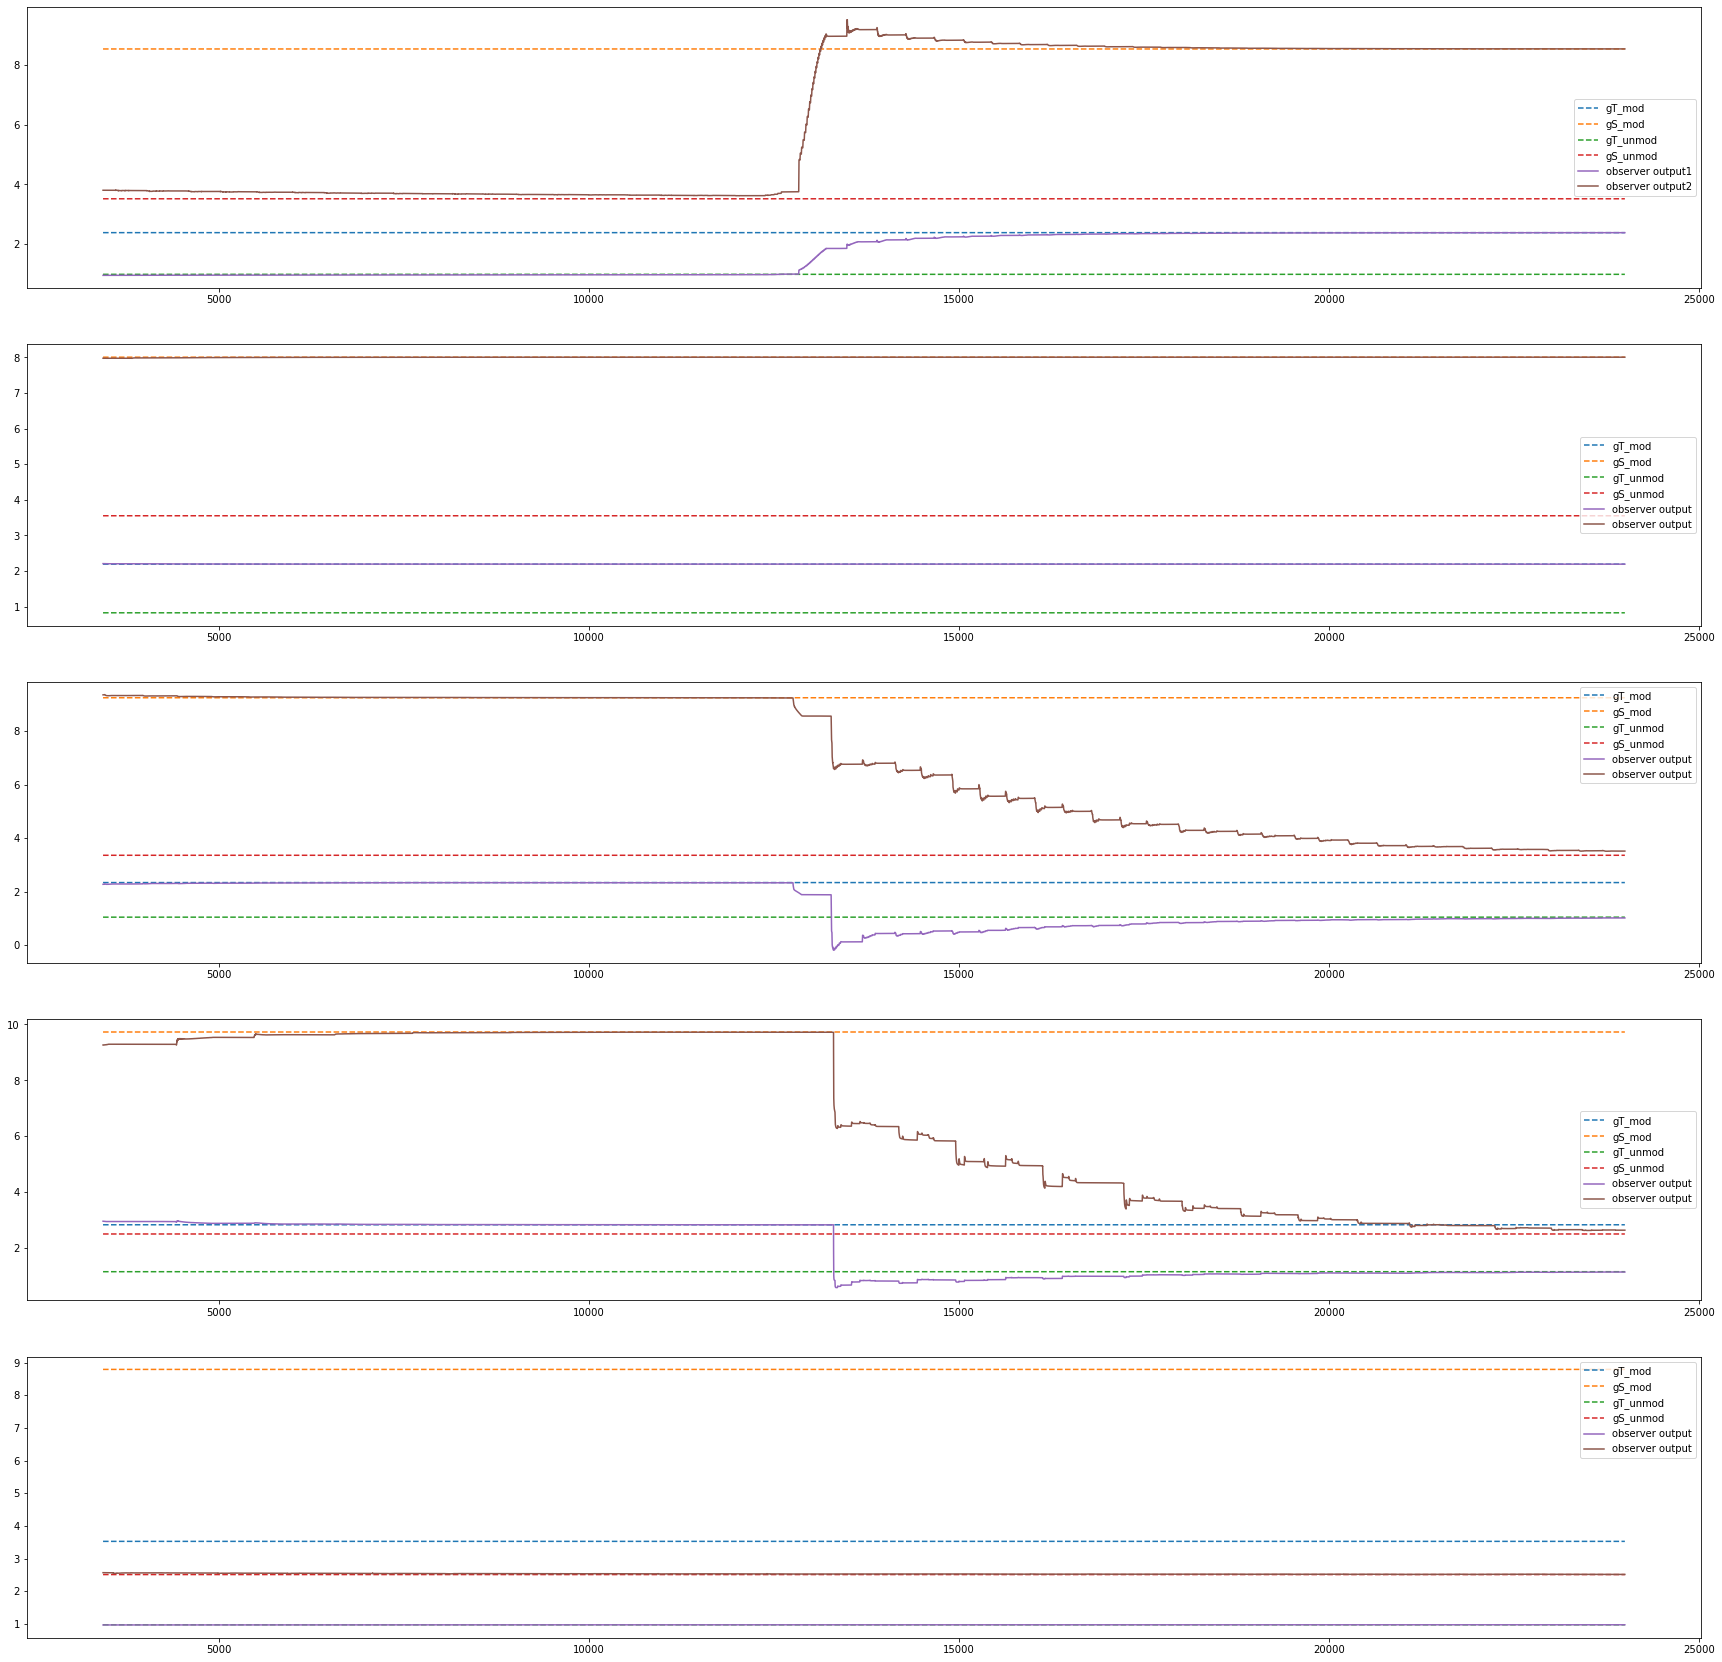

2.3858398113960604
2.1909200151384027
1.0200218722379333
1.1378200877324893
0.9713362129660557


In [196]:
gT_mod_2=ones(len(sol5.t))*gCaTvec_MOD[2]
gS_mod_2=ones(len(sol5.t))*gCaSvec_MOD[2]
gT_unmod_2=ones(len(sol5.t))*gCaTvec[2]
gS_unmod_2=ones(len(sol5.t))*gCaSvec[2]

gT_mod_0=ones(len(sol5.t))*gCaTvec_MOD[0]
gS_mod_0=ones(len(sol5.t))*gCaSvec_MOD[0]
gT_unmod_0=ones(len(sol5.t))*gCaTvec[0]
gS_unmod_0=ones(len(sol5.t))*gCaSvec[0]

gT_mod_1=ones(len(sol5.t))*gCaTvec_MOD[1]
gS_mod_1=ones(len(sol5.t))*gCaSvec_MOD[1]
gT_unmod_1=ones(len(sol5.t))*gCaTvec[1]
gS_unmod_1=ones(len(sol5.t))*gCaSvec[1]

gT_mod_3=ones(len(sol5.t))*gCaTvec_MOD[3]
gS_mod_3=ones(len(sol5.t))*gCaSvec_MOD[3]
gT_unmod_3=ones(len(sol5.t))*gCaTvec[3]
gS_unmod_3=ones(len(sol5.t))*gCaSvec[3]

gT_mod_4=ones(len(sol5.t))*gCaTvec_MOD[4]
gS_mod_4=ones(len(sol5.t))*gCaSvec_MOD[4]
gT_unmod_4=ones(len(sol5.t))*gCaTvec[4]
gS_unmod_4=ones(len(sol5.t))*gCaSvec[4]


plot_fun2(net3,sol5)

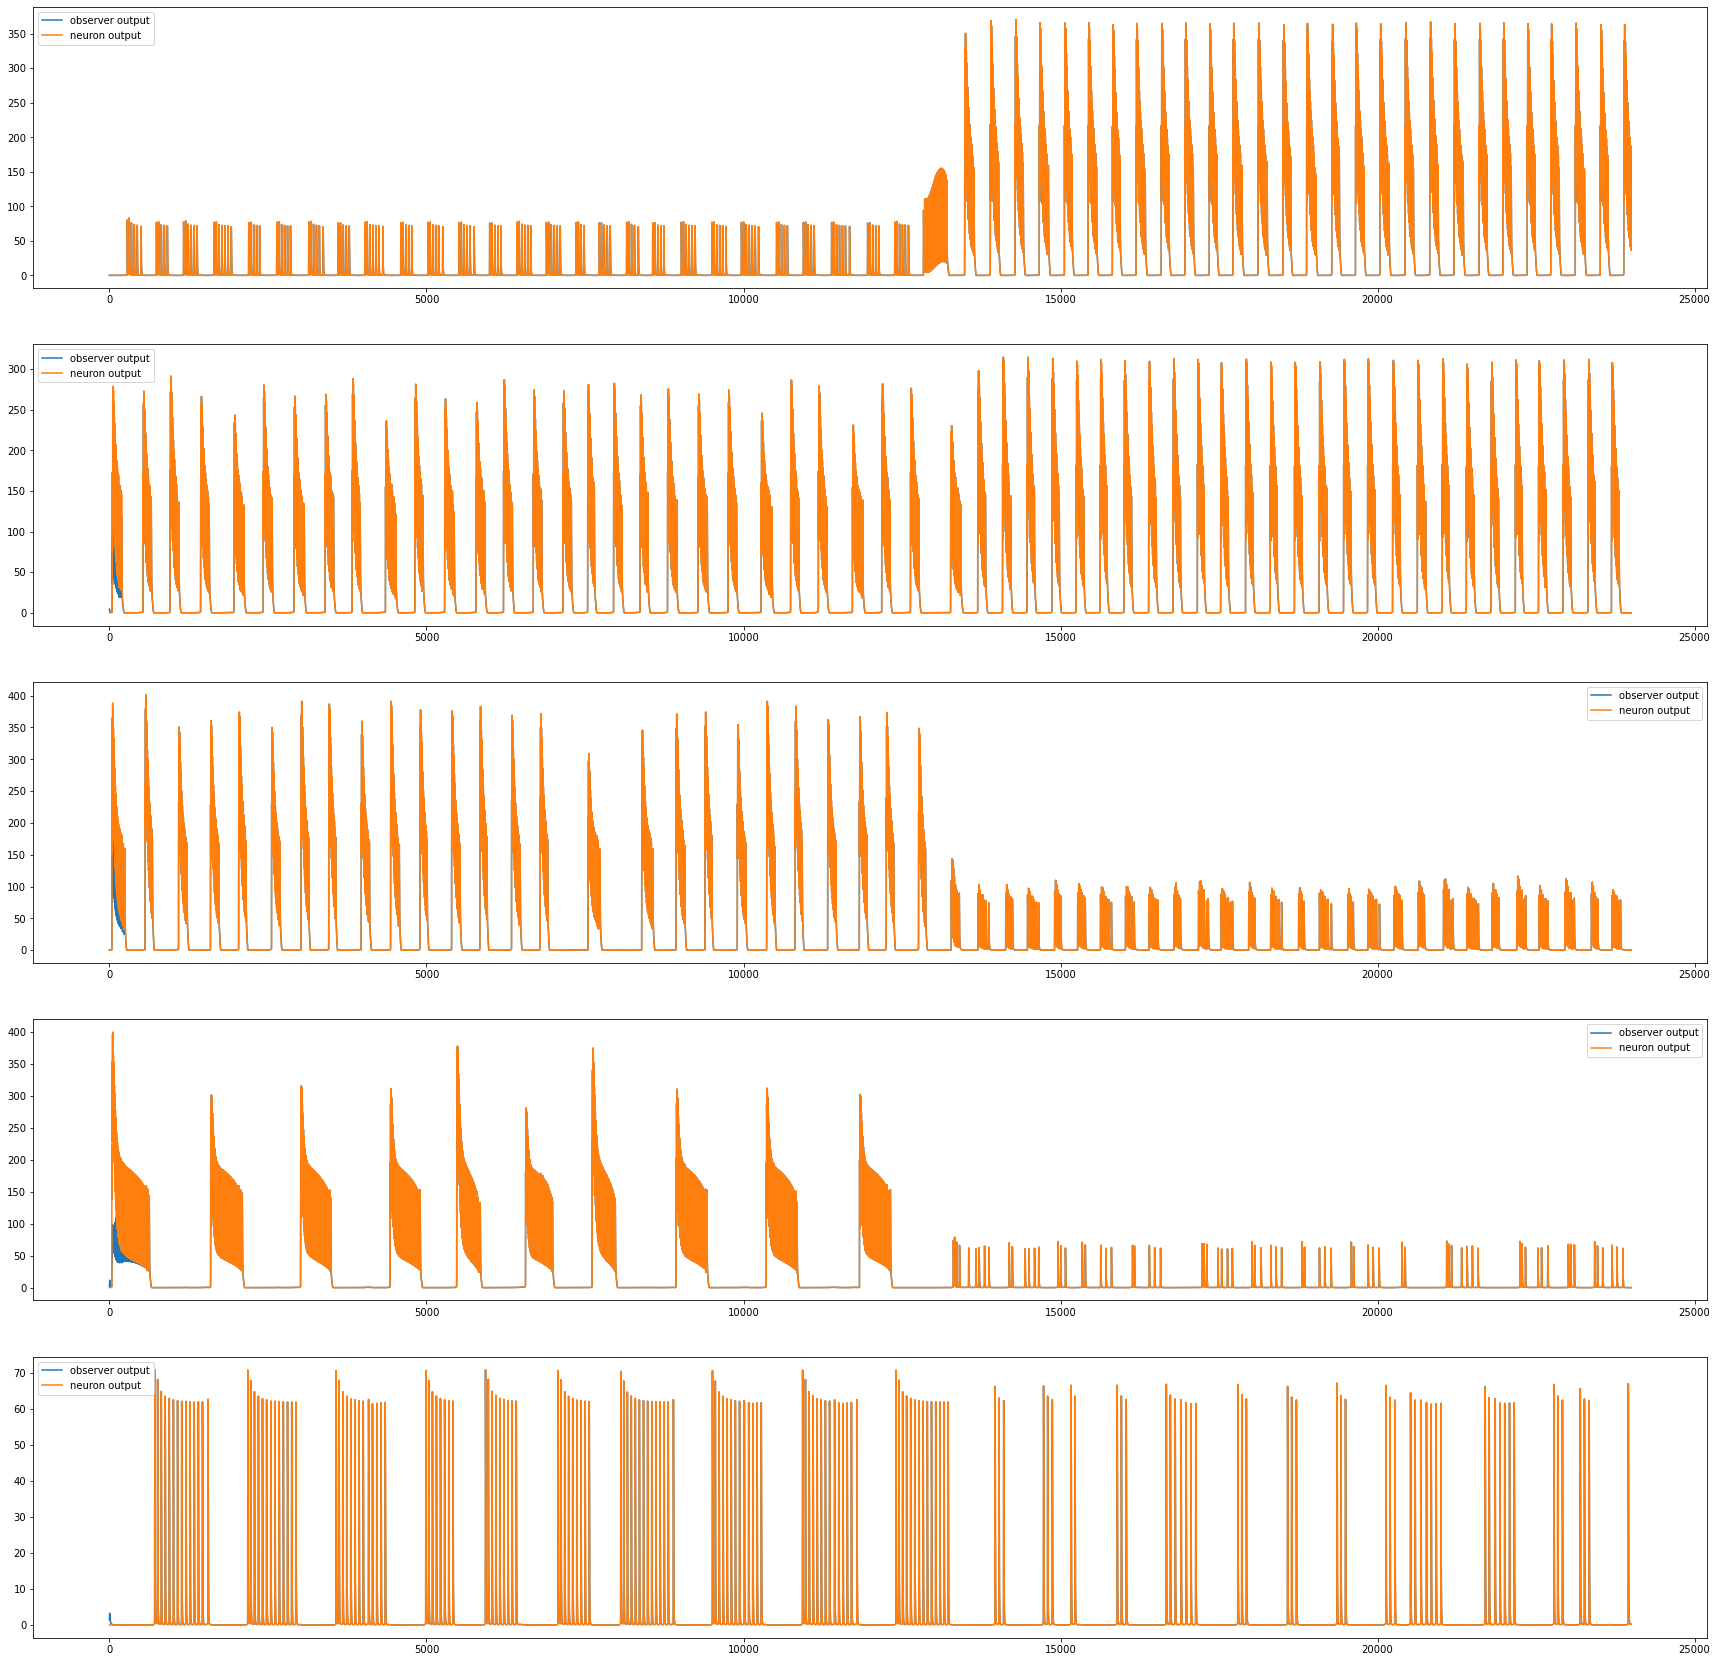

In [279]:
plot_fun1(net3,sol5)

In [214]:
net4=random_MOD_mis([0.,1.,1.,1.,0.])
#Hyperparameters
net4.set_mod(fgS,fgT)
gamma=10
alpha=0.0015
variable_mask1=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.])
variable_mask2=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
variable_mask3=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
net4.cells[0].set_hyp(gamma,alpha,variable_mask1)
net4.cells[1].set_hyp(gamma,alpha,variable_mask2)
net4.cells[2].set_hyp(gamma,alpha,variable_mask3)
net4.cells[3].set_hyp(gamma,alpha,variable_mask2)
net4.cells[4].set_hyp(gamma,alpha,variable_mask1)

[0.97332825 1.05506755 0.94319145 0.9176236  0.96358176 0.91125722]
num_Theta 8
[1.09739166 0.9596854  0.99169674 0.93043349 0.9837008  1.01993725]
num_Theta 8
[0.96420861 0.92103282 1.03926509 0.97958158 1.0744198  1.04252472]
num_Theta 8
[0.94457732 1.08192415 1.06452198 0.93505162 1.04958141 1.0869584 ]
num_Theta 8
[0.95496265 0.94298004 0.91656853 0.99439995 0.90857901 1.07872727]
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9


In [215]:
X0=[*net4.cells[0].init_cond_OB(-60+5),*net4.cells[1].init_cond_OB(-60+2),*net4.cells[2].init_cond_OB(-61),*net4.cells[3].init_cond_OB(-60-2),*net4.cells[4].init_cond_OB(-60+1)]
## Definition of simulation time.
Tfinal=24000.0
tspan=[0.0,Tfinal]
start = time.time()
sol6=solve_ivp(net4.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[2.91544692e+01 6.16587552e+01 4.72376106e+01 2.52826231e+01
 3.83150114e+01 2.07836409e+01 5.34712623e+01 5.51503132e+01
 6.64286715e-03]
[-18.06840529]
[78.97349808 52.46302134 37.33271339 63.5782751  38.26604305  7.17091528
 64.79050709 56.23281733 81.48901948 27.48263124]
[-21.42375088]
[72.42496834 34.13328038  8.66084742 53.98655936 28.66857794 43.69875889
 25.34130825 34.29796035 32.52361448 46.43511535 56.0363495  91.63756364]
[-30.54669873]
[23.80431824 36.68182763 24.88376508 58.97695143 99.33970131 65.21286318
 73.68257257 23.64724571 69.58528015 80.76663848]
[-77.50268137]
[10.57713064  9.353083   48.13547356 69.48690018 66.01441101 54.70376472
 88.29111873 60.5345492  23.05203334]
[-10.97604935]
Elapsed (with compilation) = 430.63169598579407


In [223]:
file_sol6= open('sol6.data','wb') 
pickle.dump(sol5, file_sol6)
file_sol6.close()

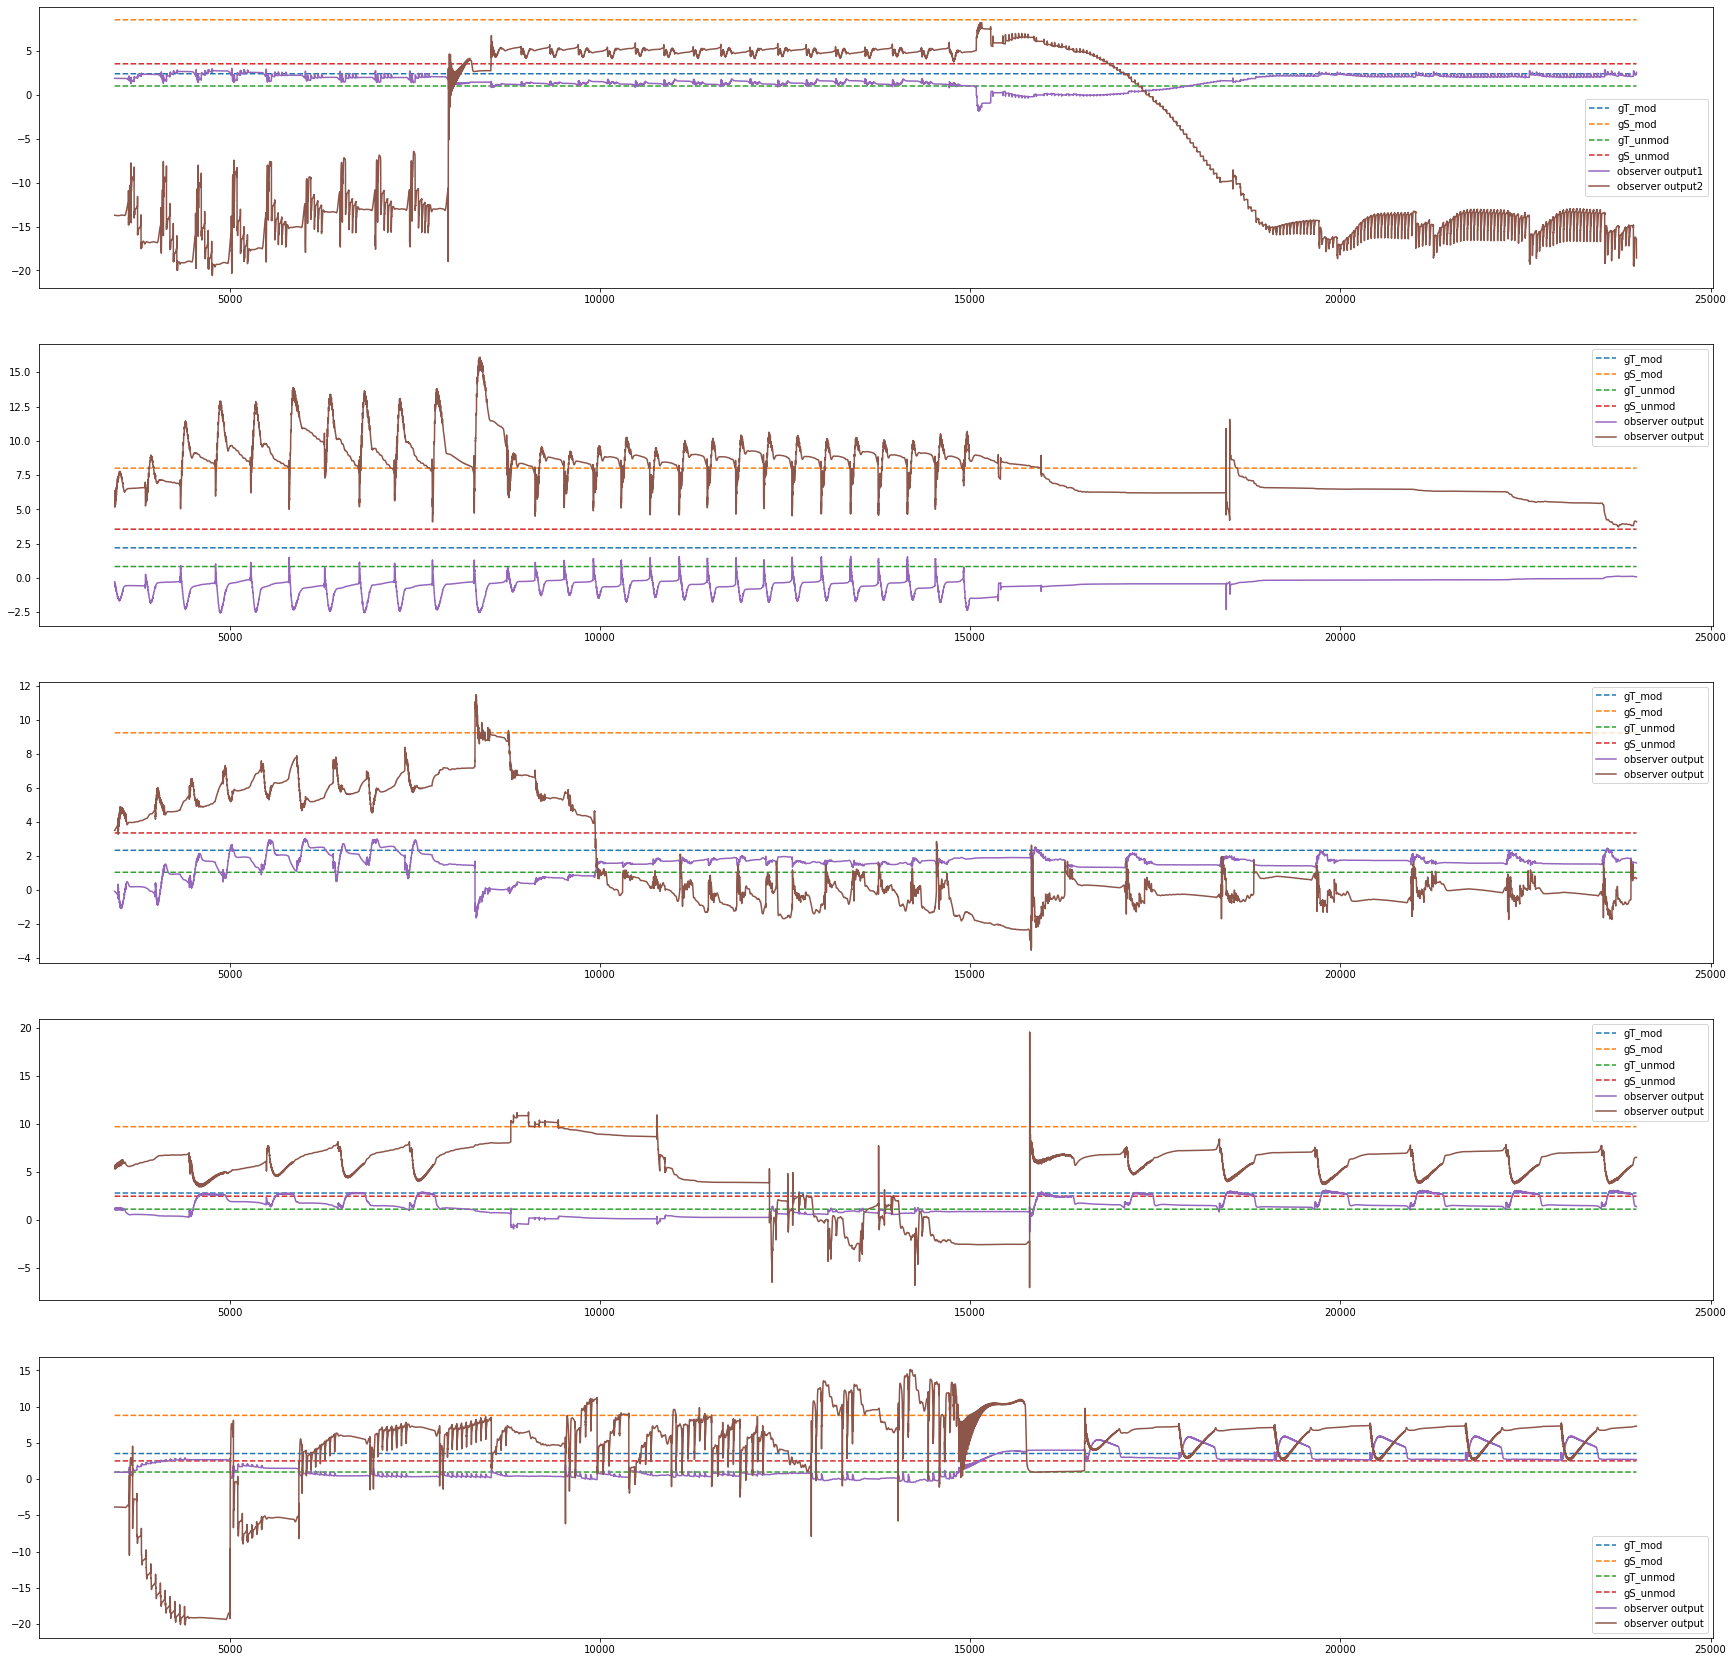

2.5460149891980746
0.0821984504428044
1.6032945669078835
1.4233484164036594
2.687147360186696


In [229]:
plot_fun2(net4,sol6)

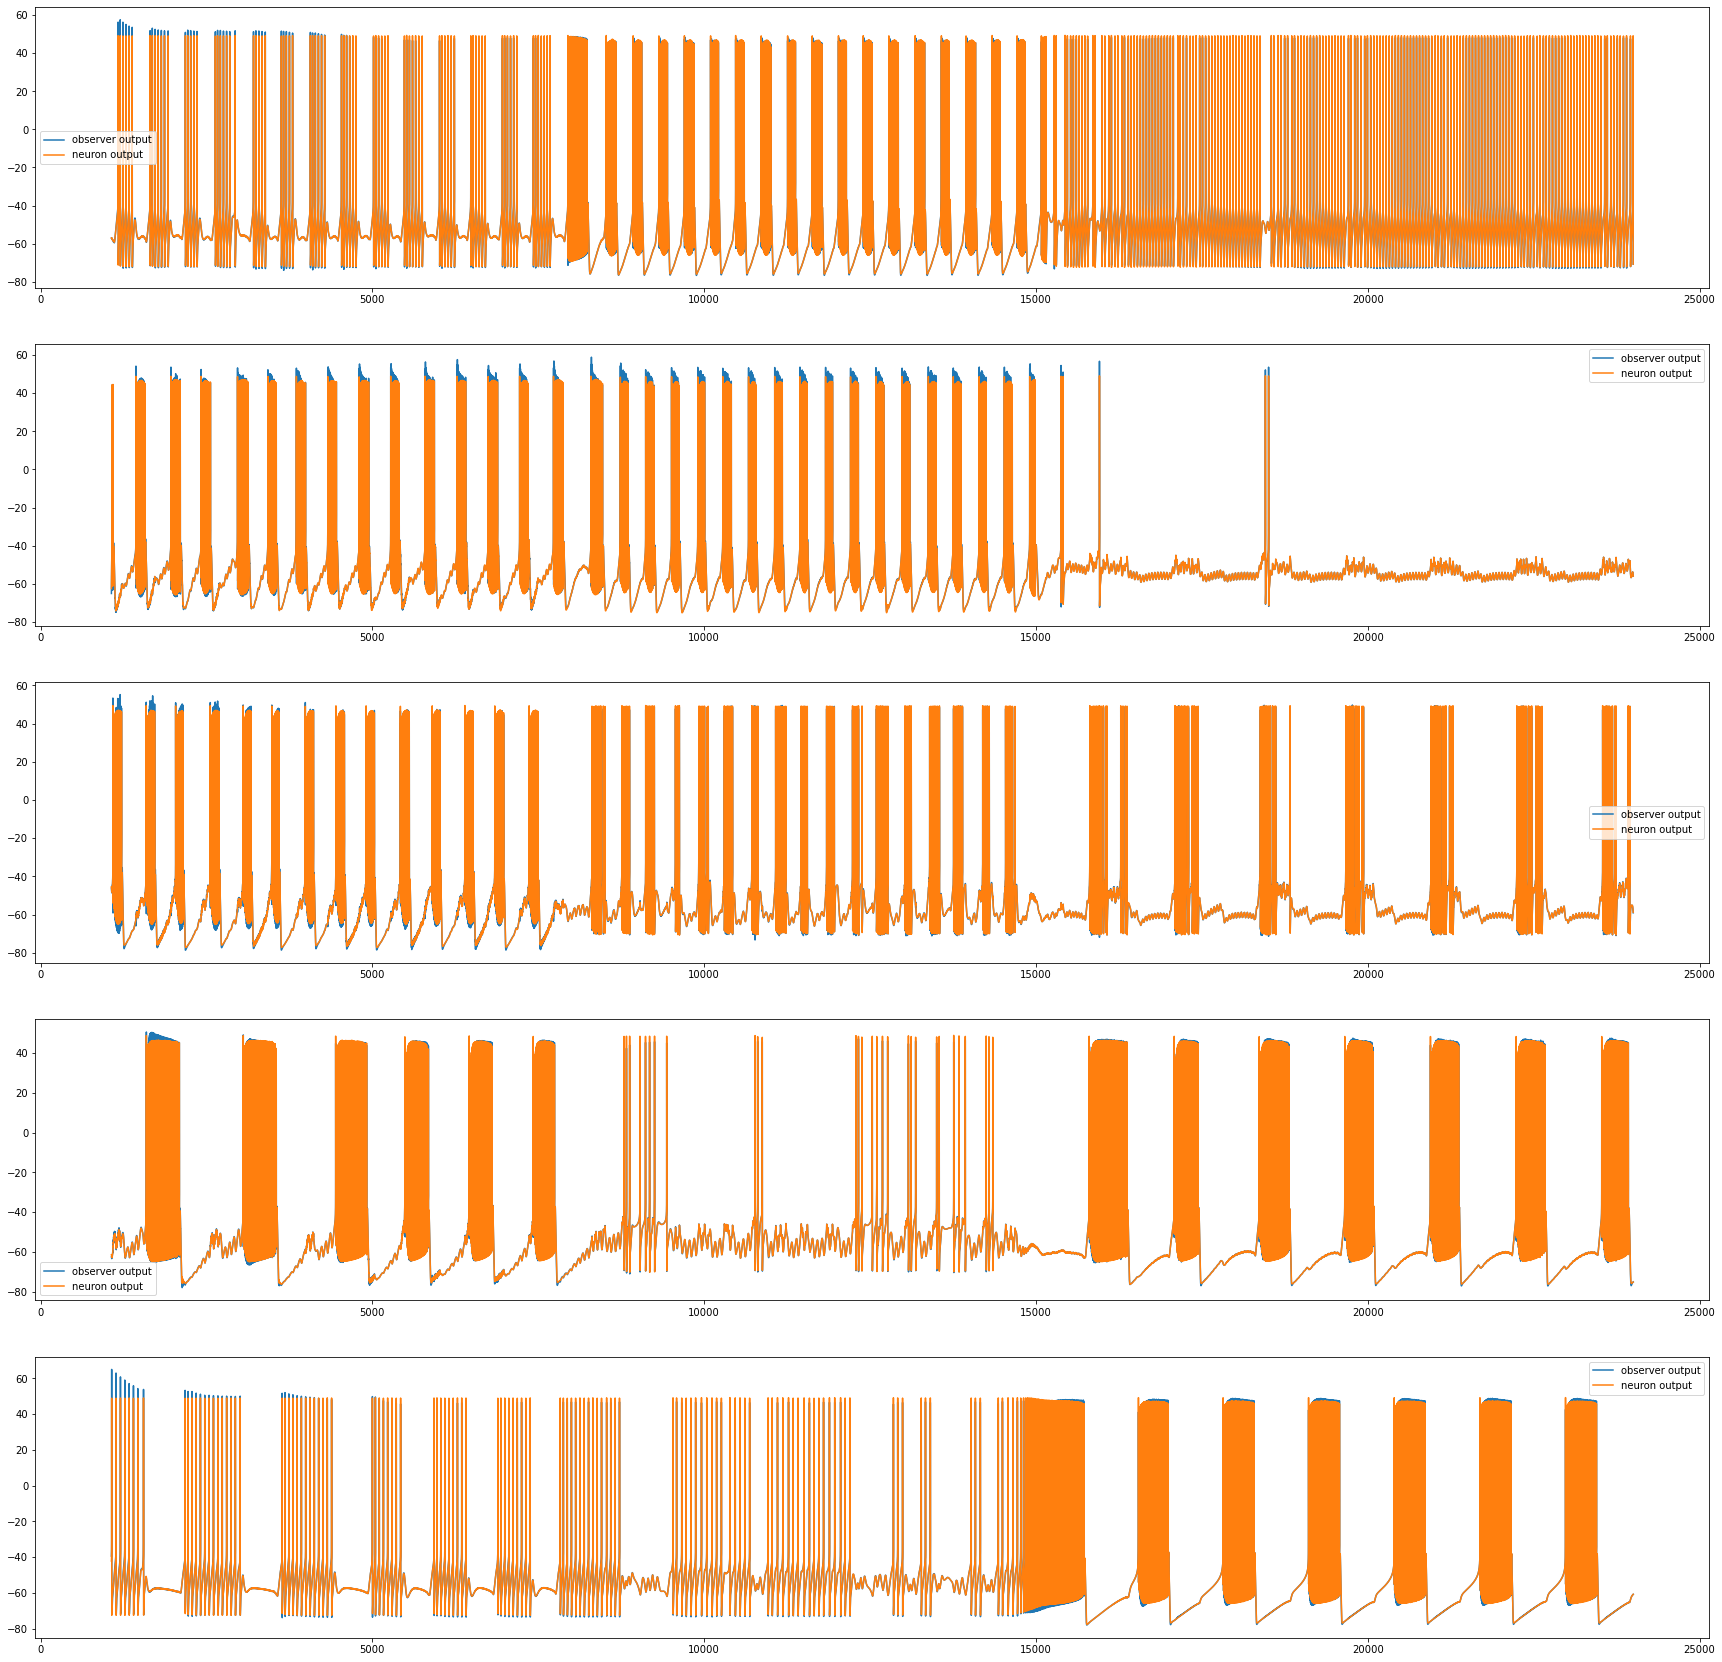

In [283]:
plot_fun(net4,sol6)

In [220]:
net5=random_MOD_mis2([0.,1.,1.,1.,0.])
#Hyperparameters
net5.set_mod(fgS,fgT)
gamma=10
alpha=0.0015
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net5.cells[0].set_hyp(gamma,alpha,variable_mask1)
net5.cells[1].set_hyp(gamma,alpha,variable_mask2)
net5.cells[2].set_hyp(gamma,alpha,variable_mask3)
net5.cells[3].set_hyp(gamma,alpha,variable_mask2)
net5.cells[4].set_hyp(gamma,alpha,variable_mask1)

[1.08013891 1.05417544 1.06159272 0.94709322 1.08637188 0.97609351]
num_Theta 8
[0.99076336 1.05573913 1.01266098 0.92707453 0.99440006 1.02552066]
num_Theta 8
[1.02162354 0.91906226 1.04972965 0.99216312 1.07706424 0.99227638]
num_Theta 8
[1.03947705 0.96915279 0.98883195 1.07340806 1.00016023 1.04674746]
num_Theta 8
[1.04687487 1.07725516 0.9373144  0.91201129 1.06451498 0.96299423]
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9


In [221]:
X0=[*net5.cells[0].init_cond_OB(-60+5),*net5.cells[1].init_cond_OB(-60+2),*net5.cells[2].init_cond_OB(-61),*net5.cells[3].init_cond_OB(-60-2),*net5.cells[4].init_cond_OB(-60+1)]
## Definition of simulation time.
Tfinal=24000.0
tspan=[0.0,Tfinal]
start = time.time()
sol7=solve_ivp(net5.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[6.52814000e+02 1.07445000e-01 5.38673213e+01 5.15008000e+01
 1.09659000e+02 1.00000000e-02 6.30373000e+01 7.02359369e+00
 7.71695119e-02]
[-91.46344446]
[5.03580000e+02 9.29811000e-02 1.37278951e+01 5.83269000e+01
 8.41655000e+01 1.00000000e-02 5.41351000e+01 6.40895808e+01
 7.63508367e-02 2.10839169e-02]
[-6.76843773]
[6.34723000e+02 7.81820000e-02 6.61349829e+01 4.03572000e+01
 7.47833000e+01 1.00000000e-02 6.57822000e+01 6.00271026e+01
 7.98892228e-02 8.83547232e-02 2.10839169e-02 2.28748603e-02]
[-53.74507227]
[4.59807000e+02 8.34140000e-02 4.73645910e+01 5.85102000e+01
 9.11938000e+01 1.00000000e-02 5.59324000e+01 2.28846766e+00
 1.17123333e-01 2.28748603e-02]
[-33.44283997]
[6.16433000e+02 8.87343000e-02 4.90239726e+01 5.18502000e+01
 1.11870000e+02 1.00000000e-02 7.02168000e+01 5.53013337e+01
 7.76215841e-02]
[-84.07883828]
Elapsed (with compilation) = 432.79829931259155


In [224]:
file_sol7= open('sol7.data','wb') 
pickle.dump(sol7, file_sol7)
file_sol7.close()

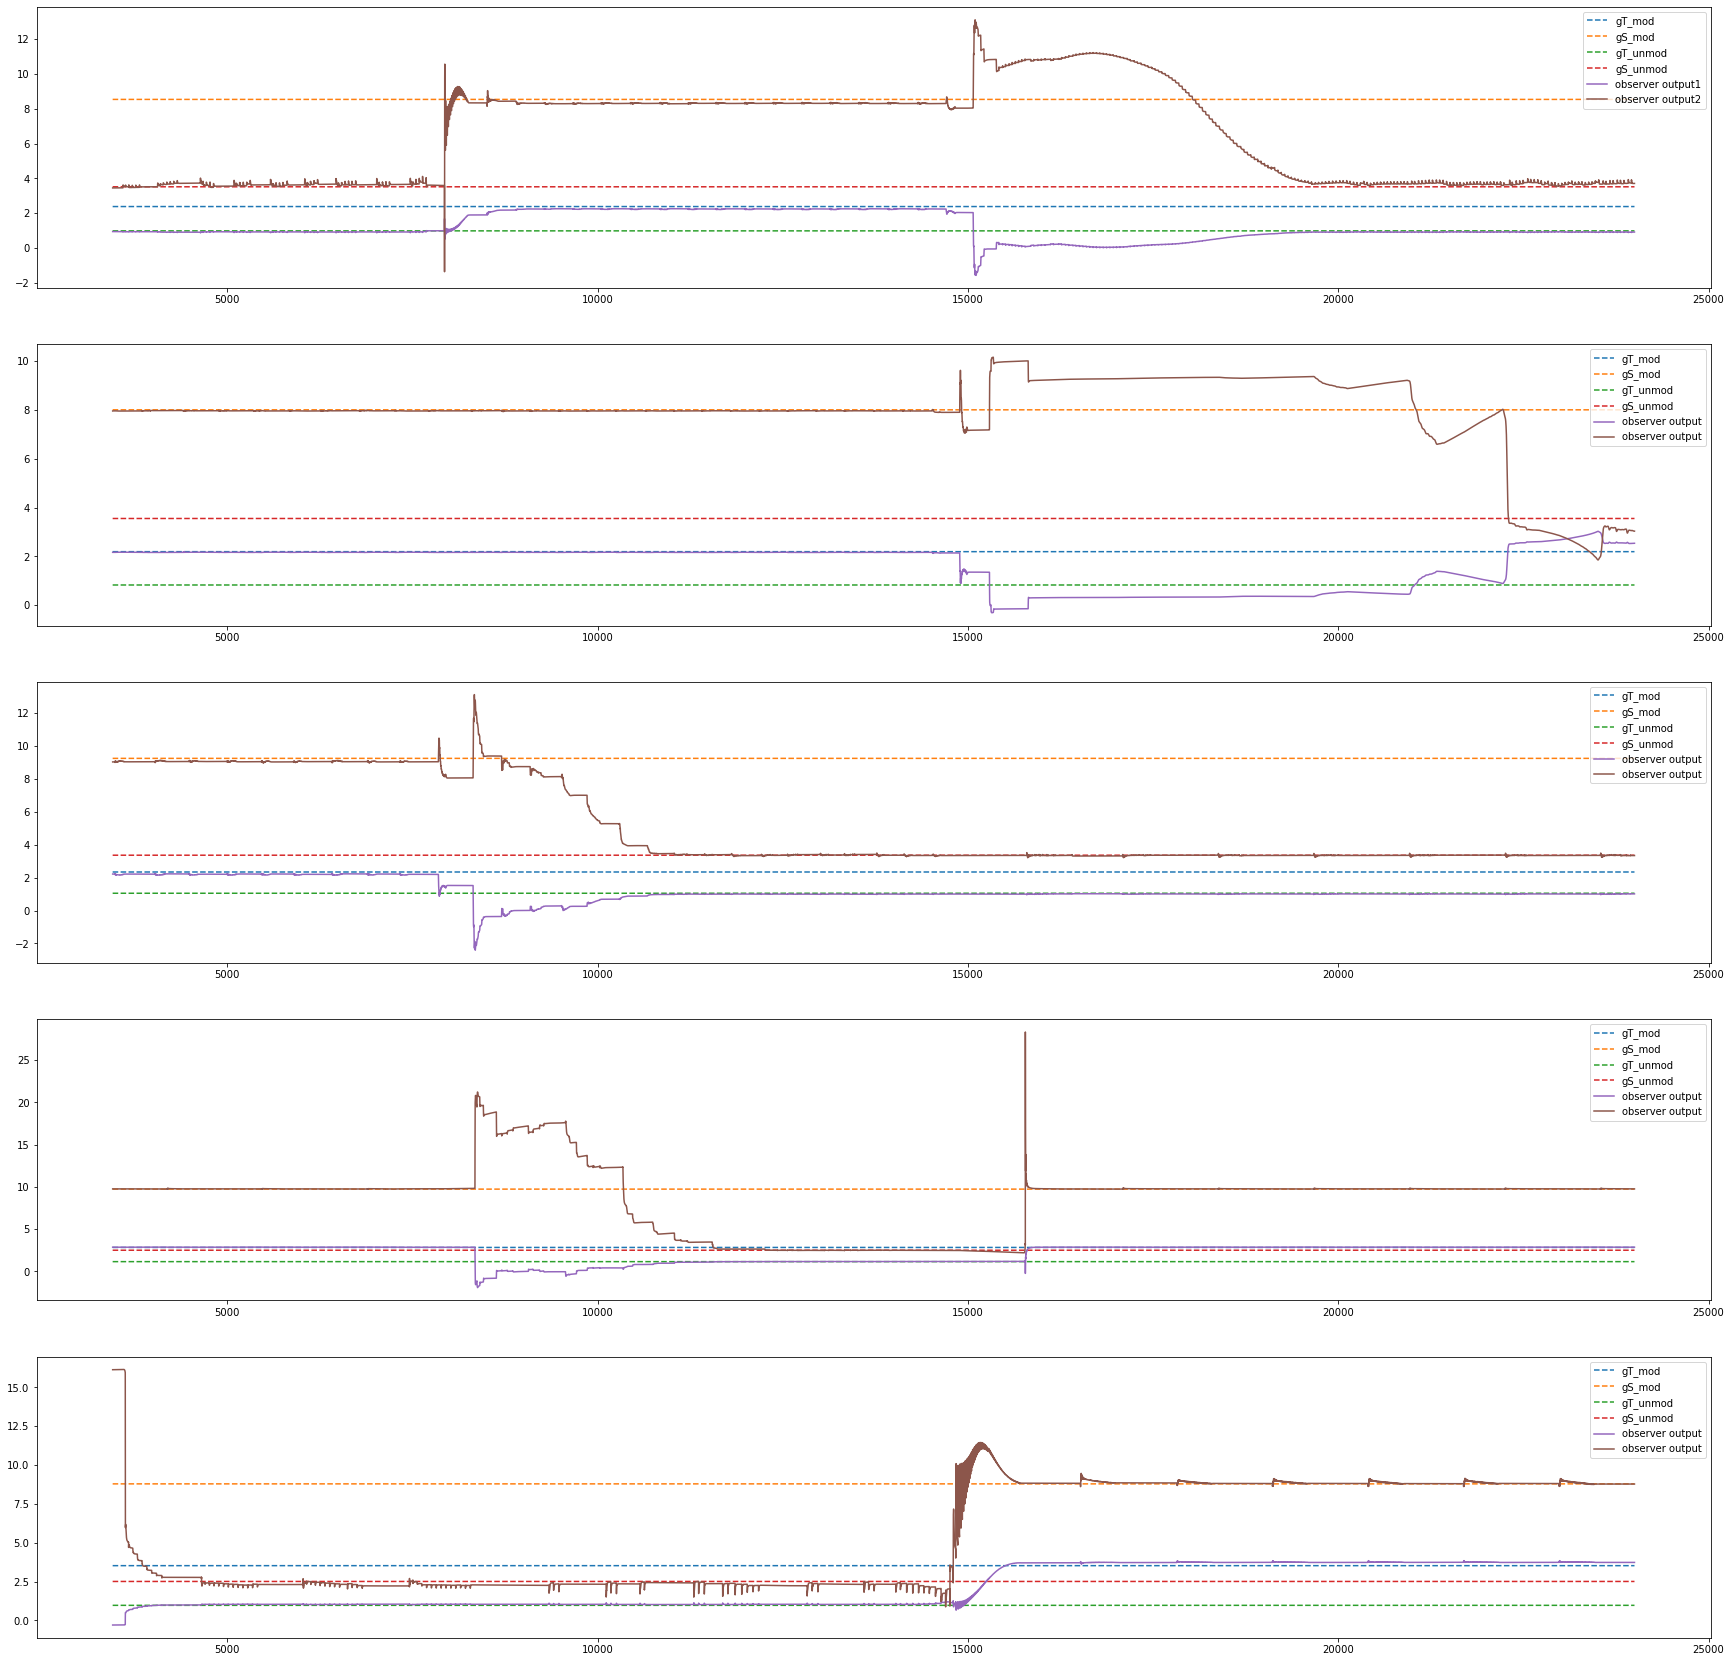

0.9240998484536105
2.5350181940973573
1.0104551286383903
2.860292847102008
3.7346326270760115


In [228]:
plot_fun2(net5,sol7)

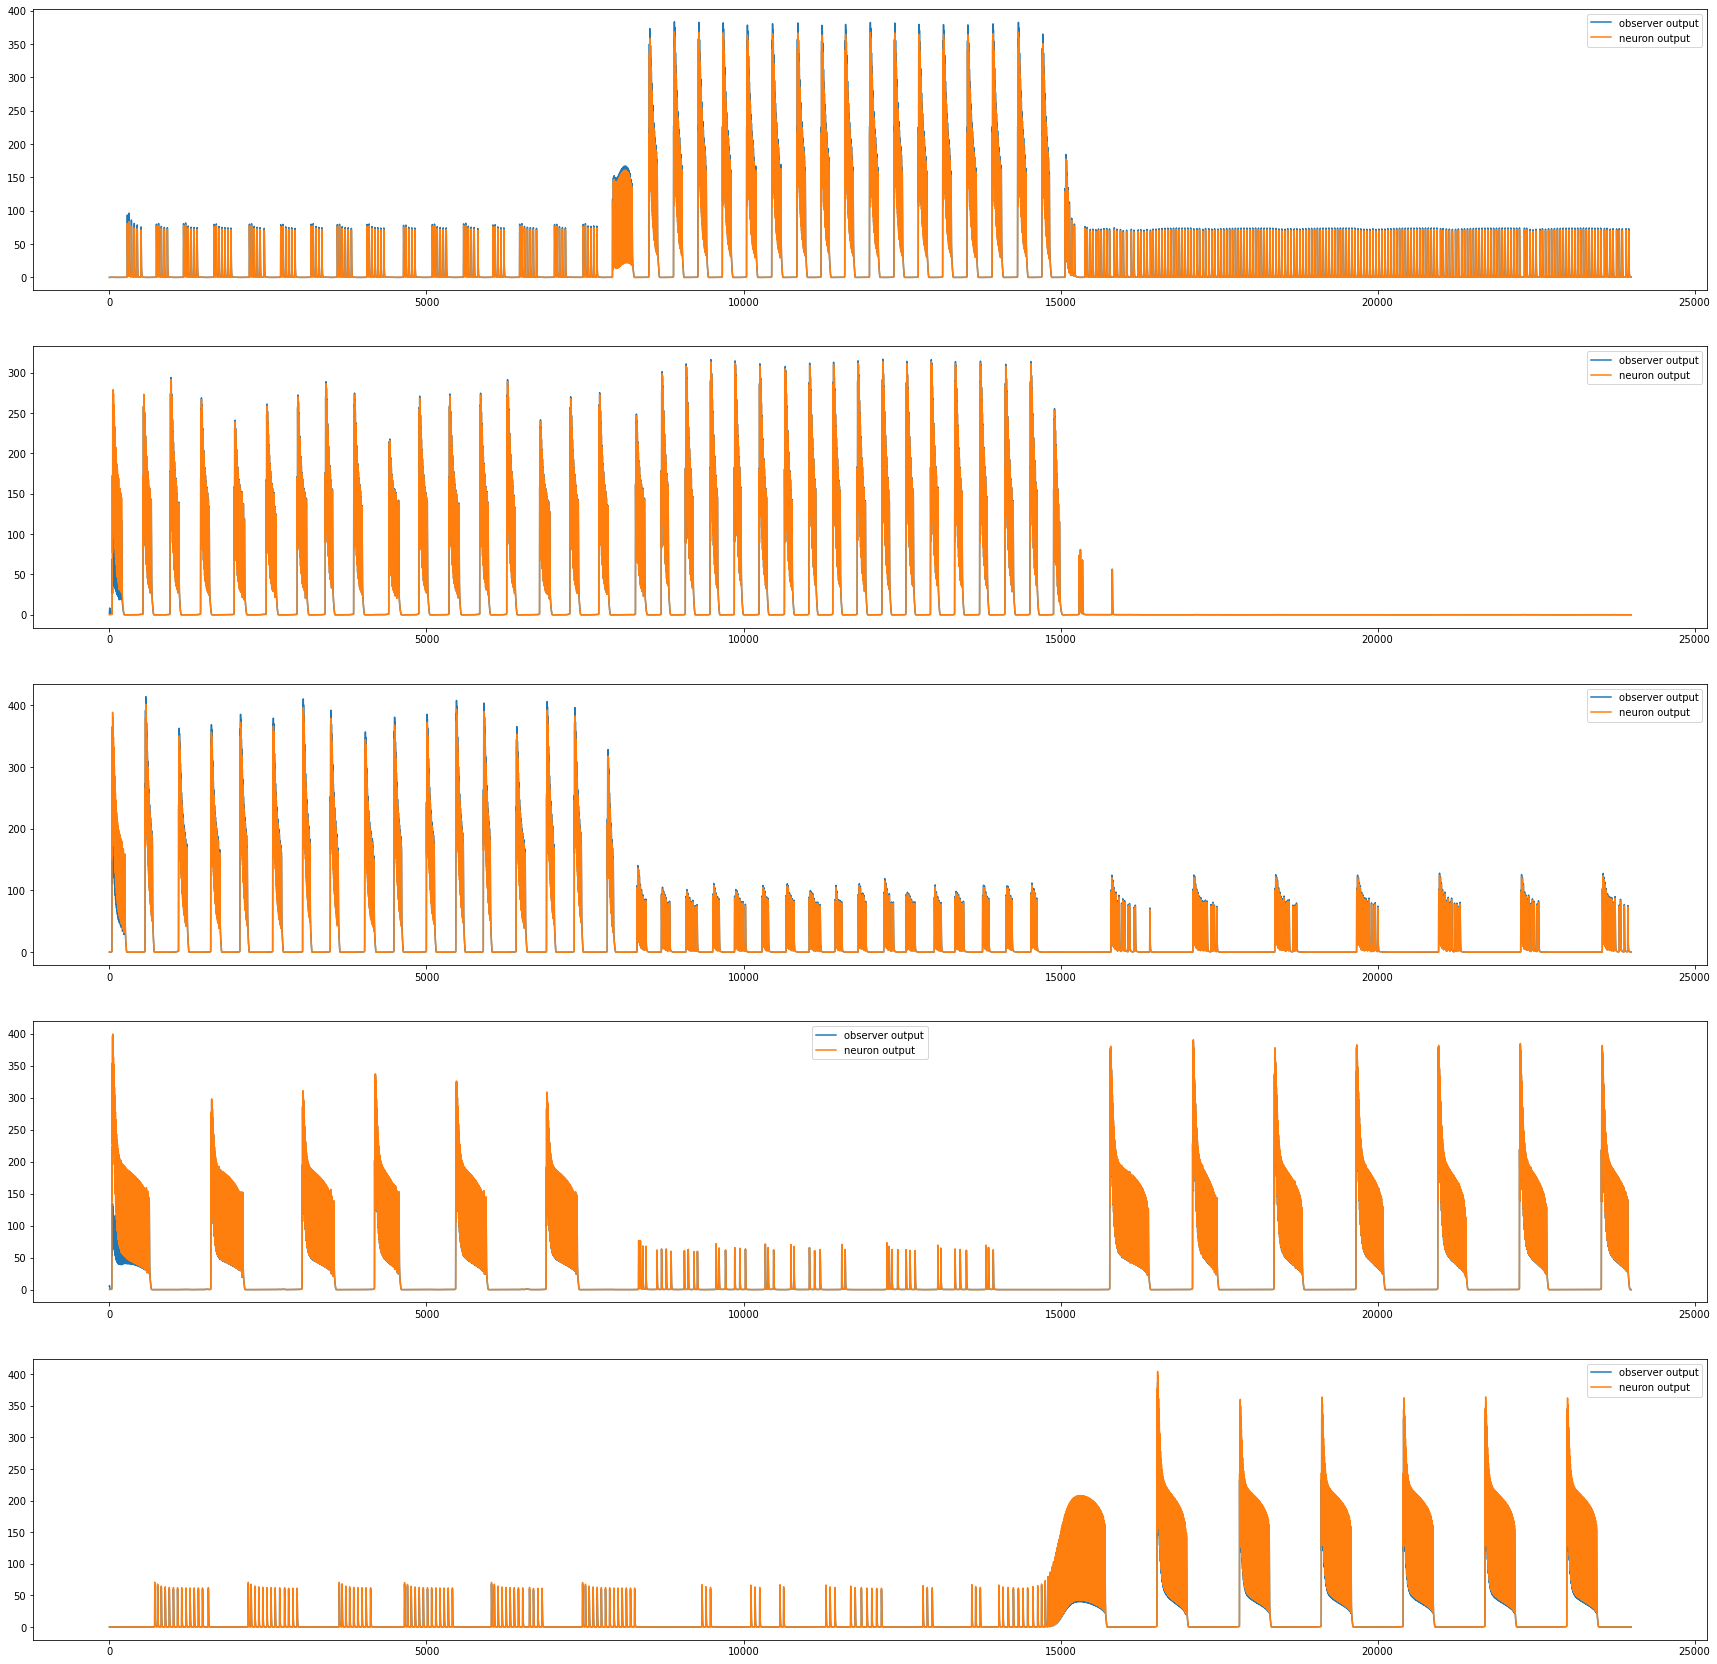

In [282]:
plot_fun1(net5,sol7)

In [242]:
net6=random_MOD_mis3([0.,1.,1.,1.,0.])
#Hyperparameters
net6.set_mod(fgS,fgT)
gamma=10
alpha=0.0015
variable_mask1=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.])
variable_mask2=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.])
variable_mask3=np.array([0.,0.,1.,0.,0.,0.,0.,1.,0.,0.,0.,0.])
net6.cells[0].set_hyp(gamma,alpha,variable_mask1)
net6.cells[1].set_hyp(gamma,alpha,variable_mask2)
net6.cells[2].set_hyp(gamma,alpha,variable_mask3)
net6.cells[3].set_hyp(gamma,alpha,variable_mask2)
net6.cells[4].set_hyp(gamma,alpha,variable_mask1)

[1. 1. 1. 1. 1. 1.]
num_Theta 8
[1. 1. 1. 1. 1. 1.]
num_Theta 8
[1. 1. 1. 1. 1. 1.]
num_Theta 8
[1. 1. 1. 1. 1. 1.]
num_Theta 8
[1. 1. 1. 1. 1. 1.]
num_Theta 8
num_Theta 8
num_Theta 9
num_Theta 9
num_Theta 10
num_Theta 10
num_Theta 12
num_Theta 9
num_Theta 10
num_Theta 8
num_Theta 9


In [243]:
X0=[*net6.cells[0].init_cond_OB(-60+5),*net6.cells[1].init_cond_OB(-60+2),*net6.cells[2].init_cond_OB(-61),*net6.cells[3].init_cond_OB(-60-2),*net6.cells[4].init_cond_OB(-60+1)]
## Definition of simulation time.
Tfinal=24000.0
tspan=[0.0,Tfinal]
start = time.time()
sol8=solve_ivp(net6.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[6.52814000e+02 1.07445000e-01 2.68124330e+01 5.15008000e+01
 1.09659000e+02 1.00000000e-02 6.30373000e+01 7.27494721e+01
 7.71695119e-02]
[-33.39168935]
[5.03580000e+02 9.29811000e-02 9.45771670e+01 5.83269000e+01
 8.41655000e+01 1.00000000e-02 5.41351000e+01 2.94717918e+01
 7.63508367e-02 2.10839169e-02]
[-1.82920914]
[6.34723000e+02 7.81820000e-02 3.72632727e+01 4.03572000e+01
 7.47833000e+01 1.00000000e-02 6.57822000e+01 4.17067403e+01
 7.98892228e-02 8.83547232e-02 2.10839169e-02 2.28748603e-02]
[-57.94561497]
[4.59807000e+02 8.34140000e-02 5.85098970e+00 5.85102000e+01
 9.11938000e+01 1.00000000e-02 5.59324000e+01 6.04912048e+01
 1.17123333e-01 2.28748603e-02]
[-2.0693203]
[6.16433000e+02 8.87343000e-02 7.10402081e+01 5.18502000e+01
 1.11870000e+02 1.00000000e-02 7.02168000e+01 3.83320354e+01
 7.76215841e-02]
[-4.08218166]
Elapsed (with compilation) = 414.7735242843628


In [244]:
file_sol8= open('sol8.data','wb') 
pickle.dump(sol8, file_sol8)
file_sol8.close()

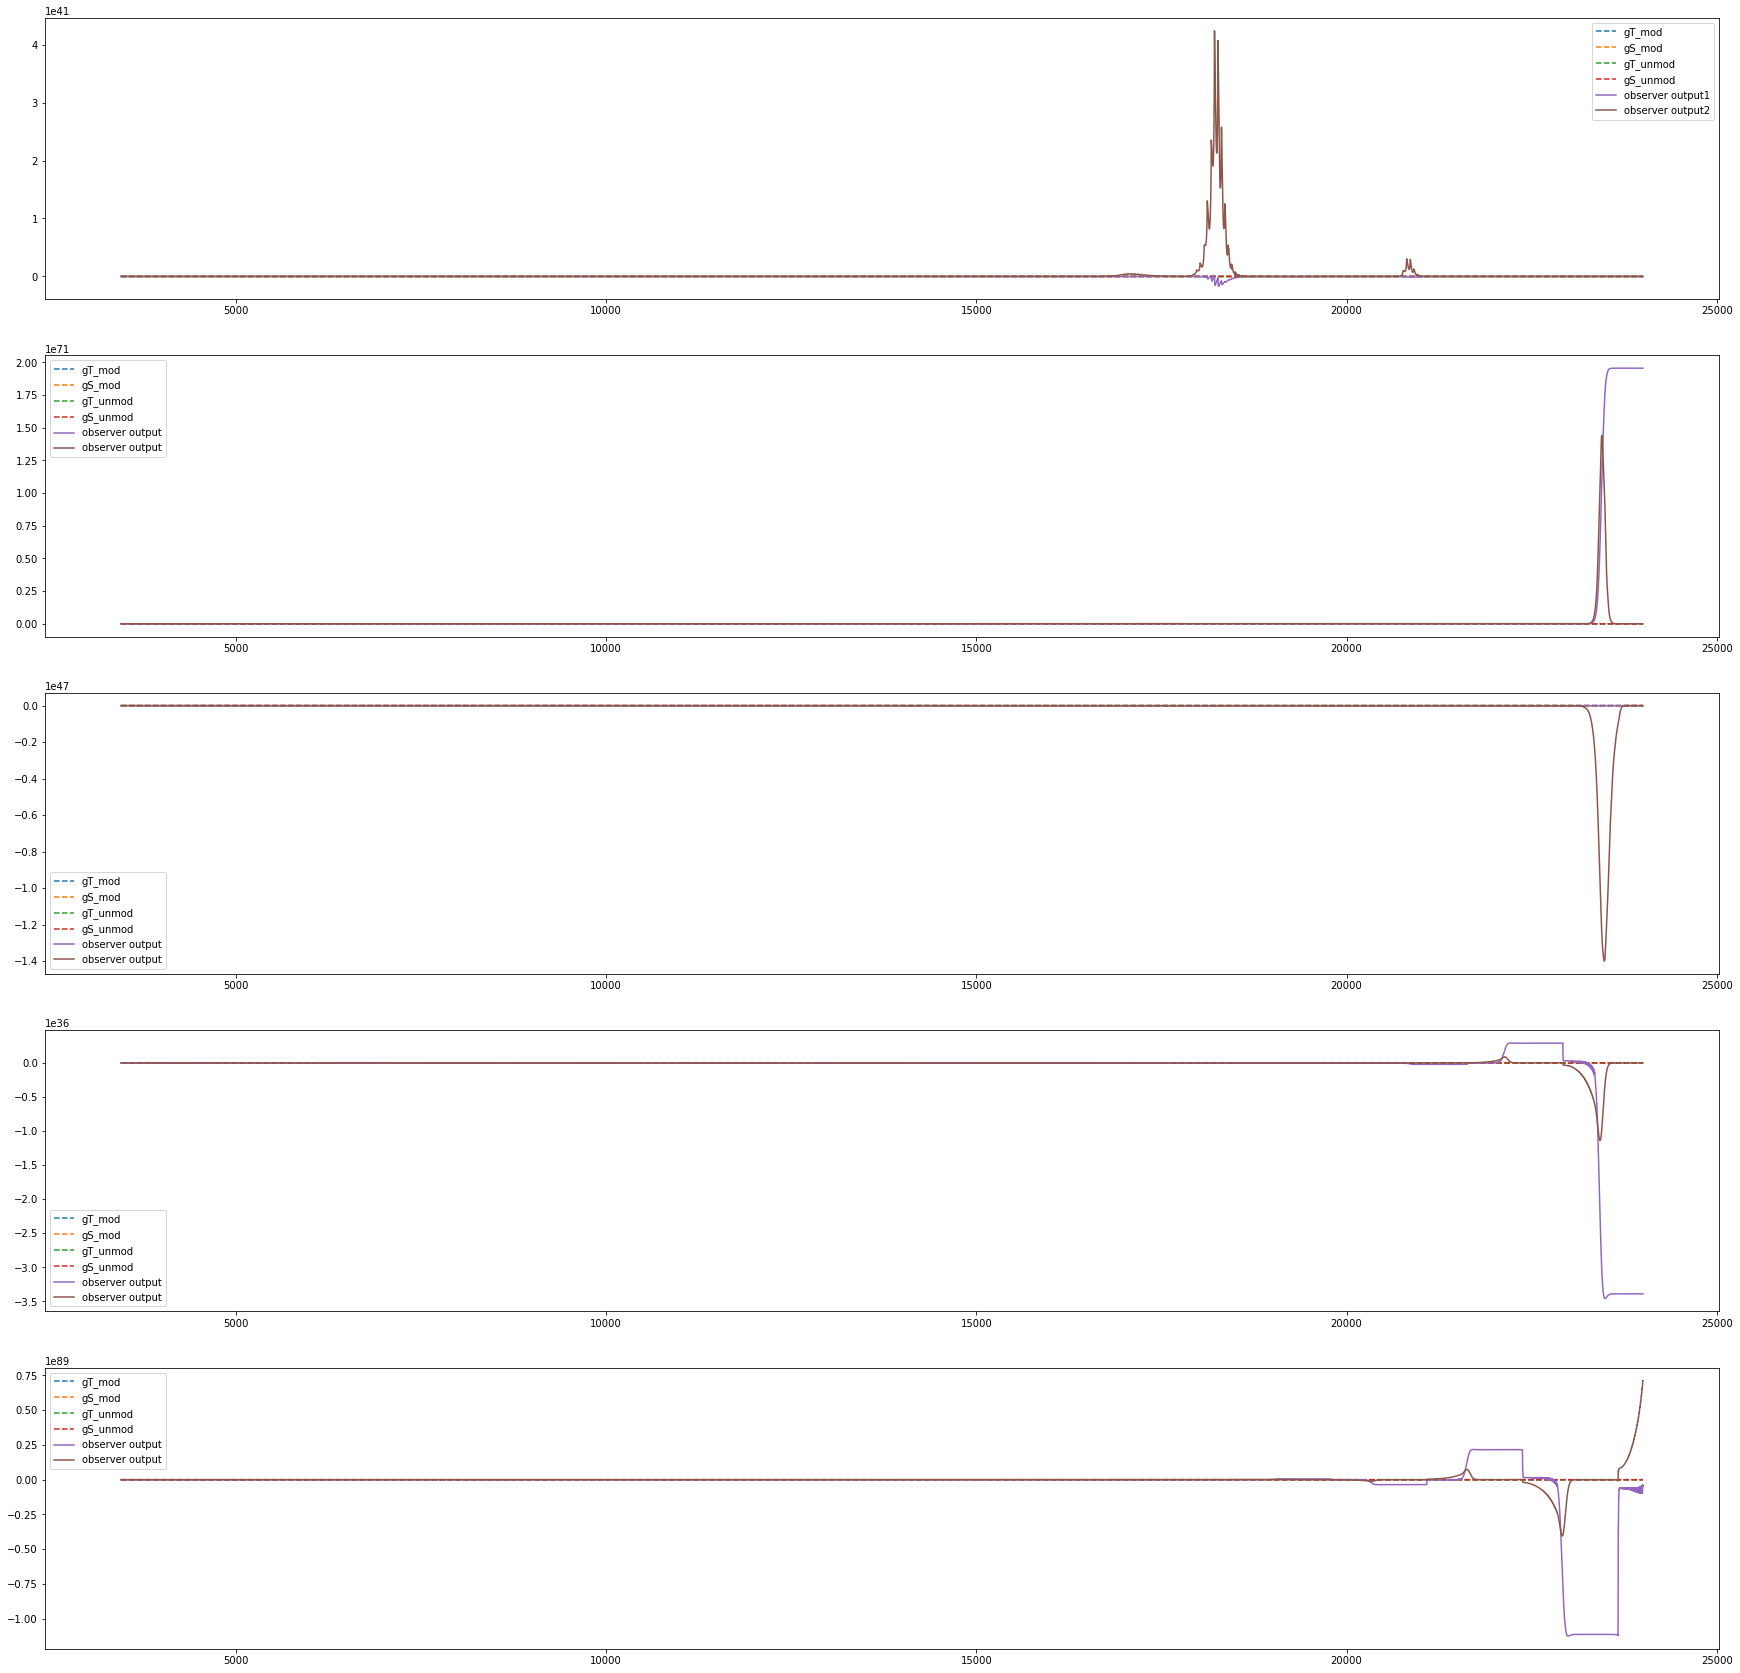

-7.240373829568726e+28
1.955209338234468e+71
-3.9326756219028174e+43
-3.3894507529682526e+36
-4.536856084950388e+87


In [245]:
plot_fun2(net6,sol8)

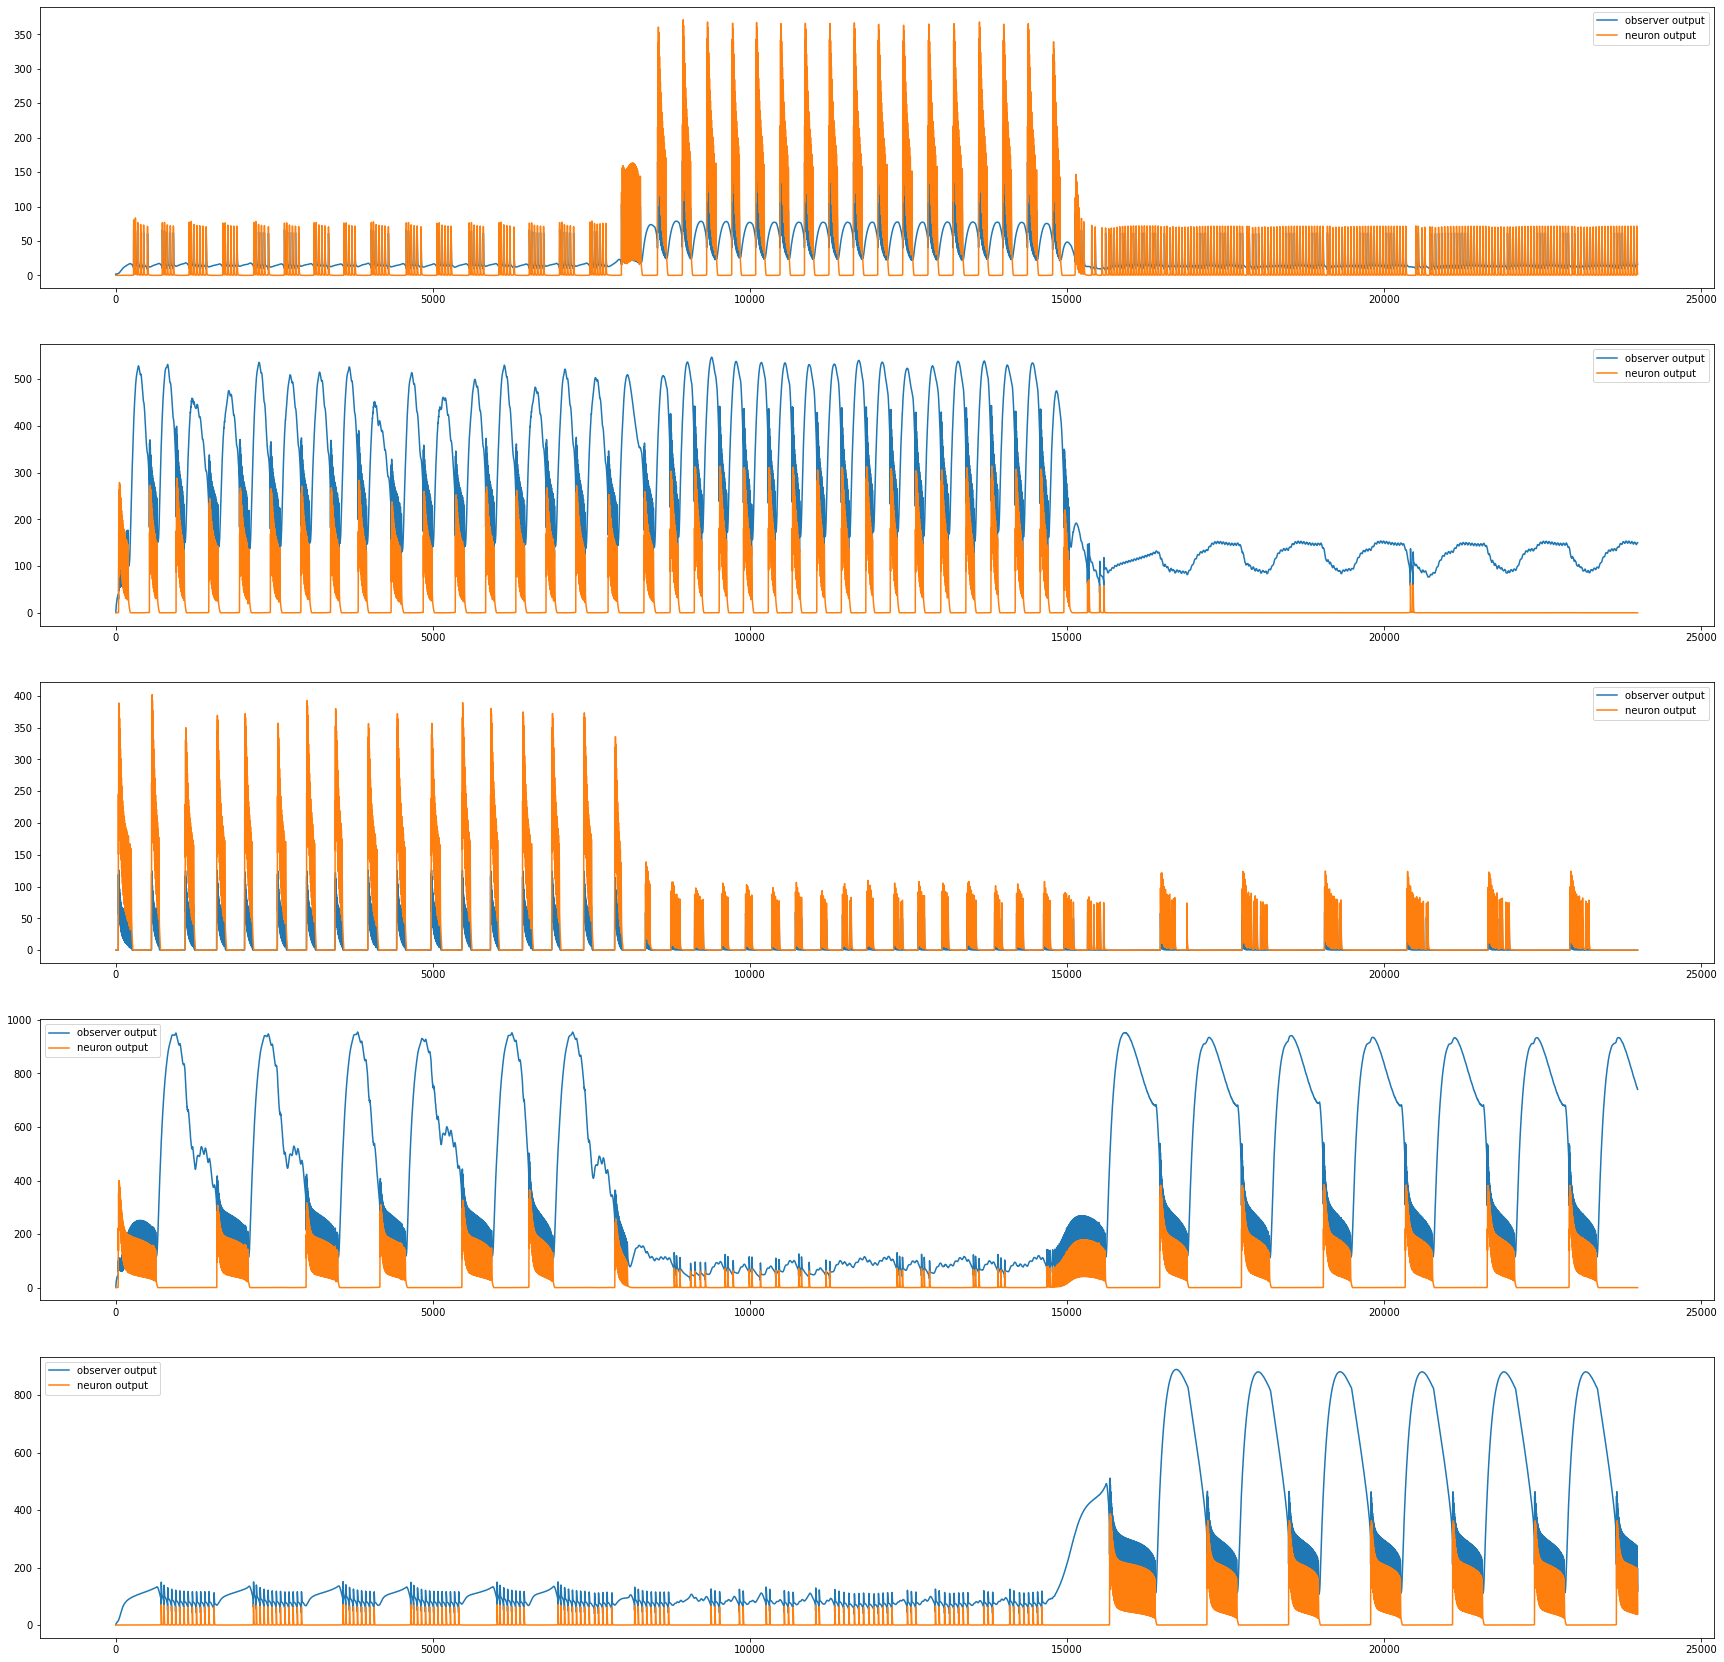

In [284]:
plot_fun1(net6,sol8)